#Spatiotemporal Modeling of Water Chemistry to Predict Microbiological Events and Agricultural Yield Patterns Across New York State

---

##Project Setup and Environment

In [1]:
# === Imports ===
#Standard Library Imports
import os, re, json, math, time, textwrap, pathlib, itertools, socket
from pathlib import Path
from typing import Optional, Dict, Any, List

#HTTP and Web Utilities
import requests
from urllib.parse import quote_plus

#Numerical and Data Handling
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Utilities
from functools import reduce
from google.colab import files

# == Machine Learning ==
#Model Selection and Metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

#Preprocessing
from sklearn.impute import SimpleImputer

# === Local Data Directory Setup ===
!mkdir -p data

# === Global Configuration ===
DATA_ROOT = Path("/content/agny-SP/data").resolve()
SOCRATA_APP_TOKEN = os.getenv("NYC_OPENDATA_APP_TOKEN", None)


In [226]:
from sklearn.metrics import f1_score
import zipfile
from google.colab import files
import shap

##Data Acquisition





###Datasets Download

In [2]:
# === Helpers ===
#Log Helper
def log(msg: str):
    print(f"[DL] {msg}")

#Save raw bytes to disk
def save_bytes(content: bytes, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        f.write(content)
    log(f"Saved: {path} ({len(content):,} bytes)")

#HTTP GET
def http_get(url: str, headers: Optional[Dict[str,str]] = None, params: Optional[Dict[str,Any]] = None, retries: int = 4, sleep: float = 1.0):
    last_err = None
    for i in range(retries):
        try:
            r = requests.get(url, headers=headers, params=params, timeout=60)
            r.raise_for_status()
            return r
        except Exception as e:
            last_err = e
            log(f"GET failed ({i+1}/{retries}) for {url}: {e}")
            time.sleep(sleep * (i+1))
    raise last_err

#Excel to CSV Conversion
def excel_to_csvs(xlsx_path: Path, out_dir: Path, preview_rows: int = 3):
    out_dir.mkdir(parents=True, exist_ok=True)
    xl = pd.ExcelFile(xlsx_path)
    shapes = {}
    for sheet in xl.sheet_names:
        df = xl.parse(sheet_name=sheet)
        safe_sheet = re.sub(r'[^A-Za-z0-9._-]+', '_', sheet).strip('_')
        csv_path = out_dir / f"{xlsx_path.stem}__{safe_sheet}.csv"
        df.to_csv(csv_path, index=False)
        shapes[sheet] = (df.shape[0], df.shape[1])
        log(f"  - wrote {csv_path.name}: {df.shape[0]} rows x {df.shape[1]} cols")
        if preview_rows > 0:
            with pd.option_context("display.width", 160, "display.max_columns", None):
                log(f"    Preview of '{sheet}':\n{df.head(preview_rows)}")
    return shapes

In [3]:
# === USGS ScienceBase Helpers ===

#Fetch item JSON metadata
def sciencebase_fetch(item_id: str) -> Dict[str, Any]:
    url = f"https://www.sciencebase.gov/catalog/item/{item_id}?format=json"
    r = http_get(url)
    return r.json()

#Dowmload matching Excel files
def sciencebase_download_excel(item_id: str, out_dir: Path, filename_match: Optional[str] = None):
    meta = sciencebase_fetch(item_id)
    files = meta.get("files") or []
    if not files:
        raise RuntimeError(f"No files listed for ScienceBase item {item_id}")

    downloaded = []
    for f in files:
        name = f.get("name") or ""
        url  = f.get("url")  or ""
        if not name or not url:
            continue
        if filename_match and filename_match.lower() not in name.lower():
            continue
        if not name.lower().endswith((".xlsx", ".xls")):
            continue

        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / name
        resp = http_get(url)
        save_bytes(resp.content, out_path)
        downloaded.append(out_path)
    if not downloaded:
        raise RuntimeError(f"No matching Excel files found for item {item_id} (filter={filename_match})")
    return downloaded

In [4]:
# === NYC Open Data (Socrata) Helper ===

def socrata_to_csv(resource_id: str, out_csv: Path, domain: str = "data.cityofnewyork.us", chunk: int = 50_000):
    headers = {}
    if SOCRATA_APP_TOKEN:
        headers["X-App-Token"] = SOCRATA_APP_TOKEN

    out_csv.parent.mkdir(parents=True, exist_ok=True)
    first = True
    offset = 0
    total_rows = 0

    while True:
        params = {
            "$limit": chunk,
            "$offset": offset
        }
        url = f"https://{domain}/resource/{resource_id}.json"
        resp = http_get(url, headers=headers, params=params)
        rows = resp.json()
        if not rows:
            break
        df = pd.DataFrame(rows)
        mode = "w" if first else "a"
        header = first
        df.to_csv(out_csv, index=False, mode=mode, header=header)
        total_rows += len(df)
        log(f"{resource_id}: fetched {len(df):,} rows (offset {offset:,})")
        first = False
        offset += chunk


    if total_rows > 0:
        df_head = pd.read_csv(out_csv, nrows=5)
        log(f"Wrote {total_rows:,} rows to {out_csv.name}. Preview:\n{df_head}")
    else:
        log(f"No rows found for {resource_id}")

In [5]:
# === WQP URL Builder and Downloader ===
def build_wqp_result_url(statecode: str,
                         start: str,
                         end: str,
                         profile: str,
                         providers: list,
                         characteristics: Optional[list] = None) -> str:
    base = (
        "https://www.waterqualitydata.us/data/Result/search?"
        f"statecode={quote_plus(statecode)}&"
        f"startDateLo={start}&"
        f"startDateHi={end}&"
        f"dataProfile={quote_plus(profile)}&"
        "mimeType=csv&zip=no&sorted=no"
    ) #start and end must be 'MM-DD-YYYY' because WQP is picky

    # Providers ["NWIS", "STORET"]
    for p in providers:
        base += f"&providers={quote_plus(p)}"

    return base

In [6]:
# === WQP result to CSV helper ===
def wqp_result_to_csv(cfg: Dict[str, Any], out_csv: Path):
    statecode = cfg.get("statecode", "US:36")
    start     = cfg.get("start", "2010-01-01")
    end       = cfg.get("end",   "2024-12-31")
    profile   = cfg.get("profile", "resultPhysChem")
    providers = cfg.get("providers", ["NWIS", "STORET"])

    url = build_wqp_result_url(
        statecode=statecode,
        start=start,
        end=end,
        profile=profile,
        providers=providers,
    )

    out_csv.parent.mkdir(parents=True, exist_ok=True)
    log(f"WQP: fetching {url}")

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_csv, "wb") as f:
            for chunk in r.iter_content(chunk_size=1_000_000):
                if chunk:
                    f.write(chunk)

    try:
        df = pd.read_csv(out_csv, nrows=5, low_memory=False)
        log(f"Preview of {out_csv.name}:\n{df}")
    except Exception as e:
        log(f"Note: Could not parse preview as CSV yet ({e}). File still saved.")

In [7]:
# === Dataset Manifest Configuration ===
MANIFEST = {
    # --- USGS ScienceBase ---
    "USGS_LI_PineBarrens_2020": {
        "type": "sciencebase",
        "item_id": "62d9650bd34e2842e1edcf5a",
        "file_contains": "LIPineBarrens_2020_DataRelease.xlsx"
    },
    "USGS_LI_PineBarrens_2021": {
        "type": "sciencebase",
        "item_id": "63208bc8d34e71c6d67aa87e",
        "file_contains": "LIPineBarrens_2021_DataRelease.xlsx"
    },
    "USGS_LI_PineBarrens_2022": {
        "type": "sciencebase",
        "item_id": "64c7f088d34e70357a349e3b",
        "file_contains": "LIPineBarrens_2022_DataRelease.xlsx"
    },

    # --- Bronx River PFAS/pesticides/pharmaceuticals (ScienceBase) ---
    "USGS_BronxRiver_2019_PFAS_Pest_Pharma": {
        "type": "sciencebase",
        "item_id": "62d96512d34e2842e1edcf5e",
        "file_contains": "PFAS_pesticides_pharmaceuticals_BronxRiver2019_NYC_NY_all_data.xlsx"
    },

    # --- Western NY & Mohawk River Basin Groundwater 2021 (ScienceBase) ---
    "USGS_WNY_Mohawk_2021": {
        "type": "sciencebase",
        "item_id": "65203b86d34e44db0e2e4406",
        "file_contains": ".xlsx"  # catch the main Excel
    },

    # --- Long Island shallow groundwater 2016-2018 (ScienceBase) ---
    "USGS_LI_ShallowGW_2016_2018": {
        "type": "sciencebase",
        "item_id": "5e83a6b4e4b01d50927b62a9",
        "file_contains": ".xlsx"
    },

    # --- NYC Open Data (Socrata) ---
    "NYC_DEP_Distribution_WQ": {
        "type": "socrata",
        "resource_id": "bkwf-xfky",
        "outfile": "Drinking_Water_Quality_Distribution_Monitoring_Data.csv"
    },
    "NYC_DEP_Watershed_WQ": {
        "type": "socrata",
        "resource_id": "y43c-5n92",
        "outfile": "Watershed_Water_Quality_Data.csv"
    },
     "NYC_DEP_Harbor_WQ": {
        "type": "socrata",
        "resource_id": "5uug-f49n",
        "outfile": "Harbor_Water_Quality.csv"
    },

    # --- USDA/NASS CSV ---
    "USDA_NASS_Regional_Crop_Yield": {
        "type": "direct_csv",
        "urls": [
            "https://quickstats.nass.usda.gov/data/printable/F749339A-E2BC-3A10-BFCC-91B6686691E0",
            "https://quickstats.nass.usda.gov/results/3D668DBB-3D36-3013-8052-B1F3C7580171"
        ],
        "outfile": "USDA_Regional_Crop_Yield_Data.csv"
    },
    "WQP_NY_Surface_PhysChem": {
        "type": "wqp",
        "profile": "resultPhysChem",
        "statecode": "US:36",
        "start": "01-01-2010",
        "end":   "01-01-2025",
        "providers": ["NWIS", "STORET"],
        "outfile": "WQP_NY_Surface_PhysChem.csv"
    },
    "WQP_NY_Surface_Bio": {
        "type": "wqp",
        "profile": "biological",
        "statecode": "US:36",
        "start": "01-01-2010",
        "end":   "01-01-2025",
        "providers": ["NWIS", "STORET"],
        "outfile": "WQP_NY_Surface_Bio.csv"
    },
    "WQP_NY_Surface_Sites": {
        "type": "direct_csv",
        "urls": [
            "https://www.waterqualitydata.us/data/Station/search?"
            "statecode=US%3A36&startDateLo=01-01-2010&startDateHi=01-01-2025&"
            "mimeType=csv&providers=NWIS&providers=STORET&zip=no"
        ],
        "outfile": "WQP_NY_Surface_Sites.csv"
    },
}

In [8]:
# === Manifest Run Function ===
def run_manifest(manifest: Dict[str, Dict[str, Any]], root: Path = DATA_ROOT):
    summary = {}

    for key, cfg in manifest.items():
        log(f"=== {key} ===")
        out_dir = root / key
        kind = cfg["type"]
        try:
          if kind == "sciencebase":
              item_id = cfg["item_id"]
              contains = cfg.get("file_contains")
              xls_paths = sciencebase_download_excel(item_id, out_dir, filename_match=contains)
              sheet_shapes_all = {}
              for p in xls_paths:
                  csv_dir = out_dir / "csv"
                  shapes = excel_to_csvs(p, csv_dir)
                  sheet_shapes_all[p.name] = shapes
              summary[key] = {
                  "excel_files": [str(p) for p in xls_paths],
                  "sheet_shapes": sheet_shapes_all
              }

          elif kind == "socrata":
              rid = cfg["resource_id"]
              outfile = cfg["outfile"]
              out_csv = out_dir / outfile
              socrata_to_csv(rid, out_csv)
              summary[key] = {"csv": str(out_csv)}

          elif kind == "direct_csv":
              urls = cfg["urls"]
              outfile = cfg["outfile"]
              out_csv = out_dir / outfile
              out_dir.mkdir(parents=True, exist_ok=True)
              last_err = None
              for u in urls:
                  try:
                      r = http_get(u)
                      content = r.content
                      # If linebreaks exist, save as CSV.
                      save_bytes(content, out_csv)

                      try:
                          df = pd.read_csv(out_csv, nrows=5)
                          log(f"Preview of {outfile}:\n{df}")
                      except Exception as e:
                          log(f"Note: Could not parse preview as CSV yet ({e}). File still saved.")
                      last_err = None
                      break
                  except Exception as e:
                      last_err = e
                      log(f"Direct CSV download failed for {u}: {e}")
              if last_err:
                  raise last_err
              summary[key] = {"csv": str(out_csv)}

          elif kind == "wqp":
              outfile = cfg["outfile"]
              out_csv = out_dir / cfg["outfile"]
              wqp_result_to_csv(cfg, out_csv)
              summary[key] = {"csv": str(out_csv)}

          else:
              log(f"Unknown type: {kind}")
              summary[key] = {"error": f"Unknown type: {kind}"}

        except Exception as e:
            log(f"!!! {key} FAILED: {e}")
            summary[key] = {"error": str(e)}
            continue

    return summary

###Dataset Overview

In [9]:
summary = run_manifest(MANIFEST)
log("\n=== DONE ===")
print(json.dumps(summary, indent=2)[:2000])  # trim preview
#WQP is incredibly slow, could take up to an hour

[DL] === USGS_LI_PineBarrens_2020 ===
[DL] Saved: /content/agny-SP/data/USGS_LI_PineBarrens_2020/LIPineBarrens_2020_DataRelease.xlsx (847,246 bytes)
[DL]   - wrote LIPineBarrens_2020_DataRelease__TOC.csv: 13 rows x 2 cols
[DL]     Preview of 'TOC':
  Citation: Bayraktar, B.N., Fisher, I.J., and Simonson, A.E., 2021, 2020 hydrologic data summary for the Central Pine Barrens Region, Suffolk County, New York (ver. 2.0, February 2024): U.S. Geological Survey data release, https://doi.org/10.5066/P9SLP8FX  \
0                                  Table of Contents                                                                                                                                                                                                               
1                                              Table                                                                                                                                                                                   

In [10]:
#sanity test (for Socrata)
test_out = DATA_ROOT / "_tests" / "bkwf-xfky_sample.csv"
socrata_to_csv("bkwf-xfky", test_out, chunk=10_000)  # first ~10k per page, paginates automatically
pd.read_csv(test_out, nrows=5)

[DL] bkwf-xfky: fetched 10,000 rows (offset 0)
[DL] bkwf-xfky: fetched 10,000 rows (offset 10,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 20,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 30,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 40,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 50,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 60,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 70,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 80,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 90,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 100,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 110,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 120,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 130,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 140,000)
[DL] bkwf-xfky: fetched 10,000 rows (offset 150,000)
[DL] bkwf-xfky: fetched 2,279 rows (offset 160,000)
[DL] Wrote 162,279 rows to bkwf-xfky_sample.csv. Preview:
   sample_number              sample_date   sample_time  

sample_number              sample_date   sample_time  sample_site  \
0      202436678  2024-12-31T00:00:00.000  09:47:00.000        51050   
1      202436679  2024-12-31T00:00:00.000  10:28:00.000        58350   
2      202436680  2024-12-31T00:00:00.000  09:08:00.000        59350   
3      202436675  2024-12-31T00:00:00.000  08:45:00.000        78450   
4      202426025  2024-10-01T00:00:00.000  08:36:00.000        10750   

  sample_class  residual_free_chlorine_mg_l  turbidity_ntu  \
0   Compliance                         0.50           0.69   
1   Compliance                         0.46           0.82   
2   Compliance                         0.39           0.75   
3   Compliance                         0.32           0.70   
4   Compliance                         0.84           0.47   

  coliform_quanti_tray_mpn_100ml e_coli_quanti_tray_mpn_100ml  fluoride_mg_l  
0                             <1                           <1            NaN  
1                             <1                           <1            NaN  
2                             <1                           <1            NaN  
3                             <1                           <1            NaN  
4                             <1                           <1           0.71

In [11]:
# === Print project data folder tree ===
def print_tree(path: Path, prefix: str = ""):
    """Recursively print the directory tree starting at 'path'."""
    if not path.exists():
        print(f"(Path does not exist): {path}")
        return

    items = sorted(path.iterdir(), key=lambda p: (p.is_file(), p.name.lower()))
    for i, item in enumerate(items):
        connector = "└── " if i == len(items) - 1 else "├── "
        print(prefix + connector + item.name)

        if item.is_dir():
            extension = "    " if i == len(items) - 1 else "│   "
            print_tree(item, prefix + extension)

print("\n=== Project Data Folder Structure ===")
print(f"Root: {DATA_ROOT}\n")
print_tree(DATA_ROOT)


=== Project Data Folder Structure ===
Root: /content/agny-SP/data

├── _tests
│   └── bkwf-xfky_sample.csv
├── NYC_DEP_Distribution_WQ
│   └── Drinking_Water_Quality_Distribution_Monitoring_Data.csv
├── NYC_DEP_Harbor_WQ
│   └── Harbor_Water_Quality.csv
├── NYC_DEP_Watershed_WQ
│   └── Watershed_Water_Quality_Data.csv
├── USDA_NASS_Regional_Crop_Yield
│   └── USDA_Regional_Crop_Yield_Data.csv
├── USGS_BronxRiver_2019_PFAS_Pest_Pharma
│   ├── csv
│   │   ├── PFAS_pesticides_pharmaceuticals_BronxRiver2019_NYC_NY_all_data__Constituent_List.csv
│   │   ├── PFAS_pesticides_pharmaceuticals_BronxRiver2019_NYC_NY_all_data__Field_Data.csv
│   │   ├── PFAS_pesticides_pharmaceuticals_BronxRiver2019_NYC_NY_all_data__Methods.csv
│   │   ├── PFAS_pesticides_pharmaceuticals_BronxRiver2019_NYC_NY_all_data__Pesticide_Data.csv
│   │   ├── PFAS_pesticides_pharmaceuticals_BronxRiver2019_NYC_NY_all_data__Pesticide_Spike_Data.csv
│   │   ├── PFAS_pesticides_pharmaceuticals_BronxRiver2019_NYC_NY_all_data__P

###Preprocessing Utilities

In [12]:
# === Unit conversion Utilities ===
UNIT_CONVERSIONS = {
    ("mg/L", "ug/L"): 1000.0,
    ("ug/L", "ug/L"): 1.0,
    ("ng/L", "ug/L"): 0.001,
}

def convert_unit(value, from_unit, to_unit="ug/L"):
    if pd.isna(value):
        return np.nan
    key = (str(from_unit).strip(), str(to_unit).strip())
    if key not in UNIT_CONVERSIONS:
        return np.nan
    return float(value) * UNIT_CONVERSIONS[key]

# === Non-Detect Handling (Censored Data) ===
def handle_non_detect(row, lod_col="lod", nd_flag_col="nd_flag",
                      value_col="value_converted", impute="lod/2"):
    """Two-channel ND encoding: returns value_imputed and nd_indicator."""
    nd_vals = {"nd","non-detect","non detect","<lod","<dl","<mdl","true","1","present but below dl"}
    nd = 1 if str(row.get(nd_flag_col, "")).strip().lower() in nd_vals else 0
    lod = row.get(lod_col, np.nan)
    val = row.get(value_col, np.nan)
    if nd == 1:
        if impute == "lod/2" and pd.notna(lod) and float(lod) > 0:
            out = float(lod) / 2.0
        else:
            out = 0.0
    else:
        out = val
    return pd.Series({"value_imputed": out, "nd_indicator": nd})

# === Temporal Helper: Season Labels ===
def season_key(ts):
    m = pd.to_datetime(ts).month
    if m in (12, 1, 2): return "DJF"
    if m in (3, 4, 5):  return "MAM"
    if m in (6, 7, 8):  return "JJA"
    return "SON"

# === Outlier/Spike Detection using MAD ===
def mad_spike_flags(values, thresh=3.5):
    x = pd.to_numeric(values, errors="coerce").dropna().values
    if x.size < 3: return 0
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    if mad == 0: return 0
    z = np.abs(x - med) / mad
    return int((z > thresh).sum())

# === Spatial Helpers ===
#Distances
def haversine_km(lat1, lon1, lat2, lon2):
    """Vectorized haversine distance in km."""
    R = 6371.0088
    p = np.pi / 180.0
    dlat = (lat2 - lat1) * p
    dlon = (lon2 - lon1) * p
    a = np.sin(dlat/2)**2 + np.cos(lat1*p)*np.cos(lat2*p)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))
#Kernels
def gaussian_kernel_weights(dist_km, sigma_km=4.0, hard_cut_km=10.0):
    """Gaussian weights; zero beyond hard_cut_km."""
    d = np.array(dist_km, dtype=float)
    w = np.exp(-(d**2) / (2.0 * (sigma_km**2)))
    w[d > hard_cut_km] = 0.0
    return w

## Framework 1 (Microbiology Prediction)




###Model 1 (Coliform & E. Coli in NYC Drinking Water)

####Load Dataset

In [117]:
# === Load NYC Distribution Water Quality Dataset ===
dist_path = DATA_ROOT / "NYC_DEP_Distribution_WQ" / "Drinking_Water_Quality_Distribution_Monitoring_Data.csv"
df_dist_raw = pd.read_csv(dist_path)

print("Distribution raw shape:", df_dist_raw.shape)
print(df_dist_raw.columns.tolist()[:50])  # peek columns
df_dist_raw.head()

Distribution raw shape: (162279, 10)
['sample_number', 'sample_date', 'sample_time', 'sample_site', 'sample_class', 'residual_free_chlorine_mg_l', 'turbidity_ntu', 'coliform_quanti_tray_mpn_100ml', 'e_coli_quanti_tray_mpn_100ml', 'fluoride_mg_l']


/tmp/ipython-input-105433506.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dist_raw = pd.read_csv(dist_path)


sample_number              sample_date   sample_time sample_site  \
0      202436678  2024-12-31T00:00:00.000  09:47:00.000       51050   
1      202436679  2024-12-31T00:00:00.000  10:28:00.000       58350   
2      202436680  2024-12-31T00:00:00.000  09:08:00.000       59350   
3      202436675  2024-12-31T00:00:00.000  08:45:00.000       78450   
4      202426025  2024-10-01T00:00:00.000  08:36:00.000       10750   

  sample_class  residual_free_chlorine_mg_l turbidity_ntu  \
0   Compliance                         0.50          0.69   
1   Compliance                         0.46          0.82   
2   Compliance                         0.39          0.75   
3   Compliance                         0.32          0.70   
4   Compliance                         0.84          0.47   

  coliform_quanti_tray_mpn_100ml e_coli_quanti_tray_mpn_100ml fluoride_mg_l  
0                             <1                           <1           NaN  
1                             <1                           <1           NaN  
2                             <1                           <1           NaN  
3                             <1                           <1           NaN  
4                             <1                           <1          0.71

In [118]:
# === Fetch and Inspect NYC Site Metadata ===
#Accessing Distribution Sites LCR Monitoring Results (maps site IDs to to names / addresses / boroughs.)
meta_sites = requests.get(
    "https://data.cityofnewyork.us/api/views/g63j-swsd.json"
).json()

print(meta_sites.keys())                  # sanity check
print(meta_sites.get("metadata", {}).keys())

# Try both possible locations
attachments = meta_sites.get("attachments")
if not attachments:
    attachments = meta_sites.get("metadata", {}).get("attachments", [])

print("Found", len(attachments), "attachments")
for att in attachments:
    print(att.get("name"), "->", att.get("assetUrl"))

dict_keys(['id', 'name', 'assetType', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'diciBackend', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'locked', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowClass', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'clientContext', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'flags'])
dict_keys(['rdfSubject', 'rdfClass', 'jsonQuery', 'attachments', 'custom_fields', 'rowLabel', 'availableDisplayTypes', 'renderTypeConfig'])
Found 2 attachments
Distribution Water Quality Sampling Sites for OpenData.xlsx -> None
Data_Dictionary_LCR_data_101817.xlsx -> None


In [119]:
# === Search for Relevant NYC OpenData Views (Exploratory) ===
#Looking through codes
search_url = "https://data.cityofnewyork.us/api/search/views?q=distribution%20water%20site"
res = requests.get(search_url).json()

print(res.keys())  # -> dict_keys(['count', 'results'])

for item in res.get("results", []):
    view = item.get("view", {})
    print(view.get("name"), view.get("id"))

dict_keys(['count', 'results'])
Dewatered Solids and Biosolids Allocations per Biosolids Management Practice Site 95kh-h6zc
NYC Building Energy and Water Data Disclosure for Local Law 84 2023 to Present (Data for Calendar Year 2022-Present) 5zyy-y8am
Energy and Water Data Disclosure for Local Law 84 2022 (Data for Calendar Year 2021) 7x5e-2fxh
Energy and Water Data Disclosure for Local Law 84 2011 (Data for Calendar Year 2010) kswi-37bp
Energy and Water Data Disclosure for Local Law 84 2012 (Data for Calendar Year 2011) k7nh-aufb
Energy and Water Data Disclosure for Local Law 84 2014 (Data for Calendar Year 2013) yr5p-wjer
Energy and Water Data Disclosure for Local Law 84 2015 (Data for Calendar Year 2014) nbun-wekj
Energy and Water Data Disclosure for Local Law 84 2016 (Data for Calendar Year 2015) 77q4-nkfh
Energy and Water Data Disclosure for Local Law 84 2017 (Data for Calendar Year 2016) utpj-74fz
Energy and Water Data Disclosure for Local Law 84 2018 (Data for Calendar Year 2017)

In [120]:
# === Download and Load Site Lookup Table ===
#Grab the blobId
meta_sites = requests.get(
    "https://data.cityofnewyork.us/api/views/g63j-swsd.json"
).json()

attachments = meta_sites.get("metadata", {}).get("attachments", [])
print("Found", len(attachments), "attachments\n")

for att in attachments:
    print(att)  # see full structure

sites_asset_id = "2dbab8ac-f603-4725-bb7f-d684dc27dfa3"
sites_url = f"https://data.cityofnewyork.us/api/views/g63j-swsd/files/{sites_asset_id}?download=true"

df_sites = pd.read_excel(sites_url)

print(df_sites.columns)
df_sites.head()

Found 2 attachments

{'filename': 'Distribution Water Quality Sampling Sites for OpenData.xlsx', 'assetId': '2dbab8ac-f603-4725-bb7f-d684dc27dfa3', 'name': 'Distribution Water Quality Sampling Sites for OpenData.xlsx'}
{'filename': 'Data_Dictionary_LCR_data_101817.xlsx', 'assetId': '3cd5b125-fbd3-469f-80d7-4babd556449a', 'name': 'Data_Dictionary_LCR_data_101817.xlsx'}
Index(['Site', 'Sample Station (SS) - LOCATION DESCRIPTION', 'X - Coordinate',
       'Y - Coordinate'],
      dtype='object')


Site         Sample Station (SS) - LOCATION DESCRIPTION  X - Coordinate  \
0   1S03  SS - Shaft 3 of City Tunnel No.1 - E/S Goulden...         1024950   
1   1S04  SS - Shaft 4 of City Tunnel No.1 - IFO 2780 Re...         1012568   
2  1S03A  SS - Shaft 3A of City Tunnel No.2 - S/S E 233r...         1024721   
3   1S07  SS - Shaft 7 of City Tunnel No.1 - NE/S W 167t...         1004013   
4  1S03B  SS - Shaft 3B of City Tunnel No.3 - W/S Jerome...         1014949   

   Y - Coordinate  
0          264277  
1          256577  
2          264392  
3          245233  
4          260688

In [121]:
# === Check Overlap between Sample Site Codes and Metadata Sites ===

df_dist_raw['sample_site_str'] = df_dist_raw['sample_site'].astype(str)
df_sites['Site_str'] = df_sites['Site'].astype(str)

# Number of site codes are in common
common_sites = set(df_dist_raw['sample_site_str']) & set(df_sites['Site_str'])
print("Number of shared site codes:", len(common_sites))

print(list(common_sites)[:20])

Number of shared site codes: 394
['41100', '27450', '58150', '41300', '17050', '4ISL5', '33050', '45250', '30150', '25150', '51100', '13150', '33850', '22950', '39800', '79050', '21100', '23200', '51550', '78350']


In [122]:
# Normalize column names and types
df_dist = df_dist_raw.copy()
df_dist['sample_site'] = df_dist['sample_site'].astype(str)
df_sites['Site'] = df_sites['Site'].astype(str)

# Rename the description column so it’s easier to use later
df_sites_renamed = df_sites.rename(columns={
    'Site': 'sample_site',
    'Sample Station (SS) - LOCATION DESCRIPTION': 'site_description'
})

# Merge
df_dist_enriched = df_dist.merge(
    df_sites_renamed,
    on='sample_site',
    how='left'
)

# Inspect a few rows
df_dist_enriched[
    ['sample_number', 'sample_date', 'sample_time',
     'sample_site', 'site_description']
].head()

sample_number              sample_date   sample_time sample_site  \
0      202436678  2024-12-31T00:00:00.000  09:47:00.000       51050   
1      202436679  2024-12-31T00:00:00.000  10:28:00.000       58350   
2      202436680  2024-12-31T00:00:00.000  09:08:00.000       59350   
3      202436675  2024-12-31T00:00:00.000  08:45:00.000       78450   
4      202426025  2024-10-01T00:00:00.000  08:36:00.000       10750   

                                    site_description  
0  SS - IFO 163 E/S Tysens La, 2nd SS N/O Coverly...  
1  SS - IFO 139 NE/S W"ester Ave, 2nd SS N/O Hyla...  
2  SS - IFO 1824 S/S Victory Blvd, BTW Raymond Av...  
3  SS - IFO 88-18 W/S Hollis Court Blvd, 2nd SS S...  
4  SS - N/S Bartow Ave, 2nd SS W/O Co-op City Blv...

####Feature Engineering

In [123]:
# === Column Normalization Map (Model 1) ===
DIST_COLS = {
    "date": [
        "sample_date"
    ],
    "site": [
        "sample_site",
        "STATION_ID",
        "Location"
    ],
    "site_description": [
        "site_description",
        "Sample Station (SS) - LOCATION DESCRIPTION"
    ],
    "total_coliform": [
        "coliform_quanti_tray_mpn_100ml",
        "total_coliform_mpn_100ml",
        "TOTAL_COLIFORM",
        "total_coliform"
    ],
    "e_coli": [
        "e_coli_quanti_tray_mpn_100ml",
        "e_coli_mpn_100ml",
        "E_COLI",
        "ecoli"
    ],
    "residual_chlorine": [
        "residual_free_chlorine_mg_l",
        "FREE_CHLORINE_RESIDUAL",
        "chlorine"
    ],
    "turbidity": [
        "turbidity_ntu",
        "TURBIDITY",
        "turbidity"
    ],
    "fluoride": [
        "fluoride_mg_l",
        "FLUORIDE"
    ],
    "temperature": [
        "temperature_c",
        "TEMP_C",
        "Temperature"
    ],
    "ph": [
        "ph",
        "PH"
    ]
}

def normalize_columns(df, colmap, verbose=True):
    df = df.copy()

    # Lowercase raw columns for matching
    original_cols = df.columns.tolist()
    lowered = {c.lower(): c for c in original_cols}

    df_norm = pd.DataFrame()

    for unified_name, variants in colmap.items():
        # Normalize the variants to lowercase
        variants_lower = [v.lower() for v in variants]

        # Find first matching variant in the dataframe
        match = None
        for variant in variants_lower:
            if variant in lowered:
                match = lowered[variant]
                break

        if match is None:
            if verbose:
                print(f"[WARN] No column found for '{unified_name}' from candidates {variants}")
            df_norm[unified_name] = None
        else:
            df_norm[unified_name] = df[match]
            if verbose:
                print(f"[OK]   '{match}' → '{unified_name}'")

    return df_norm


In [124]:
# === Apply Column Normalization to Distribution Data ===
df_dist = normalize_columns(df_dist_enriched, DIST_COLS, verbose=True)
df_dist.head()

[OK]   'sample_date' → 'date'
[OK]   'sample_site' → 'site'
[OK]   'site_description' → 'site_description'
[OK]   'coliform_quanti_tray_mpn_100ml' → 'total_coliform'
[OK]   'e_coli_quanti_tray_mpn_100ml' → 'e_coli'
[OK]   'residual_free_chlorine_mg_l' → 'residual_chlorine'
[OK]   'turbidity_ntu' → 'turbidity'
[OK]   'fluoride_mg_l' → 'fluoride'
[WARN] No column found for 'temperature' from candidates ['temperature_c', 'TEMP_C', 'Temperature']
[WARN] No column found for 'ph' from candidates ['ph', 'PH']


date   site  \
0  2024-12-31T00:00:00.000  51050   
1  2024-12-31T00:00:00.000  58350   
2  2024-12-31T00:00:00.000  59350   
3  2024-12-31T00:00:00.000  78450   
4  2024-10-01T00:00:00.000  10750   

                                    site_description total_coliform e_coli  \
0  SS - IFO 163 E/S Tysens La, 2nd SS N/O Coverly...             <1     <1   
1  SS - IFO 139 NE/S W"ester Ave, 2nd SS N/O Hyla...             <1     <1   
2  SS - IFO 1824 S/S Victory Blvd, BTW Raymond Av...             <1     <1   
3  SS - IFO 88-18 W/S Hollis Court Blvd, 2nd SS S...             <1     <1   
4  SS - N/S Bartow Ave, 2nd SS W/O Co-op City Blv...             <1     <1   

   residual_chlorine turbidity fluoride temperature    ph  
0               0.50      0.69      NaN        None  None  
1               0.46      0.82      NaN        None  None  
2               0.39      0.75      NaN        None  None  
3               0.32      0.70      NaN        None  None  
4               0.84      0.47     0.71        None  None

In [125]:
df_dist[
    ["total_coliform", "e_coli"]
].sample(20)


total_coliform e_coli
59804              <1     <1
15950              <1     <1
22268              <1     <1
9208               <1     <1
123519             <1     <1
64931              <1     <1
73767              <1     <1
101062             <1     <1
135570             <1     <1
27715              <1     <1
95773              <1     <1
105142             <1     <1
22375              <1     <1
135098             <1     <1
156331             <1     <1
150948             <1     <1
36075              <1     <1
58361              <1     <1
56621              <1     <1
10474              <1     <1

In [126]:
# === Clean Microbiology Columns and Build Binary Labels ===
# Clean microbiology columns (total_coliform, e_coli)
def clean_mpn(x):
    if pd.isna(x):
        return np.nan

    x = str(x).strip()

    # Anything starting with "<" is nondetect, treat as 0
    if x.startswith("<"):
        return 0

    # Other nondetect words
    if x.lower() in ["nd", "non-detect", "non detect", "absent", "negative", "none"]:
        return 0

    try:
        return float(x)
    except:
        return np.nan


# Apply to normalized microbiology columns
df_dist["total_coliform"] = df_dist["total_coliform"].apply(clean_mpn)
df_dist["e_coli"] = df_dist["e_coli"].apply(clean_mpn)

df_dist["date"] = pd.to_datetime(df_dist["date"])
df_dist["year_month"] = df_dist["date"].dt.to_period("M").astype(str)


# Sample-level micro event (per row)
df_dist["micro_event"] = (
    (df_dist["total_coliform"].fillna(0) > 0) |
    (df_dist["e_coli"].fillna(0) > 0)
).astype(int)

print("Sample-level micro_event value counts:")
print(df_dist["micro_event"].value_counts(dropna=False))

Sample-level micro_event value counts:
micro_event
0    161925
1       708
Name: count, dtype: int64


In [127]:
# === Prepare Numeric Feature Columns for Aggregation ===
dist_feature_cols = ["residual_chlorine", "turbidity", "fluoride", "temperature", "ph"]

# Checking these columns exist (temperature/pH are missing)
for c in dist_feature_cols:
    if c not in df_dist.columns:
        df_dist[c] = np.nan

def clean_numeric_feature(s: pd.Series) -> pd.Series:
    s = s.copy()

    # Only operate on object / string dtypes
    if s.dtype != "object":
        return pd.to_numeric(s, errors="coerce")

    # Convert to string and strip
    s = s.astype(str).str.strip()

    lt_mask = s.str.match(r"^<\s*[0-9.]+$")
    s.loc[lt_mask] = "0"

    s = s.str.extract(r"([0-9.]+)", expand=False)

    # Final numeric cast
    return pd.to_numeric(s, errors="coerce")

# Apply cleaning to each feature column
for c in dist_feature_cols:
    df_dist[c] = clean_numeric_feature(df_dist[c])

# Aggregation dict: mean/std/median for features, max for label
agg_dict = {}
for c in dist_feature_cols:
    agg_dict[c] = ["mean", "std", "median"]

agg_dict["micro_event"] = ["max"]  # any event in that site×month

dist_monthly = (
    df_dist
    .groupby(["site", "year_month"])
    .agg(agg_dict)
)

# Flatten MultiIndex columns: e.g., residual_chlorine_mean
dist_monthly.columns = ["_".join(col).strip() for col in dist_monthly.columns.values]
dist_monthly = dist_monthly.reset_index()

# Target
dist_monthly["y"] = dist_monthly["micro_event_max"].astype(int)

# Feature columns (all aggregated predictors)
feature_cols_dist = [
    c for c in dist_monthly.columns
    if any(c.startswith(f) for f in dist_feature_cols)
]

# Drop rows where ALL features are NaN
dist_monthly = dist_monthly.dropna(subset=feature_cols_dist, how="all")

print("Dist monthly shape:", dist_monthly.shape)
dist_monthly.head()

Dist monthly shape: (47886, 19)


site year_month  residual_chlorine_mean  residual_chlorine_std  \
0   1000    2023-01                0.600000               0.070711   
1   1000    2023-03                0.683871               0.078302   
2  10150    2015-01                0.505000               0.077782   
3  10150    2015-02                0.476667               0.170978   
4  10150    2015-03                0.573333               0.023094   

   residual_chlorine_median  turbidity_mean  turbidity_std  turbidity_median  \
0                     0.600        0.790000       0.042426              0.79   
1                     0.670        0.363226       0.261781              0.18   
2                     0.505        0.980000       0.113137              0.98   
3                     0.560        1.023333       0.116762              1.00   
4                     0.560        1.123333       0.235443              1.14   

   fluoride_mean  fluoride_std  fluoride_median  temperature_mean  \
0       0.705000      0.007071            0.705               NaN   
1       0.686129      0.031377            0.680               NaN   
2            NaN           NaN              NaN               NaN   
3            NaN           NaN              NaN               NaN   
4            NaN           NaN              NaN               NaN   

   temperature_std  temperature_median  ph_mean  ph_std  ph_median  \
0              NaN                 NaN      NaN     NaN        NaN   
1              NaN                 NaN      NaN     NaN        NaN   
2              NaN                 NaN      NaN     NaN        NaN   
3              NaN                 NaN      NaN     NaN        NaN   
4              NaN                 NaN      NaN     NaN        NaN   

   micro_event_max  y  
0                0  0  
1                0  0  
2                0  0  
3                0  0  
4                0  0

In [128]:
pos_idx = df_dist[df_dist["e_coli"] >= 1.0].sample(5, random_state=0).index

df_dist_raw.loc[pos_idx, ["coliform_quanti_tray_mpn_100ml", "e_coli_quanti_tray_mpn_100ml"]]
df_dist.loc[pos_idx, ["total_coliform", "e_coli", "micro_event"]]


total_coliform  e_coli  micro_event
137602             1.0     1.0            1
95820              1.0     1.0            1
91337              1.0     1.0            1
101217             1.0     1.0            1
15415             59.1     2.0            1

#### Modeling Architecture

In [129]:
#Inspect daily labels
df_dist["micro_event_sample"] = (
    (df_dist["total_coliform"] > 0) |
    (df_dist["e_coli"] > 0)
).astype(int)

<Axes: xlabel='date'>

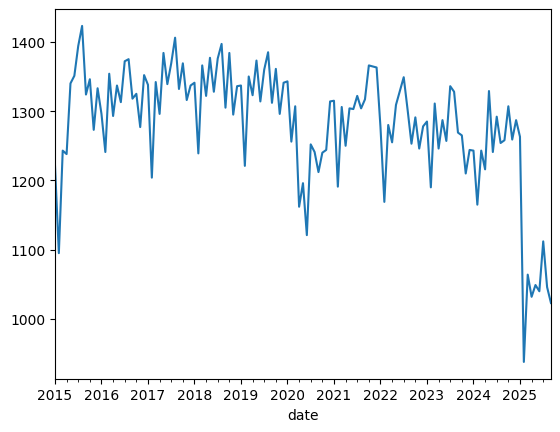

In [130]:
#How many water samples were taken each day across all sites
df_dist["date"].dt.to_period("M").value_counts().sort_index().plot()

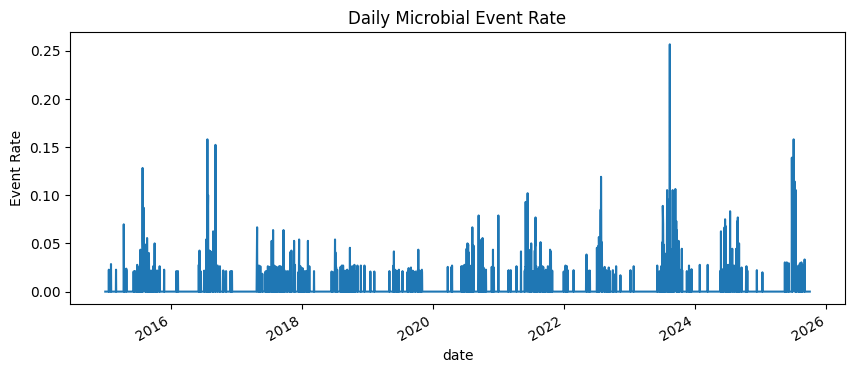

In [131]:
daily_event_rate = (
    df_dist
    .groupby("date")["micro_event_sample"]
    .mean()    # because 0/1 => mean = proportion positive
    .sort_index()
)

daily_event_rate.plot(figsize=(10,4))
plt.title("Daily Microbial Event Rate")
plt.ylabel("Event Rate")
plt.show()

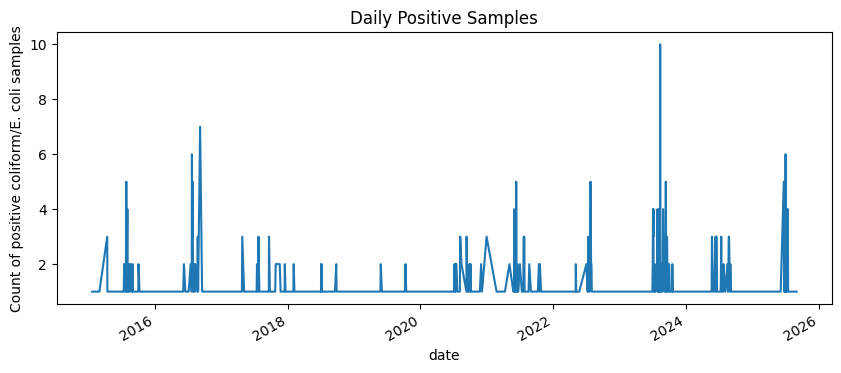

In [132]:
daily_pos = (
    df_dist[df_dist["micro_event_sample"] == 1]
    .groupby("date")
    .size()
)

daily_pos.plot(figsize=(10,4))
plt.title("Daily Positive Samples")
plt.ylabel("Count of positive coliform/E. coli samples")
plt.show()

In [133]:
#Make a datetime axis
dm = dist_monthly.copy()

# Convert year_month ("YYYY-MM") to a datetime - first of month (for histograms)
dm["year_month_dt"] = pd.to_datetime(dm["year_month"] + "-01")

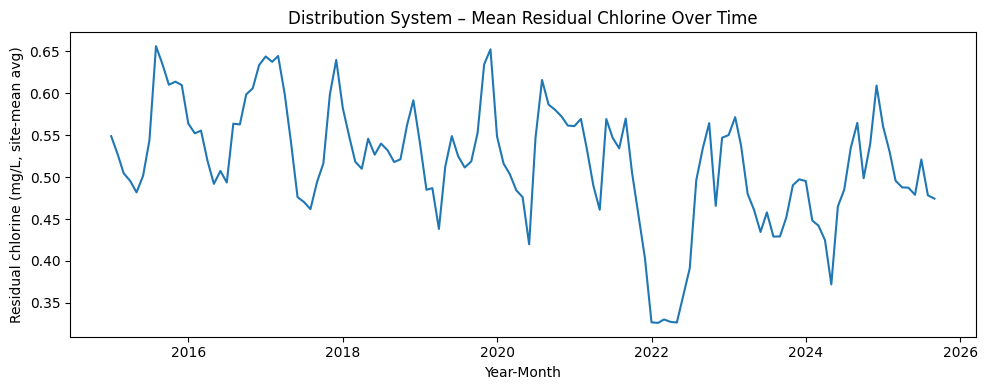

In [134]:
monthly_global = (
    dm
    .groupby("year_month_dt")["residual_chlorine_mean"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(10, 4))
plt.plot(monthly_global.index, monthly_global.values)
plt.xlabel("Year-Month")
plt.ylabel("Residual chlorine (mg/L, site-mean avg)")
plt.title("Distribution System – Mean Residual Chlorine Over Time")
plt.tight_layout()
plt.show()


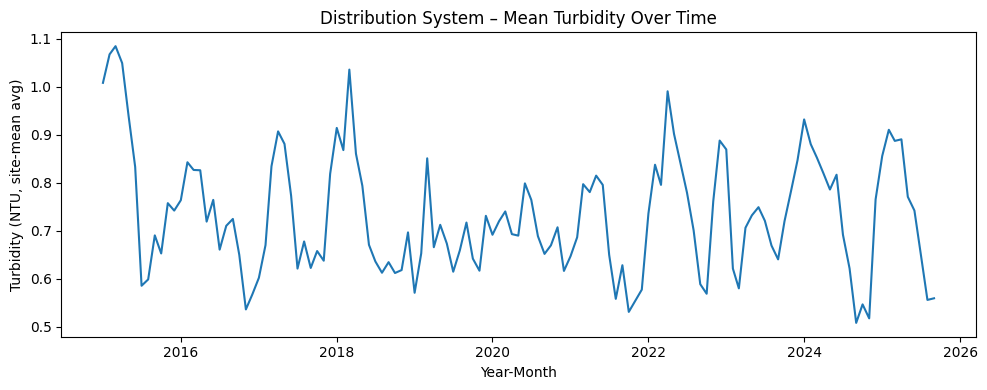

In [135]:
monthly_turb = (
    dm
    .groupby("year_month_dt")["turbidity_mean"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(10, 4))
plt.plot(monthly_turb.index, monthly_turb.values)
plt.xlabel("Year-Month")
plt.ylabel("Turbidity (NTU, site-mean avg)")
plt.title("Distribution System – Mean Turbidity Over Time")
plt.tight_layout()
plt.show()


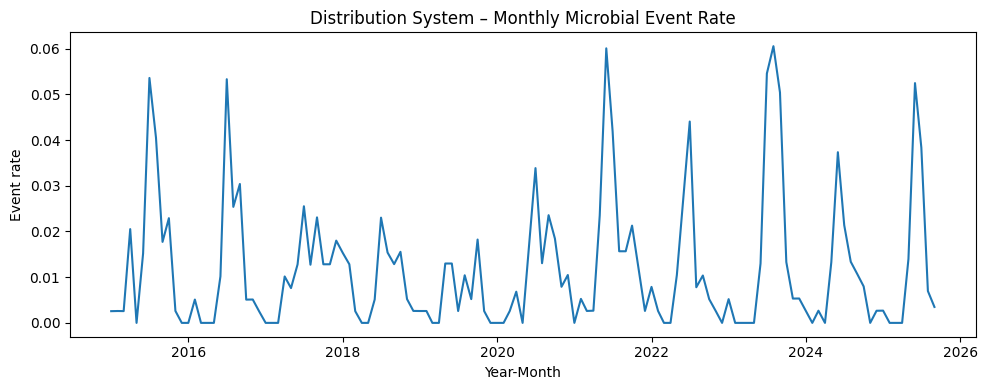

In [136]:
# Micro event rate per month (fraction of site×months with event)
monthly_event_rate = (
    dm
    .groupby("year_month_dt")["y"]
    .mean()  # because y is 0/1, mean = rate
    .sort_index()
)

plt.figure(figsize=(10, 4))
plt.plot(monthly_event_rate.index, monthly_event_rate.values)
plt.xlabel("Year-Month")
plt.ylabel("Event rate")
plt.title("Distribution System – Monthly Microbial Event Rate")
plt.tight_layout()
plt.show()


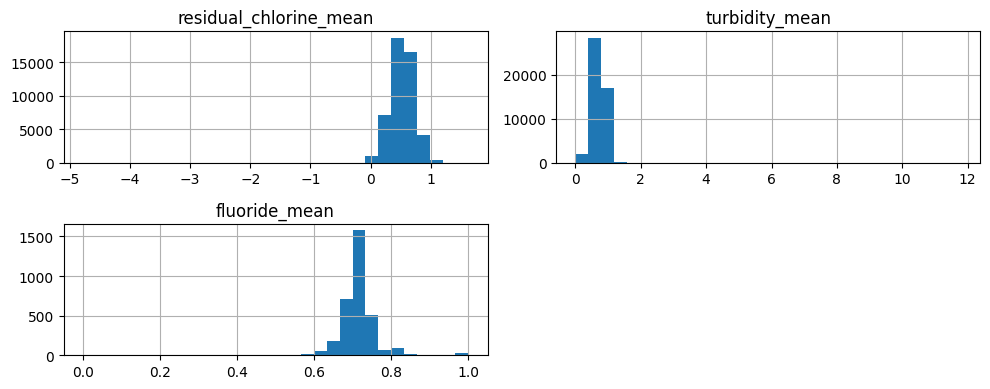

In [137]:
feature_cols_dist = ["residual_chlorine_mean",
                     "turbidity_mean",
                     "fluoride_mean"]

dm[feature_cols_dist].hist(bins=30, figsize=(10, 4))
plt.tight_layout()
plt.show()

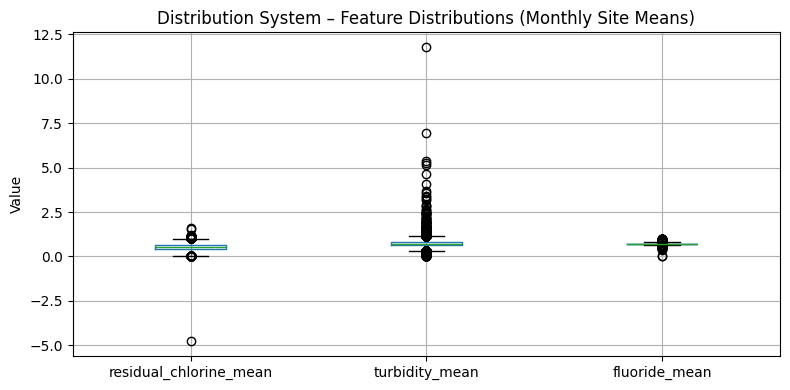

In [138]:
plt.figure(figsize=(8, 4))
dm[feature_cols_dist].boxplot()
plt.ylabel("Value")
plt.title("Distribution System – Feature Distributions (Monthly Site Means)")
plt.tight_layout()
plt.show()

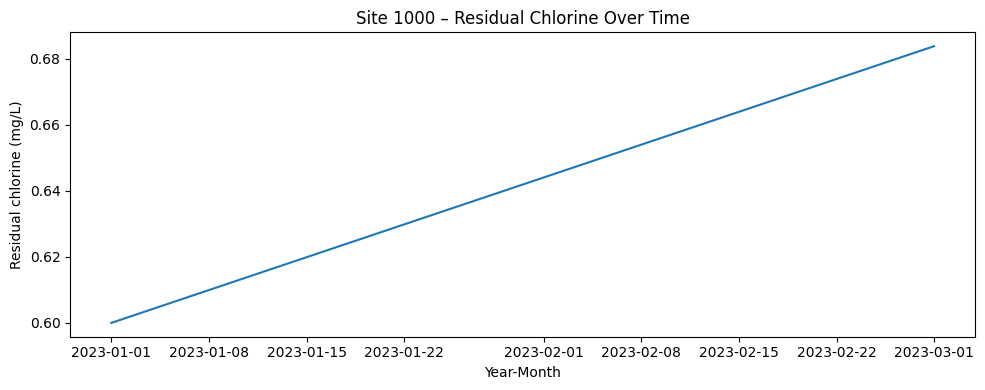

In [139]:
site_id = "1000"

site_df = dm[dm["site"] == site_id].copy()
site_df = site_df.sort_values("year_month_dt")

plt.figure(figsize=(10, 4))
plt.plot(site_df["year_month_dt"], site_df["residual_chlorine_mean"])
plt.xlabel("Year-Month")
plt.ylabel("Residual chlorine (mg/L)")
plt.title(f"Site {site_id} – Residual Chlorine Over Time")
plt.tight_layout()
plt.show()


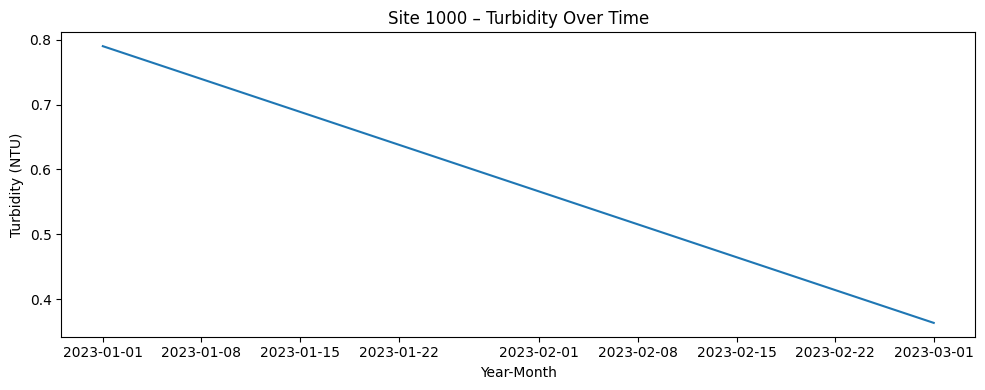

In [140]:
plt.figure(figsize=(10, 4))
plt.plot(site_df["year_month_dt"], site_df["turbidity_mean"])
plt.xlabel("Year-Month")
plt.ylabel("Turbidity (NTU)")
plt.title(f"Site {site_id} – Turbidity Over Time")
plt.tight_layout()
plt.show()


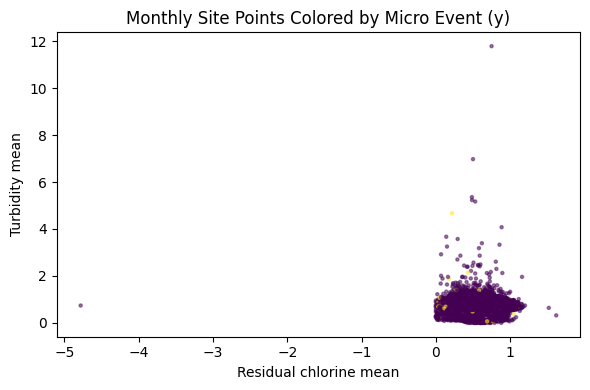

In [141]:
plt.figure(figsize=(6, 4))
plt.scatter(dm["residual_chlorine_mean"], dm["turbidity_mean"],
            s=5, alpha=0.5, c=dm["y"])
plt.xlabel("Residual chlorine mean")
plt.ylabel("Turbidity mean")
plt.title("Monthly Site Points Colored by Micro Event (y)")
plt.tight_layout()
plt.show()

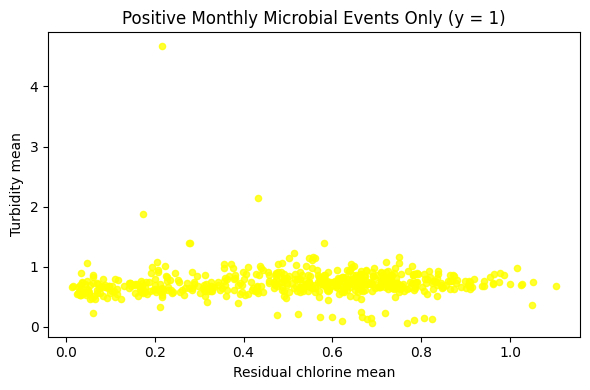

In [142]:
# Filter to only positive microbial events
dm_pos = dm[dm["y"] == 1]

plt.figure(figsize=(6, 4))
plt.scatter(
    dm_pos["residual_chlorine_mean"],
    dm_pos["turbidity_mean"],
    s=20,
    alpha=0.8,
    color="yellow"  # or any color you like
)
plt.xlabel("Residual chlorine mean")
plt.ylabel("Turbidity mean")
plt.title("Positive Monthly Microbial Events Only (y = 1)")
plt.tight_layout()
plt.show()


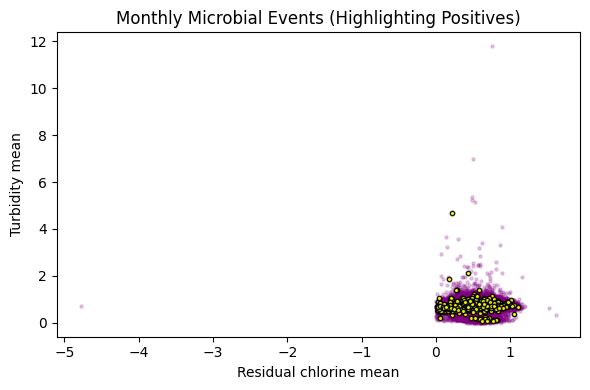

In [143]:
plt.figure(figsize=(6, 4))

# Background: all months
plt.scatter(dm["residual_chlorine_mean"], dm["turbidity_mean"],
            s=5, alpha=0.2, color="purple")

# Foreground: positives only
plt.scatter(dm_pos["residual_chlorine_mean"], dm_pos["turbidity_mean"],
            s=10, alpha=0.9, color="yellow", edgecolors="black")

plt.xlabel("Residual chlorine mean")
plt.ylabel("Turbidity mean")
plt.title("Monthly Microbial Events (Highlighting Positives)")
plt.tight_layout()
plt.show()

####Model Training

In [144]:
def run_unified_cv(
    df,
    feature_cols,
    label_col="y",
    name="Model",
    n_splits=5,
    random_state=42,
):
    """
    Runs StratifiedKFold cross-validation with:
    - RandomForestClassifier
    - Dummy classifier (majority class baseline)
    and prints ROC AUC and PR AUC.
    """
    # Drop rows where label or all features are missing
    use_df = df.dropna(subset=[label_col] + feature_cols, how="any").copy()

    X = use_df[feature_cols].values
    y = use_df[label_col].astype(int).values

    print(f"\n=== {name} ===")
    print(f"Data shape: {use_df.shape}")
    print(f"Positive rate (prevalence): {y.mean():.6f}")

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=1,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=random_state,
    )

    aucs_rf, prs_rf = [], []
    aucs_dummy, prs_dummy = [], []

    fold = 0
    for train_idx, test_idx in skf.split(X, y):
        fold += 1
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        # Dummy baseline (always predict majority class of train set)
        dummy = DummyClassifier(strategy="most_frequent")
        dummy.fit(X_tr, y_tr)
        y_dummy_proba = dummy.predict_proba(X_te)[:, 1]

        auc_dummy = roc_auc_score(y_te, y_dummy_proba)
        pr_dummy = average_precision_score(y_te, y_dummy_proba)
        aucs_dummy.append(auc_dummy)
        prs_dummy.append(pr_dummy)

        # --- RandomForest model ---
        rf.fit(X_tr, y_tr)
        y_rf_proba = rf.predict_proba(X_te)[:, 1]

        auc_rf = roc_auc_score(y_te, y_rf_proba)
        pr_rf = average_precision_score(y_te, y_rf_proba)
        aucs_rf.append(auc_rf)
        prs_rf.append(pr_rf)

        print(
            f"Fold {fold}: "
            f"RF AUC={auc_rf:.3f}, PR={pr_rf:.5f}  |  "
            f"Dummy AUC={auc_dummy:.3f}, PR={pr_dummy:.5f}"
        )

    print("\n--- Cross-validated performance ---")
    print(f"RF  ROC AUC: {np.mean(aucs_rf):.3f} ± {np.std(aucs_rf):.3f}")
    print(f"RF  PR  AUC: {np.mean(prs_rf):.5f} ± {np.std(prs_rf):.5f}")
    print(f"Dum ROC AUC: {np.mean(aucs_dummy):.3f} ± {np.std(aucs_dummy):.3f}")
    print(f"Dum PR  AUC: {np.mean(prs_dummy):.5f} ± {np.std(prs_dummy):.5f}")

    return {
        "rf_auc_mean": float(np.mean(aucs_rf)),
        "rf_pr_mean": float(np.mean(prs_rf)),
        "dummy_auc_mean": float(np.mean(aucs_dummy)),
        "dummy_pr_mean": float(np.mean(prs_dummy)),
        "prevalence": float(y.mean()),
    }

In [152]:
summary_1a = run_unified_cv(
    df=dm,
    feature_cols=feature_cols_dist,
    label_col="y",
    name="1A – NYC Distribution (microbial events)",
    n_splits=5,
)
print("\nSummary 1A:", summary_1a)


=== 1A – NYC Distribution (microbial events) ===
Data shape: (3280, 20)
Positive rate (prevalence): 0.035366
Fold 1: RF AUC=0.763, PR=0.10776  |  Dummy AUC=0.500, PR=0.03506
Fold 2: RF AUC=0.712, PR=0.07599  |  Dummy AUC=0.500, PR=0.03506
Fold 3: RF AUC=0.735, PR=0.07296  |  Dummy AUC=0.500, PR=0.03506
Fold 4: RF AUC=0.746, PR=0.07475  |  Dummy AUC=0.500, PR=0.03506
Fold 5: RF AUC=0.725, PR=0.06744  |  Dummy AUC=0.500, PR=0.03659

--- Cross-validated performance ---
RF  ROC AUC: 0.736 ± 0.017
RF  PR  AUC: 0.07978 ± 0.01429
Dum ROC AUC: 0.500 ± 0.000
Dum PR  AUC: 0.03537 ± 0.00061

Summary 1A: {'rf_auc_mean': 0.73597400847577, 'rf_pr_mean': 0.07977760965102174, 'dummy_auc_mean': 0.5, 'dummy_pr_mean': 0.03536585365853659, 'prevalence': 0.03536585365853658}


In [153]:
results_table = pd.DataFrame(
    {
        "Metric": [
            "ROC AUC",
            "PR AUC",
            "Positive class prevalence",
        ],
        "Random Forest": [
            summary_1a["rf_auc_mean"],
            summary_1a["rf_pr_mean"],
            summary_1a["prevalence"],
        ],
        "Dummy baseline": [
            summary_1a["dummy_auc_mean"],
            summary_1a["dummy_pr_mean"],
            None,
        ],
    }
)

# Nice rounding for display
results_table_rounded = results_table.copy()
results_table_rounded[["Random Forest", "Dummy baseline"]] = (
    results_table_rounded[["Random Forest", "Dummy baseline"]]
    .applymap(lambda x: None if x is None else round(x, 3))
)

results_table_rounded


/tmp/ipython-input-2070207442.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: None if x is None else round(x, 3))


Metric  Random Forest  Dummy baseline
0                    ROC AUC          0.736           0.500
1                     PR AUC          0.080           0.035
2  Positive class prevalence          0.035             NaN

In [154]:
results_table.to_csv(EXPORT_DIR / "model1_training_results_table.csv", index=False)

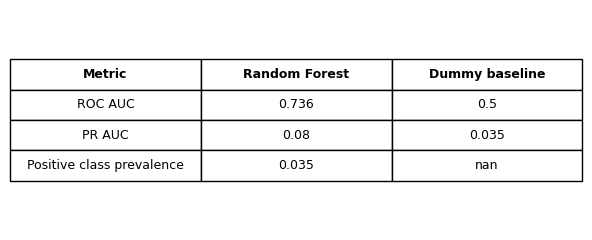

In [155]:
fig, ax = plt.subplots(figsize=(6, 2.5))  # tweak size as you like
ax.axis("off")

# Use the rounded values for nice formatting
table_data = [results_table_rounded.columns.tolist()] + results_table_rounded.values.tolist()

table = ax.table(
    cellText=table_data,
    loc="center",
    cellLoc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.6)  # make cells bigger / taller

# Optional: bold header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")

fig.tight_layout()
fig.savefig(EXPORT_DIR / "model1_training_results_table.png", dpi=300, bbox_inches="tight")
plt.show()


####Exports

Export dir: framework1_model1_exports


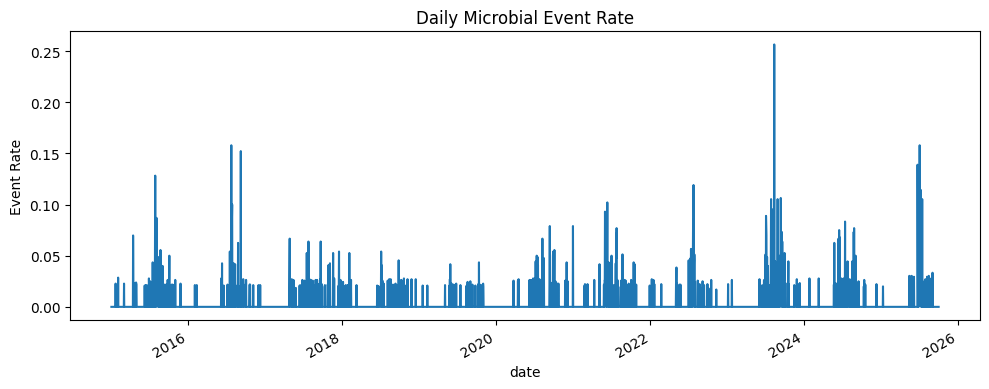

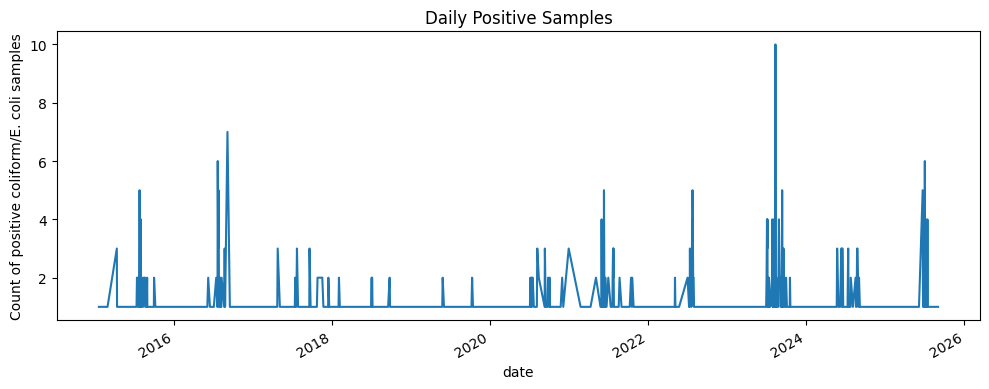

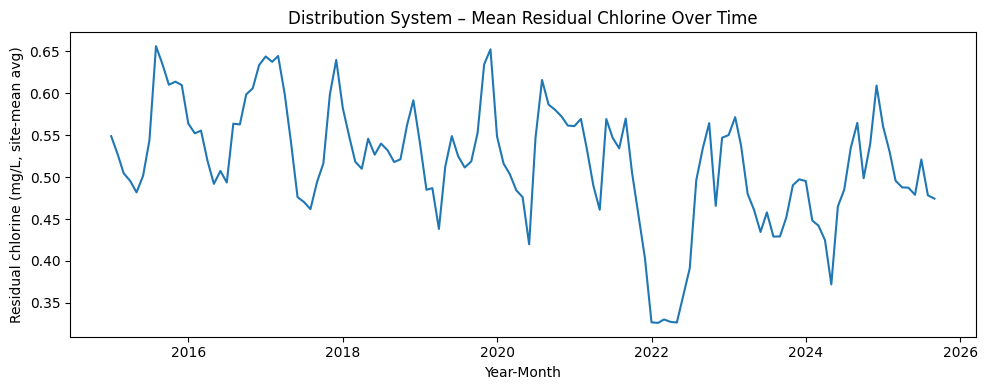

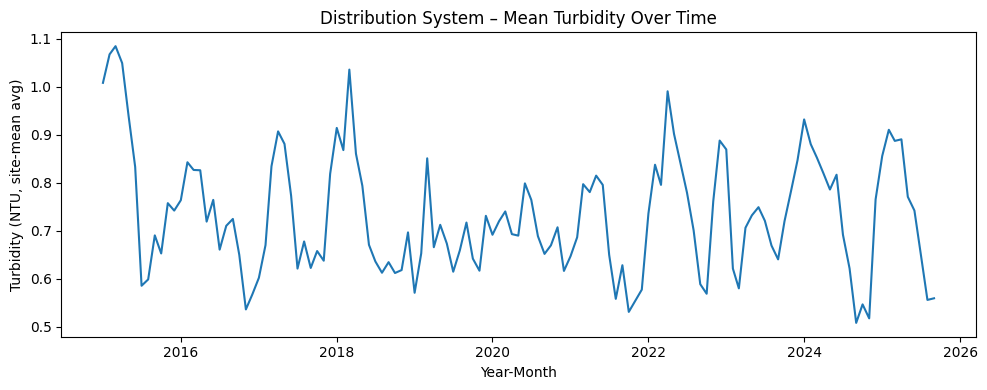

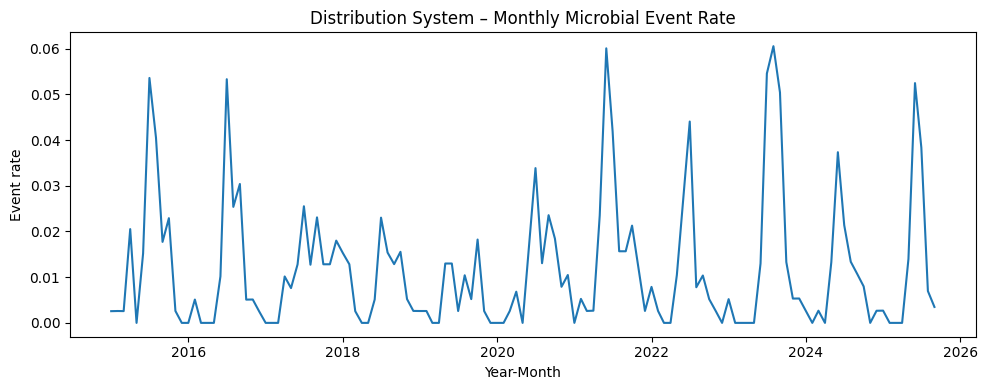

Feature columns found in dm: ['residual_chlorine_mean', 'turbidity_mean', 'fluoride_mean']


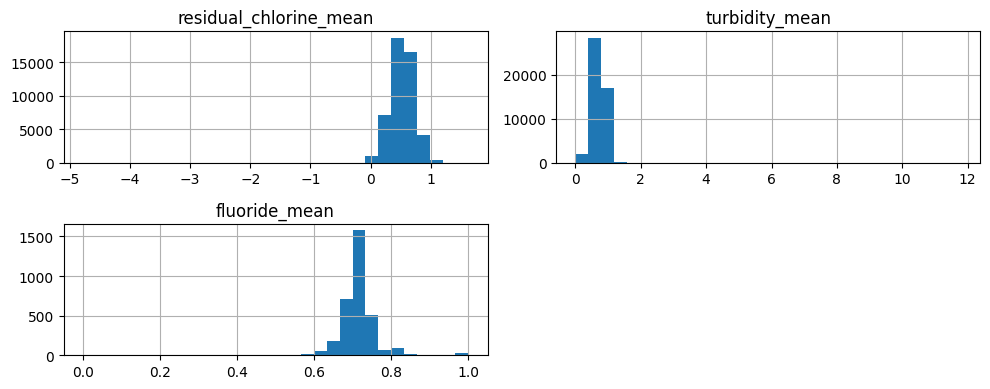

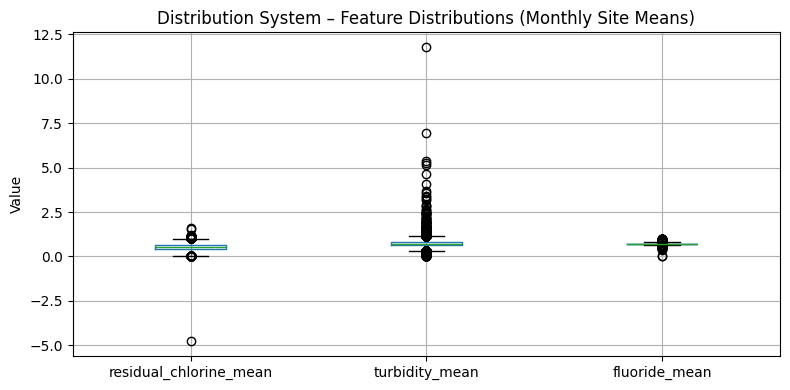

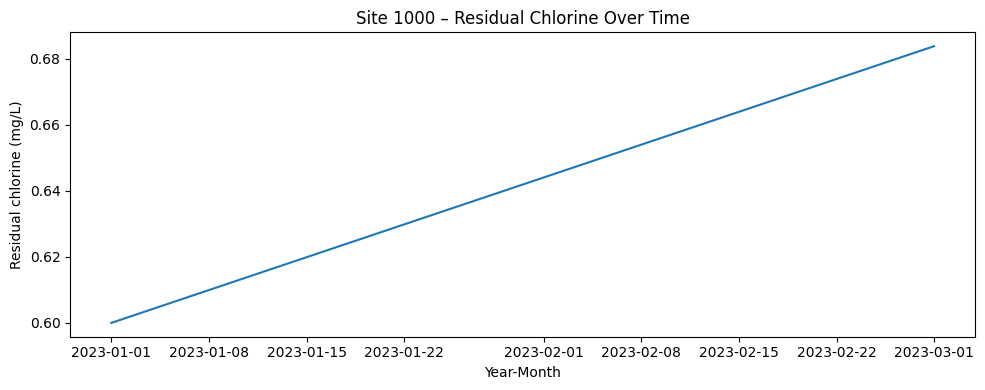

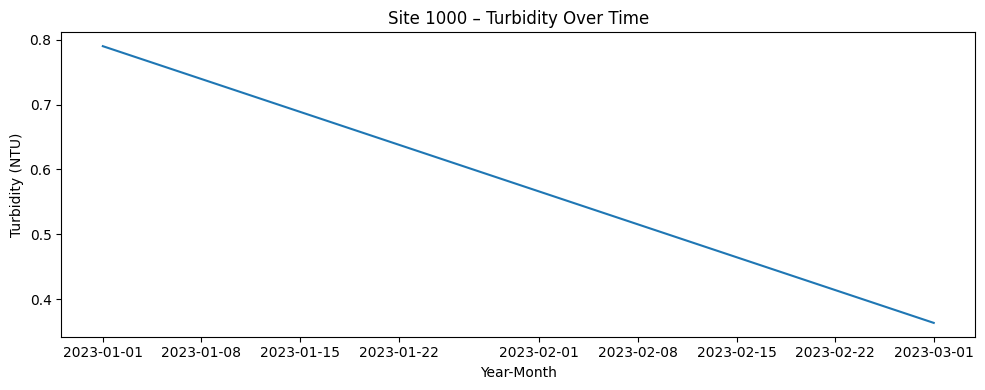

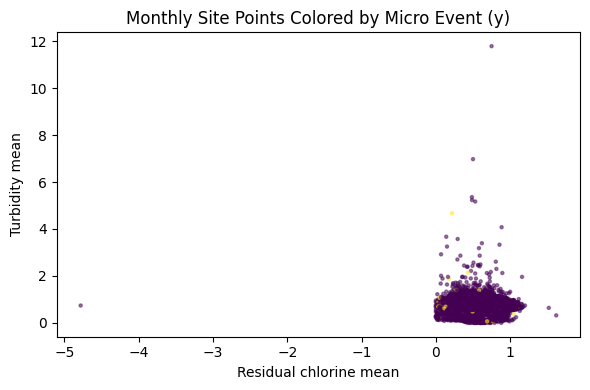

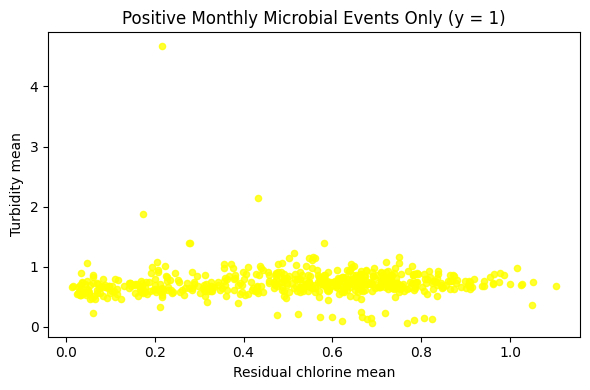

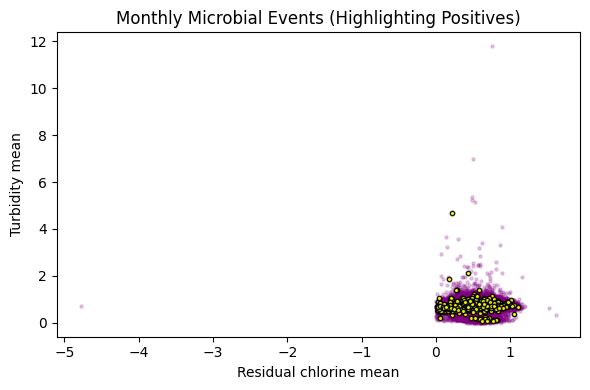

/tmp/ipython-input-3544303524.py:225: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: None if x is None else round(x, 3))


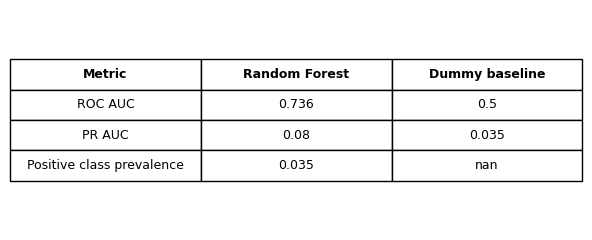

Created zip: framework1_model1_bundle.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [168]:
from google.colab import files  # <-- this is the files you want


# ===== 2. Export directory =====
EXPORT_DIR = Path("framework1_model1_exports")
EXPORT_DIR.mkdir(exist_ok=True)
print("Export dir:", EXPORT_DIR)


# ===== 3. Recompute key series for plots (in case not in scope) =====

# Daily label
df_dist["micro_event_sample"] = (
    (df_dist["total_coliform"] > 0) |
    (df_dist["e_coli"] > 0)
).astype(int)

daily_event_rate = (
    df_dist
    .groupby("date")["micro_event_sample"]
    .mean()
    .sort_index()
)

daily_pos = (
    df_dist[df_dist["micro_event_sample"] == 1]
    .groupby("date")
    .size()
)

# Monthly aggregates
dm = dist_monthly.copy()
dm["year_month_dt"] = pd.to_datetime(dm["year_month"] + "-01")

monthly_global = (
    dm
    .groupby("year_month_dt")["residual_chlorine_mean"]
    .mean()
    .sort_index()
)

monthly_turb = (
    dm
    .groupby("year_month_dt")["turbidity_mean"]
    .mean()
    .sort_index()
)

monthly_event_rate = (
    dm
    .groupby("year_month_dt")["y"]
    .mean()
    .sort_index()
)

# For scatter plots
dm_pos = dm[dm["y"] == 1].copy()

# Example site
site_id = "1000"
site_df = (
    dm[dm["site"] == site_id]
    .copy()
    .sort_values("year_month_dt")
)


# ===== 4. Save PNGs =====

# 4.1 Daily event rate
plt.figure(figsize=(10, 4))
daily_event_rate.plot()
plt.title("Daily Microbial Event Rate")
plt.ylabel("Event Rate")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "daily_microbial_event_rate.png", dpi=300)
plt.show()

# 4.2 Daily positive samples
plt.figure(figsize=(10, 4))
daily_pos.plot()
plt.title("Daily Positive Samples")
plt.ylabel("Count of positive coliform/E. coli samples")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "daily_positive_samples.png", dpi=300)
plt.show()

# 4.3 Monthly residual chlorine
plt.figure(figsize=(10, 4))
plt.plot(monthly_global.index, monthly_global.values)
plt.xlabel("Year-Month")
plt.ylabel("Residual chlorine (mg/L, site-mean avg)")
plt.title("Distribution System – Mean Residual Chlorine Over Time")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "monthly_mean_residual_chlorine.png", dpi=300)
plt.show()

# 4.4 Monthly turbidity
plt.figure(figsize=(10, 4))
plt.plot(monthly_turb.index, monthly_turb.values)
plt.xlabel("Year-Month")
plt.ylabel("Turbidity (NTU, site-mean avg)")
plt.title("Distribution System – Mean Turbidity Over Time")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "monthly_mean_turbidity.png", dpi=300)
plt.show()

# 4.5 Monthly microbial event rate
plt.figure(figsize=(10, 4))
plt.plot(monthly_event_rate.index, monthly_event_rate.values)
plt.xlabel("Year-Month")
plt.ylabel("Event rate")
plt.title("Distribution System – Monthly Microbial Event Rate")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "monthly_microbial_event_rate.png", dpi=300)
plt.show()

# 4.6 Feature histograms / boxplots (if columns exist)
feature_cols_dist = ["residual_chlorine_mean", "turbidity_mean", "fluoride_mean"]
cols_present = [c for c in feature_cols_dist if c in dm.columns]
print("Feature columns found in dm:", cols_present)

if cols_present:
    dm[cols_present].hist(bins=30, figsize=(10, 4))
    plt.tight_layout()
    plt.savefig(EXPORT_DIR / "feature_histograms.png", dpi=300)
    plt.show()

    plt.figure(figsize=(8, 4))
    dm[cols_present].boxplot()
    plt.ylabel("Value")
    plt.title("Distribution System – Feature Distributions (Monthly Site Means)")
    plt.tight_layout()
    plt.savefig(EXPORT_DIR / "feature_boxplot.png", dpi=300)
    plt.show()

# 4.7 Site-level time series
plt.figure(figsize=(10, 4))
plt.plot(site_df["year_month_dt"], site_df["residual_chlorine_mean"])
plt.xlabel("Year-Month")
plt.ylabel("Residual chlorine (mg/L)")
plt.title(f"Site {site_id} – Residual Chlorine Over Time")
plt.tight_layout()
plt.savefig(EXPORT_DIR / f"site_{site_id}_residual_chlorine.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(site_df["year_month_dt"], site_df["turbidity_mean"])
plt.xlabel("Year-Month")
plt.ylabel("Turbidity (NTU)")
plt.title(f"Site {site_id} – Turbidity Over Time")
plt.tight_layout()
plt.savefig(EXPORT_DIR / f"site_{site_id}_turbidity.png", dpi=300)
plt.show()

# 4.8 Scatter plots
plt.figure(figsize=(6, 4))
plt.scatter(dm["residual_chlorine_mean"], dm["turbidity_mean"],
            s=5, alpha=0.5, c=dm["y"])
plt.xlabel("Residual chlorine mean")
plt.ylabel("Turbidity mean")
plt.title("Monthly Site Points Colored by Micro Event (y)")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "scatter_all_points_colored_by_y.png", dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(
    dm_pos["residual_chlorine_mean"],
    dm_pos["turbidity_mean"],
    s=20,
    alpha=0.8,
    color="yellow"
)
plt.xlabel("Residual chlorine mean")
plt.ylabel("Turbidity mean")
plt.title("Positive Monthly Microbial Events Only (y = 1)")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "scatter_positive_events_only.png", dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(dm["residual_chlorine_mean"], dm["turbidity_mean"],
            s=5, alpha=0.2, color="purple")
plt.scatter(dm_pos["residual_chlorine_mean"], dm_pos["turbidity_mean"],
            s=10, alpha=0.9, color="yellow", edgecolors="black")
plt.xlabel("Residual chlorine mean")
plt.ylabel("Turbidity mean")
plt.title("Monthly Microbial Events (Highlighting Positives)")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "scatter_highlight_positives.png", dpi=300)
plt.show()


# ===== 5. Training results: CSV + pretty PNG table + JSON =====

# summary_1a should already exist from run_unified_cv(...)
results_df = pd.DataFrame([summary_1a])
results_df.to_csv(EXPORT_DIR / "model1_training_results_raw.csv", index=False)

# Table-style CSV (for human reading)
results_table = pd.DataFrame(
    {
        "Metric": [
            "ROC AUC",
            "PR AUC",
            "Positive class prevalence",
        ],
        "Random Forest": [
            summary_1a["rf_auc_mean"],
            summary_1a["rf_pr_mean"],
            summary_1a["prevalence"],
        ],
        "Dummy baseline": [
            summary_1a["dummy_auc_mean"],
            summary_1a["dummy_pr_mean"],
            None,
        ],
    }
)

results_table_rounded = results_table.copy()
results_table_rounded[["Random Forest", "Dummy baseline"]] = (
    results_table_rounded[["Random Forest", "Dummy baseline"]]
    .applymap(lambda x: None if x is None else round(x, 3))
)

results_table_rounded.to_csv(
    EXPORT_DIR / "model1_training_results_table.csv",
    index=False
)

# PNG table
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis("off")
table_data = [results_table_rounded.columns.tolist()] + results_table_rounded.values.tolist()
table = ax.table(
    cellText=table_data,
    loc="center",
    cellLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.6)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")

fig.tight_layout()
fig.savefig(EXPORT_DIR / "model1_training_results_table.png", dpi=300, bbox_inches="tight")
plt.show()

# JSON of training summary
with open(EXPORT_DIR / "model1_training_results.json", "w") as f:
    json.dump(summary_1a, f, indent=2)


# ===== 6. Graph data JSON (for recreating plots, not images) =====

graphs_json = {}

graphs_json["daily_event_rate"] = {
    "date": daily_event_rate.index.astype(str).tolist(),
    "event_rate": daily_event_rate.values.tolist(),
    "title": "Daily Microbial Event Rate",
    "y_label": "Event Rate",
}

graphs_json["daily_positive_samples"] = {
    "date": daily_pos.index.astype(str).tolist(),
    "count_positive": daily_pos.values.tolist(),
    "title": "Daily Positive Samples",
    "y_label": "Count of positive coliform/E. coli samples",
}

graphs_json["monthly_residual_chlorine"] = {
    "year_month": monthly_global.index.astype(str).tolist(),
    "residual_chlorine_mean": monthly_global.values.tolist(),
    "title": "Distribution System – Mean Residual Chlorine Over Time",
    "y_label": "Residual chlorine (mg/L, site-mean avg)",
}

graphs_json["monthly_turbidity"] = {
    "year_month": monthly_turb.index.astype(str).tolist(),
    "turbidity_mean": monthly_turb.values.tolist(),
    "title": "Distribution System – Mean Turbidity Over Time",
    "y_label": "Turbidity (NTU)",
}

graphs_json["monthly_micro_event_rate"] = {
    "year_month": monthly_event_rate.index.astype(str).tolist(),
    "event_rate": monthly_event_rate.values.tolist(),
    "title": "Distribution System – Monthly Microbial Event Rate",
    "y_label": "Event rate",
}

with open(EXPORT_DIR / "framework1_model1_graph_data.json", "w") as f:
    json.dump(graphs_json, f, indent=2)


# ===== 7. Create ZIP (⚠️ don't shadow `files`) =====

zip_path = "framework1_model1_bundle.zip"

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, filenames in os.walk(EXPORT_DIR):  # <- use `filenames`, not `files`
        for fname in filenames:
            full_path = Path(root) / fname
            # store paths inside the zip relative to EXPORT_DIR
            rel_path = full_path.relative_to(EXPORT_DIR)
            zf.write(full_path, arcname=rel_path)

print("Created zip:", zip_path)

# ===== 8. Download ZIP (now `files` is the google.colab module) =====
files.download(zip_path)

###Model 2

####Load Dataset

In [169]:
#WQP
wqp_phys_path  = DATA_ROOT / "WQP_NY_Surface_PhysChem" / "WQP_NY_Surface_PhysChem.csv"
wqp_bio_path   = DATA_ROOT / "WQP_NY_Surface_Bio"      / "WQP_NY_Surface_Bio.csv"
wqp_sites_path = DATA_ROOT / "WQP_NY_Surface_Sites"    / "WQP_NY_Surface_Sites.csv"

wqp_phys  = pd.read_csv(wqp_phys_path,  low_memory=False)
wqp_bio   = pd.read_csv(wqp_bio_path,   low_memory=False)
wqp_sites = pd.read_csv(wqp_sites_path, low_memory=False)

SITE_COL = "MonitoringLocationIdentifier"   # typical WQP column
CHAR_COL = "CharacteristicName"
VALUE_COL = "ResultMeasureValue"
DATE_COL = "ActivityStartDate"
for df in [wqp_phys, wqp_bio]:
    df["sample_date"] = pd.to_datetime(df[DATE_COL])
    df["month"] = df["sample_date"].dt.to_period("M")

site_meta_cols = [
    SITE_COL,
    "MonitoringLocationName",
    "MonitoringLocationTypeName",
]
site_meta_cols = [c for c in site_meta_cols if c in wqp_sites.columns]

wqp_sites_small = (
    wqp_sites[site_meta_cols]
    .drop_duplicates(subset=[SITE_COL])
    .rename(columns={
        "MonitoringLocationName": "site_name",
        "MonitoringLocationTypeName": "site_type",
    })
)

print("WQP site metadata shape:", wqp_sites_small.shape)
wqp_sites_small.head()


WQP site metadata shape: (8485, 3)


MonitoringLocationIdentifier  \
0                USGS-01376790   
1                USGS-01299000   
2                USGS-01299200   
3                USGS-01301500   
4                USGS-01301900   

                                           site_name  \
0                  HACKENSACK R DIV AT WEST NYACK NY   
1                       BLIND BROOK NEAR PURCHASE NY   
2  UNNAMED TRIBUTARY AT LINCOLN AVE NEAR PURCHASE NY   
3                      HUTCHINSON RIVER AT PELHAM NY   
4                   KENSICO RESERVOIR AT VALHALLA NY   

                      site_type  
0           Facility: Diversion  
1                        Stream  
2                        Stream  
3                        Stream  
4  Lake, Reservoir, Impoundment

In [170]:
PHYS_VARS = {
    "temp_C":          ["Temperature, water", "Water temperature"],
    "turbidity_ntu":   ["Turbidity"],
    "ph":              ["pH"],
    "cond_uscm":       ["Specific conductance", "Specific conductance, unfiltered"],
    "nitrate_mgL":     ["Nitrate", "Nitrate-nitrogen", "Nitrite plus nitrate"],
    "phosphorus_mgL":  ["Phosphorus", "Orthophosphate", "Phosphate"],
}

BIO_VARS = {
    "fecal_coliform_cfu": ["Fecal coliform", "Fecal coliform, water"],
    "enterococcus_cfu":   ["Enterococcus", "Enterococci", "Enterococci (fecal)"],
}

def _invert_map(char_map):
    inv = {}
    for canonical, names in char_map.items():
        for n in names:
            inv[n] = canonical
    return inv

PHYS_INV = _invert_map(PHYS_VARS)
BIO_INV  = _invert_map(BIO_VARS)

# --- Monthly physchem: site × month means ---

def build_monthly_physchem(df, site_col=SITE_COL, char_col=CHAR_COL, value_col=VALUE_COL):
    mask = df[char_col].isin(PHYS_INV.keys())
    sub = df.loc[mask, [site_col, "month", char_col, value_col]].copy()
    sub[value_col] = pd.to_numeric(sub[value_col], errors="coerce")

    sub["var"] = sub[char_col].map(PHYS_INV)

    agg = (
        sub.groupby([site_col, "month", "var"])[value_col]
        .mean()
        .reset_index()
    )

    # Pivot means to wide format
    wide = agg.pivot(index=[site_col, "month"], columns="var", values=value_col)
    wide.columns = [f"{c}_mean" for c in wide.columns]
    return wide.reset_index()

wqp_phys_monthly = build_monthly_physchem(wqp_phys)
print("WQP physchem monthly shape:", wqp_phys_monthly.shape)
wqp_phys_monthly.head()

WQP physchem monthly shape: (47407, 8)


MonitoringLocationIdentifier    month  cond_uscm_mean  nitrate_mgL_mean  \
0          1083919_WQX-BR-GS-1  2017-06             NaN               NaN   
1          1083919_WQX-BR-GS-1  2017-10             NaN               NaN   
2          1083919_WQX-BxR-009  2017-05             NaN               NaN   
3           1083919_WQX-SWS-01  2017-05             NaN               NaN   
4           1083919_WQX-SWS-02  2017-06             NaN               NaN   

   ph_mean  phosphorus_mgL_mean  temp_C_mean  turbidity_ntu_mean  
0     8.09                  NaN         27.0                 NaN  
1     7.13                  NaN         12.8                 NaN  
2     5.50                  NaN         26.0                 NaN  
3     5.00                  NaN         25.0                 NaN  
4     8.00                  NaN         24.0                 NaN

In [171]:
def build_monthly_bio_labels(df,
                             site_col=SITE_COL,
                             char_col=CHAR_COL,
                             value_col=VALUE_COL,
                             fecal_thresh=200.0,   # CFU/100 mL
                             ent_thresh=104.0):   # CFU/100 mL

    """
    Build a site×month table with fecal_coliform_cfu, enterococcus_cfu and binary event labels.
    """
    mask = df[char_col].isin(BIO_INV.keys())
    sub = df.loc[mask, [site_col, "month", char_col, value_col]].copy()
    sub[value_col] = pd.to_numeric(sub[value_col], errors="coerce")

    sub["var"] = sub[char_col].map(BIO_INV)


    # Use monthly max per site×month as contamination indicator
    agg = (
        sub.groupby([site_col, "month", "var"])[value_col]
        .max()
        .reset_index()
    )

    pivot = agg.pivot(index=[site_col, "month"], columns="var", values=value_col)

    pivot.columns.name = None

    target_cols = ["fecal_coliform_cfu", "enterococcus_cfu"]
    pivot = pivot.reindex(columns=target_cols, fill_value=np.nan)

    pivot = pivot.reset_index()

    pivot["fecal_event"] = (pivot["fecal_coliform_cfu"] >= fecal_thresh).astype(int)
    pivot["ent_event"]   = (pivot["enterococcus_cfu"]   >= ent_thresh).astype(int)

    pivot["y_surface"] = ((pivot["fecal_event"] == 1) | (pivot["ent_event"] == 1)).astype(int)

    return pivot

wqp_bio_monthly = build_monthly_bio_labels(wqp_bio)
print("WQP bio monthly shape:", wqp_bio_monthly.shape)
wqp_bio_monthly.head()


WQP bio monthly shape: (28468, 7)


MonitoringLocationIdentifier    month  fecal_coliform_cfu  enterococcus_cfu  \
0            1083919_WQX-26.1W  2017-06                 NaN              63.0   
1            1083919_WQX-26.1W  2017-07                 NaN             199.0   
2            1083919_WQX-26.1W  2017-08                 NaN             609.0   
3            1083919_WQX-26.1W  2017-09                 NaN              75.0   
4            1083919_WQX-26.1W  2017-10                 NaN             209.0   

   fecal_event  ent_event  y_surface  
0            0          0          0  
1            0          1          1  
2            0          1          1  
3            0          0          0  
4            0          1          1

In [172]:
#Merge PhysChem and Bio on SitexMonth
wqp_surface_monthly = (
    wqp_bio_monthly
    .merge(
        wqp_phys_monthly,
        on=[SITE_COL, "month"],
        how="left"
    )
)

print("WQP surface (bio + physchem) monthly:", wqp_surface_monthly.shape)
wqp_surface_monthly.head()

WQP surface (bio + physchem) monthly: (28468, 13)


MonitoringLocationIdentifier    month  fecal_coliform_cfu  enterococcus_cfu  \
0            1083919_WQX-26.1W  2017-06                 NaN              63.0   
1            1083919_WQX-26.1W  2017-07                 NaN             199.0   
2            1083919_WQX-26.1W  2017-08                 NaN             609.0   
3            1083919_WQX-26.1W  2017-09                 NaN              75.0   
4            1083919_WQX-26.1W  2017-10                 NaN             209.0   

   fecal_event  ent_event  y_surface  cond_uscm_mean  nitrate_mgL_mean  \
0            0          0          0             NaN               NaN   
1            0          1          1             NaN               NaN   
2            0          1          1             NaN               NaN   
3            0          0          0             NaN               NaN   
4            0          1          1             NaN               NaN   

   ph_mean  phosphorus_mgL_mean  temp_C_mean  turbidity_ntu_mean  
0      NaN                  NaN          NaN                 NaN  
1      NaN                  NaN          NaN                 NaN  
2      NaN                  NaN          NaN                 NaN  
3      NaN                  NaN          NaN                 NaN  
4      NaN                  NaN          NaN                 NaN

In [173]:
#Add Site Metadata
wqp_surface_monthly = (
    wqp_surface_monthly
    .merge(
        wqp_sites_small,
        on=SITE_COL,
        how="left"
    )
)

# Convert Period("YYYY-MM") → Timestamp (month start)
wqp_surface_monthly["month_start"] = wqp_surface_monthly["month"].dt.to_timestamp()

# For clarity, add a domain tag
wqp_surface_monthly["domain"] = "WQP"

print("WQP surface monthly + site meta:", wqp_surface_monthly.shape)
wqp_surface_monthly.head()

WQP surface monthly + site meta: (28468, 17)


MonitoringLocationIdentifier    month  fecal_coliform_cfu  enterococcus_cfu  \
0            1083919_WQX-26.1W  2017-06                 NaN              63.0   
1            1083919_WQX-26.1W  2017-07                 NaN             199.0   
2            1083919_WQX-26.1W  2017-08                 NaN             609.0   
3            1083919_WQX-26.1W  2017-09                 NaN              75.0   
4            1083919_WQX-26.1W  2017-10                 NaN             209.0   

   fecal_event  ent_event  y_surface  cond_uscm_mean  nitrate_mgL_mean  \
0            0          0          0             NaN               NaN   
1            0          1          1             NaN               NaN   
2            0          1          1             NaN               NaN   
3            0          0          0             NaN               NaN   
4            0          1          1             NaN               NaN   

   ph_mean  phosphorus_mgL_mean  temp_C_mean  turbidity_ntu_mean  \
0      NaN                  NaN          NaN                 NaN   
1      NaN                  NaN          NaN                 NaN   
2      NaN                  NaN          NaN                 NaN   
3      NaN                  NaN          NaN                 NaN   
4      NaN                  NaN          NaN                 NaN   

       site_name     site_type month_start domain  
0  Piermont Pier  River/Stream  2017-06-01    WQP  
1  Piermont Pier  River/Stream  2017-07-01    WQP  
2  Piermont Pier  River/Stream  2017-08-01    WQP  
3  Piermont Pier  River/Stream  2017-09-01    WQP  
4  Piermont Pier  River/Stream  2017-10-01    WQP

In [174]:
#Join NYC_DEP_Harbor_WQ
harbor_path = DATA_ROOT / "NYC_DEP_Harbor_WQ" / "Harbor_Water_Quality.csv"
harbor_raw = pd.read_csv(harbor_path, low_memory=False)
print(harbor_raw.shape)
harbor_raw.head()

(95933, 95)


sampling_location              sample_date sample_time  \
0               BB2  2006-08-09T00:00:00.000     1:53 PM   
1               BB2  2006-09-12T00:00:00.000     1:10 PM   
2               BB4  2006-08-09T00:00:00.000     2:02 PM   
3               BB4  2006-09-12T00:00:00.000     1:17 PM   
4               E10  2006-10-23T00:00:00.000    10:46 AM   

  weather_condition_dry_or_wet top_sample_temperature_c  \
0                            D                    26.47   
1                            D                    21.88   
2                            D                    27.37   
3                            D                    21.51   
4                            D                    16.01   

  bottom_sample_temperature_c site_actual_depth_ft top_sample_depth_ft  \
0                       26.36                   11                   5   
1                       21.43                   16                   5   
2                       25.76                   17                   3   
3                       20.96                   23                   6   
4                       16.14                   98                   4   

  bottom_sample_depth_ft top_salinity_psu  ...  \
0                     11            24.46  ...   
1                     15            25.67  ...   
2                     15            24.38  ...   
3                     21            25.86  ...   
4                     94             25.9  ...   

  top_bottom_coliform_cells_100_ml top_pcb_plate_count_thous_ml  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   

  bottom_pcb_plate_count_thous_ml  top_total_organic_carbon_mg_l  \
0                             NaN                            NaN   
1                             NaN                            NaN   
2                             NaN                            NaN   
3                             NaN                            NaN   
4                             NaN                            NaN   

   duplicate_sample  top_sample_depth_ysi_ft top_coliform_log_no_ml  \
0               NaN                      NaN                    NaN   
1               NaN                      NaN                    NaN   
2               NaN                      NaN                    NaN   
3               NaN                      NaN                    NaN   
4               NaN                      NaN                    NaN   

  bottom_coliform_log_no_ml top_bacteria_per_c_c_1909  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   

   bottom_bacteria_per_c_c_1909  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  

[5 rows x 95 columns]

In [175]:
harbor_raw.columns.tolist()

['sampling_location',
 'sample_date',
 'sample_time',
 'weather_condition_dry_or_wet',
 'top_sample_temperature_c',
 'bottom_sample_temperature_c',
 'site_actual_depth_ft',
 'top_sample_depth_ft',
 'bottom_sample_depth_ft',
 'top_salinity_psu',
 'bottom_salinity_psu',
 'top_conductivity_s_m',
 'bottom_conductivity_s_m',
 'ctd_conductivity_temperature_depth_profiler_top_dissolved_oxygen_mg_l',
 'ctd_conductivity_temperature_depth_profiler_bottom_dissolved_oxygen_mg_l',
 'percentage_o2_saturation_top_sample',
 'percentage_o2_saturation_bottom_sample',
 'top_sigma_t_kg_m3',
 'bottom_sigma_t_kg_m3',
 'oxidation_reduction_potential_mv_top_sample',
 'oxidation_reduction_potential_mv_bottom_sample',
 'current_speed_knot',
 'current_direction_current_direction',
 'wind_speed_mph',
 'wind_direction_wind_direction',
 'sea_state',
 'winkler_method_top_dissolved_oxygen_mg_l',
 'winkler_method_bottom_dissolved_oxygen_mg_l',
 'secchi_depth_ft',
 'top_ph',
 'bottom_ph',
 'top_fecal_coliform_bacteria_

In [176]:
HARBOR_COLS = {
    # core IDs
    "site_id":     "sampling_location",
    "sample_date": "sample_date",

    # site meta
    "lat":       "lat",
    "lon":       "long",
    "site_type": "type",

    # physchem (surface / top)
    "temp_C":           "top_sample_temperature_c",
    "turbidity_ntu":    "top_turbidity_nephelometric_turbidity_units",
    "ph":               "top_ph",
    "cond_s_m":         "top_conductivity_s_m",
    "nitrate_mgL":      "top_nitrate_nitrite_mg_l",
    "phosphorus_mgL":   "top_ortho_phosphorus_mg_l",

    # microbiology
    "fecal_coliform_cfu": "top_fecal_coliform_bacteria_cells_100ml",
    "enterococcus_cfu":   "top_enterococci_bacteria_cells_100ml",

    #later
    # "total_coliform_cfu":   "top_total_coliform_cells_100_ml",
    # "combo_coliform_cfu":   "top_bottom_coliform_cells_100_ml",
}


In [177]:
def build_harbor_monthly(df,
                         colmap,
                         fecal_thresh=200.0,
                         ent_thresh=104.0):
    """
    Build a Harbor monthly table with the same feature + label names
    as the WQP monthly table.
    """

    rename_map = {v: k for k, v in colmap.items() if v in df.columns}
    df = df.rename(columns=rename_map)

    # Derive conductivity in µS/cm if we have S/m
    if "cond_s_m" in df.columns and "cond_uscm" not in df.columns:
        # 1 S/m = 10,000 µS/cm
        df["cond_uscm"] = pd.to_numeric(df["cond_s_m"], errors="coerce") * 1.0e4

    # Parse date + month
    df["sample_date"] = pd.to_datetime(df["sample_date"])
    df["month"] = df["sample_date"].dt.to_period("M")

    # Physchem monthly means
    phys_cols = ["temp_C", "turbidity_ntu", "ph", "cond_uscm",
                 "nitrate_mgL", "phosphorus_mgL"]
    phys_cols_present = [c for c in phys_cols if c in df.columns]

    if phys_cols_present:
        phys = df[["site_id", "month"] + phys_cols_present].copy()
        phys[phys_cols_present] = phys[phys_cols_present].apply(
            pd.to_numeric, errors="coerce"
        )

        phys_monthly = (
            phys
            .groupby(["site_id", "month"])[phys_cols_present]
            .mean()
            .add_suffix("_mean")
            .reset_index()
        )
    else:
        phys_monthly = (
            df[["site_id", "month"]]
            .drop_duplicates()
            .copy()
        )

    #Bio monthly max
    bio_cols = []
    if "fecal_coliform_cfu" in df.columns:
        bio_cols.append("fecal_coliform_cfu")
    if "enterococcus_cfu" in df.columns:
        bio_cols.append("enterococcus_cfu")

    if bio_cols:
        bio = df[["site_id", "month"] + bio_cols].copy()
        bio[bio_cols] = bio[bio_cols].apply(pd.to_numeric, errors="coerce")

        bio_monthly = (
            bio
            .groupby(["site_id", "month"])[bio_cols]
            .max()
            .reset_index()
        )
    else:
        bio_monthly = (
            df[["site_id", "month"]]
            .drop_duplicates()
            .copy()
        )

    # Ensure both bio columns exist
    if "fecal_coliform_cfu" not in bio_monthly.columns:
        bio_monthly["fecal_coliform_cfu"] = np.nan
    if "enterococcus_cfu" not in bio_monthly.columns:
        bio_monthly["enterococcus_cfu"] = np.nan

    bio_monthly["fecal_event"] = (bio_monthly["fecal_coliform_cfu"] >= fecal_thresh).astype(int)
    bio_monthly["ent_event"]   = (bio_monthly["enterococcus_cfu"]   >= ent_thresh).astype(int)
    bio_monthly["y_surface"]   = ((bio_monthly["fecal_event"] == 1) |
                                  (bio_monthly["ent_event"] == 1)).astype(int)

    # Merge physchem + bio
    harbor_monthly = bio_monthly.merge(
        phys_monthly,
        on=["site_id", "month"],
        how="left"
    )

    # Site metadata
    meta_cols = [c for c in ["site_id", "site_name", "site_type"]
                 if c in df.columns]

    if meta_cols:
        meta = df[meta_cols].drop_duplicates(subset=["site_id"])
        harbor_monthly = harbor_monthly.merge(
            meta,
            on="site_id",
            how="left"
        )
    else:
        harbor_monthly["site_name"] = harbor_monthly["site_id"]

    harbor_monthly["month_start"] = harbor_monthly["month"].dt.to_timestamp()
    harbor_monthly["domain"] = "Harbor"

    return harbor_monthly

harbor_surface_monthly = build_harbor_monthly(harbor_raw, HARBOR_COLS)
print("Harbor surface monthly:", harbor_surface_monthly.shape)
harbor_surface_monthly.head()

Harbor surface monthly: (39676, 16)


site_id    month  fecal_coliform_cfu  enterococcus_cfu  fecal_event  \
0     AC1  2009-04                70.0              30.0            0   
1     AC1  2009-05              4000.0             580.0            1   
2     AC1  2009-06             29000.0             320.0            1   
3     AC1  2009-07              8000.0              84.0            1   
4     AC1  2009-08              8950.0             450.0            1   

   ent_event  y_surface  temp_C_mean  turbidity_ntu_mean   ph_mean  \
0          0          0          NaN              13.600  7.880000   
1          1          1          NaN             114.900  7.345000   
2          1          1          NaN              30.300  7.198333   
3          0          1          NaN              19.325  7.252500   
4          1          1          NaN              29.140  7.066000   

   cond_uscm_mean  nitrate_mgL_mean  phosphorus_mgL_mean  site_type  \
0             NaN          0.268000             0.037000  Permanent   
1             NaN          2.270000             0.077500  Permanent   
2             NaN          1.029667             0.084333  Permanent   
3             NaN          1.008750             0.119500  Permanent   
4             NaN          0.946800             0.186800  Permanent   

  month_start  domain  
0  2009-04-01  Harbor  
1  2009-05-01  Harbor  
2  2009-06-01  Harbor  
3  2009-07-01  Harbor  
4  2009-08-01  Harbor

In [178]:
#Join WQP and Harbor
wqp_for_union = wqp_surface_monthly.rename(columns={SITE_COL: "site_id"})

common_cols = sorted(
    set(wqp_for_union.columns) & set(harbor_surface_monthly.columns)
)

surface_unified_monthly = pd.concat(
    [
        wqp_for_union[common_cols].assign(domain="WQP"),
        harbor_surface_monthly[common_cols].assign(domain="Harbor"),
    ],
    ignore_index=True
)

print("Unified surface (WQP + Harbor) monthly:", surface_unified_monthly.shape)
surface_unified_monthly.head()


Unified surface (WQP + Harbor) monthly: (68144, 16)


cond_uscm_mean domain  ent_event  enterococcus_cfu  fecal_coliform_cfu  \
0             NaN    WQP          0              63.0                 NaN   
1             NaN    WQP          1             199.0                 NaN   
2             NaN    WQP          1             609.0                 NaN   
3             NaN    WQP          0              75.0                 NaN   
4             NaN    WQP          1             209.0                 NaN   

   fecal_event    month month_start  nitrate_mgL_mean  ph_mean  \
0            0  2017-06  2017-06-01               NaN      NaN   
1            0  2017-07  2017-07-01               NaN      NaN   
2            0  2017-08  2017-08-01               NaN      NaN   
3            0  2017-09  2017-09-01               NaN      NaN   
4            0  2017-10  2017-10-01               NaN      NaN   

   phosphorus_mgL_mean            site_id     site_type  temp_C_mean  \
0                  NaN  1083919_WQX-26.1W  River/Stream          NaN   
1                  NaN  1083919_WQX-26.1W  River/Stream          NaN   
2                  NaN  1083919_WQX-26.1W  River/Stream          NaN   
3                  NaN  1083919_WQX-26.1W  River/Stream          NaN   
4                  NaN  1083919_WQX-26.1W  River/Stream          NaN   

   turbidity_ntu_mean  y_surface  
0                 NaN          0  
1                 NaN          1  
2                 NaN          1  
3                 NaN          0  
4                 NaN          1

####Feature Engineering

In [179]:
#Drop all-NaN feature rows
dm = surface_unified_monthly.copy()

# Useful numeric features (some may be all-NaN for WQP rows)
feature_cols = [
    "temp_C_mean",
    "turbidity_ntu_mean",
    "ph_mean",
    "cond_uscm_mean",
    "nitrate_mgL_mean",
    "phosphorus_mgL_mean",
]

# Remove rows where all physchem features are NaN
dm = dm.dropna(subset=feature_cols, how="all")
print(dm.shape)
dm.head()

(38588, 16)


cond_uscm_mean domain  ent_event  enterococcus_cfu  fecal_coliform_cfu  \
18              NaN    WQP          1             473.0                 NaN   
22              NaN    WQP          1             504.0                 NaN   
304             NaN    WQP          0              74.0                 NaN   
317             NaN    WQP          0              96.0                 NaN   
325             NaN    WQP          0              51.0                 NaN   

     fecal_event    month month_start  nitrate_mgL_mean  ph_mean  \
18             0  2017-06  2017-06-01               NaN     8.09   
22             0  2017-10  2017-10-01               NaN     7.13   
304            0  2017-06  2017-06-01               NaN     8.00   
317            0  2017-06  2017-06-01               NaN      NaN   
325            0  2017-06  2017-06-01               NaN     8.00   

     phosphorus_mgL_mean              site_id     site_type  temp_C_mean  \
18                   NaN  1083919_WQX-BR-GS-1  River/Stream         27.0   
22                   NaN  1083919_WQX-BR-GS-1  River/Stream         12.8   
304                  NaN   1083919_WQX-SWS-02  River/Stream         24.0   
317                  NaN  1083919_WQX-SWS-14N  River/Stream         20.0   
325                  NaN   1083919_WQX-SWS-21  River/Stream         23.0   

     turbidity_ntu_mean  y_surface  
18                  NaN          1  
22                  NaN          1  
304                 NaN          0  
317                 NaN          0  
325                 NaN          0

####Model Architecture

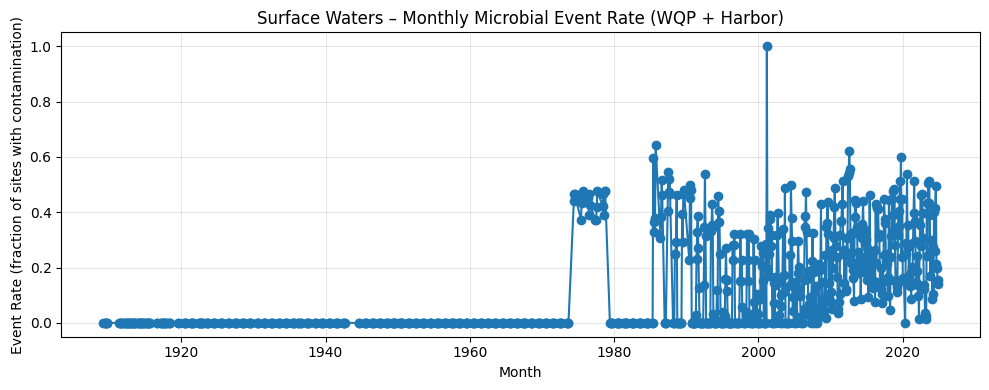

In [180]:
#monthly event rate (global)
monthly = (
    dm.groupby("month_start")["y_surface"]
    .mean()
    .reset_index(name="event_rate")
)

plt.figure(figsize=(10,4))
plt.plot(monthly["month_start"], monthly["event_rate"], marker="o")
plt.title("Surface Waters – Monthly Microbial Event Rate (WQP + Harbor)")
plt.xlabel("Month")
plt.ylabel("Event Rate (fraction of sites with contamination)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [181]:
dm_1970 = dm[dm["month_start"] >= pd.Timestamp("1970-01-01")].copy()
print(dm_1970["month_start"].min(), dm_1970["month_start"].max())

1970-06-01 00:00:00 2024-12-01 00:00:00


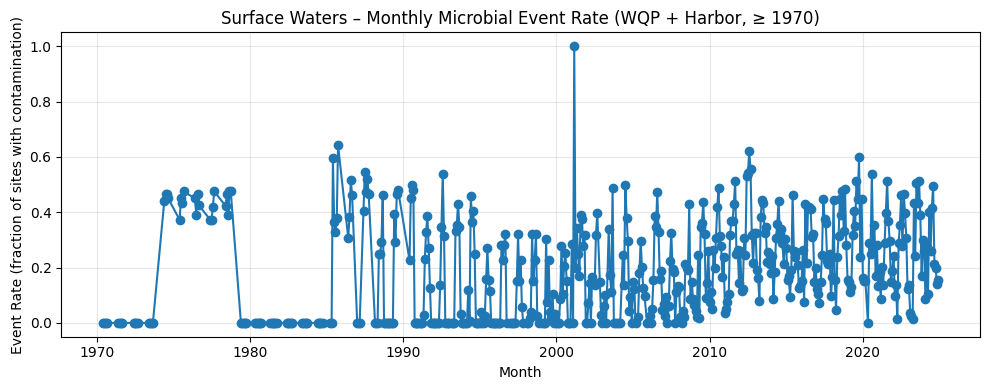

In [182]:
monthly_1970 = (
    dm_1970
    .groupby("month_start")["y_surface"]
    .mean()
    .reset_index(name="event_rate")
)

plt.figure(figsize=(10, 4))
plt.plot(monthly_1970["month_start"], monthly_1970["event_rate"], marker="o")
plt.title("Surface Waters – Monthly Microbial Event Rate (WQP + Harbor, ≥ 1970)")
plt.xlabel("Month")
plt.ylabel("Event Rate (fraction of sites with contamination)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

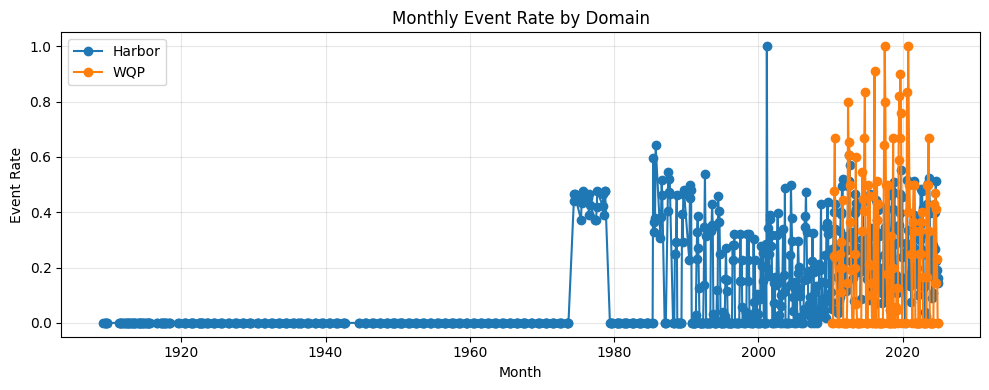

In [183]:
#Monthly event rate - WQP vs Harbor
monthly_dom = (
    dm.groupby(["month_start", "domain"])["y_surface"]
    .mean()
    .reset_index(name="event_rate")
)

plt.figure(figsize=(10,4))
for dom, sub in monthly_dom.groupby("domain"):
    plt.plot(sub["month_start"], sub["event_rate"], marker="o", label=dom)

plt.title("Monthly Event Rate by Domain")
plt.xlabel("Month")
plt.ylabel("Event Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

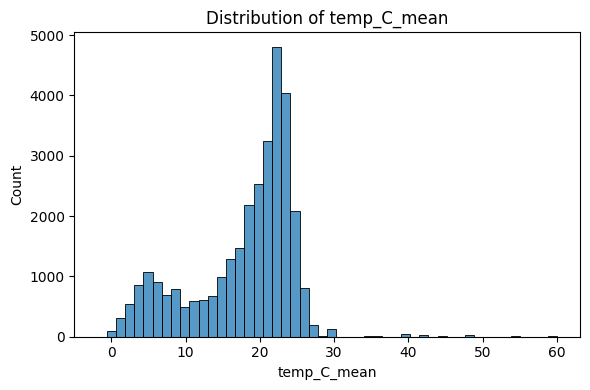

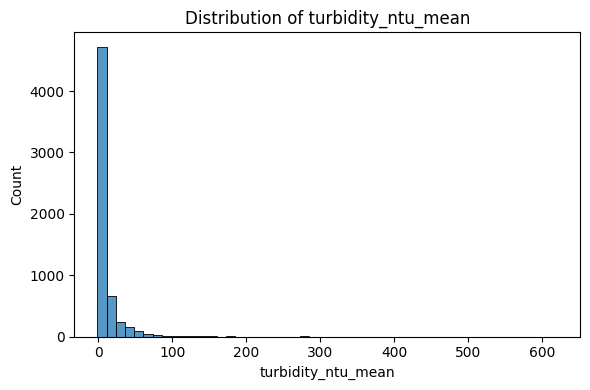

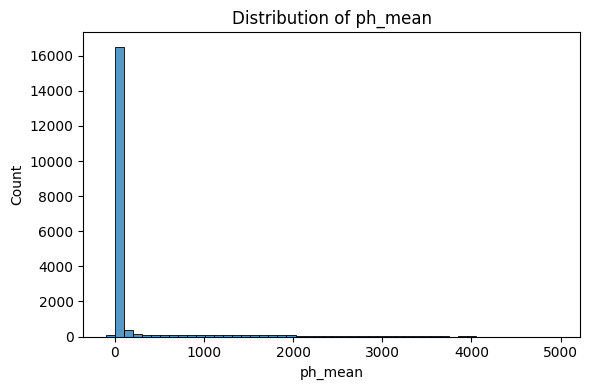

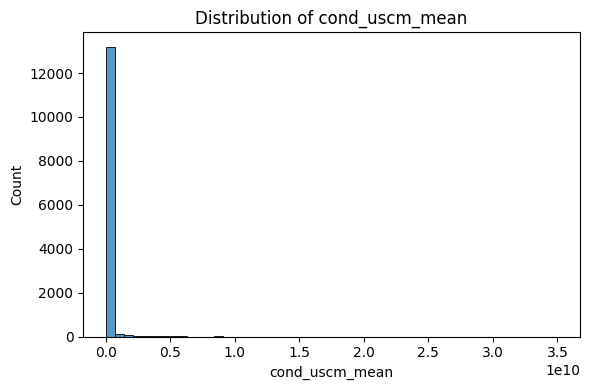

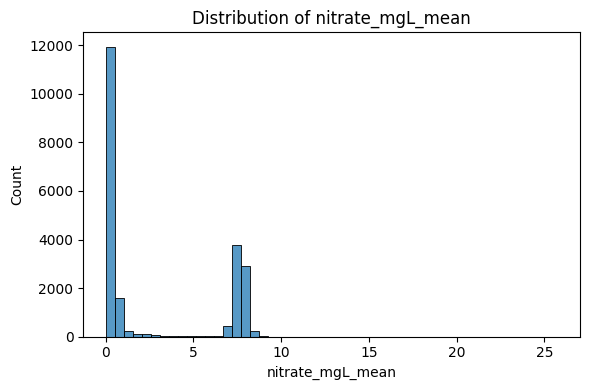

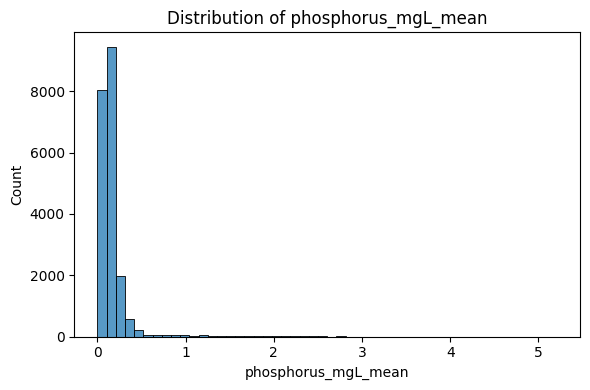

In [184]:
for col in feature_cols:
    if col not in dm.columns:
        continue
    plt.figure(figsize=(6,4))
    sns.histplot(dm[col], bins=50, kde=False)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

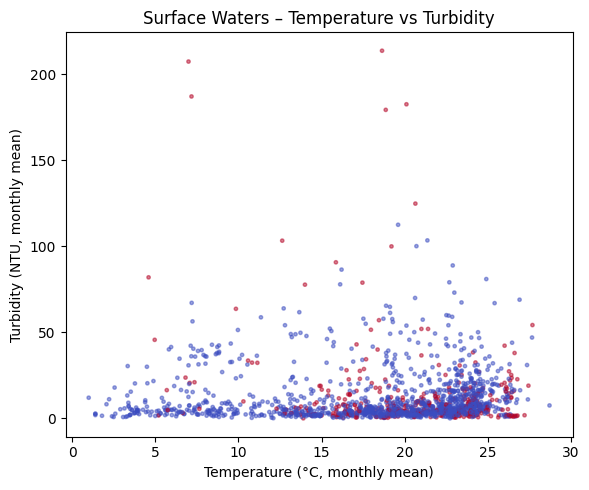

In [185]:
plt.figure(figsize=(6,5))
plt.scatter(
    dm["temp_C_mean"],
    dm["turbidity_ntu_mean"],
    c=dm["y_surface"],
    s=6,
    alpha=0.5,
    cmap="coolwarm"
)
plt.xlabel("Temperature (°C, monthly mean)")
plt.ylabel("Turbidity (NTU, monthly mean)")
plt.title("Surface Waters – Temperature vs Turbidity")
plt.tight_layout()
plt.show()


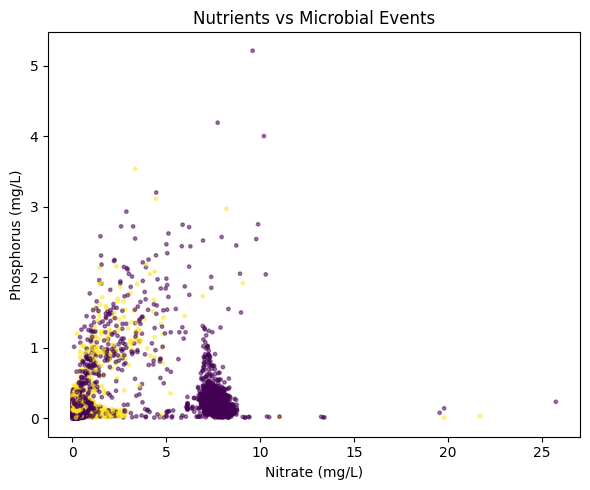

In [186]:
plt.figure(figsize=(6,5))
plt.scatter(
    dm["nitrate_mgL_mean"],
    dm["phosphorus_mgL_mean"],
    c=dm["y_surface"],
    s=6,
    alpha=0.5
)
plt.xlabel("Nitrate (mg/L)")
plt.ylabel("Phosphorus (mg/L)")
plt.title("Nutrients vs Microbial Events")
plt.tight_layout()
plt.show()

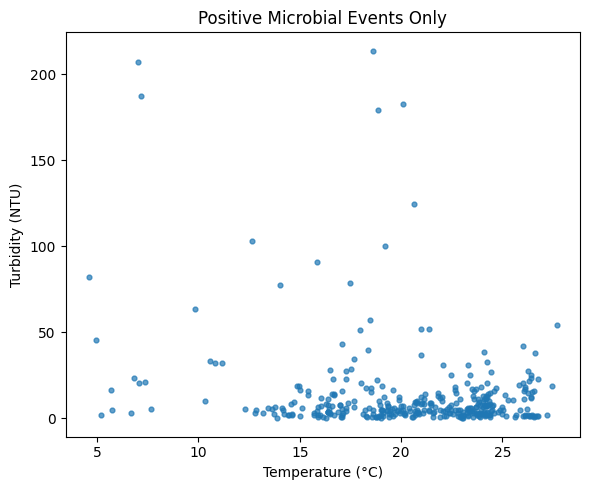

In [187]:
pos = dm[dm["y_surface"] == 1]

plt.figure(figsize=(6,5))
plt.scatter(
    pos["temp_C_mean"],
    pos["turbidity_ntu_mean"],
    s=12,
    alpha=0.7
)
plt.xlabel("Temperature (°C)")
plt.ylabel("Turbidity (NTU)")
plt.title("Positive Microbial Events Only")
plt.tight_layout()
plt.show()

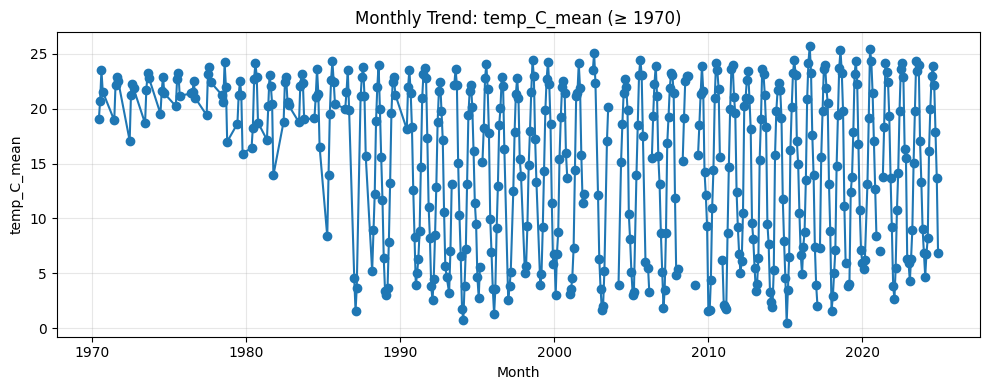

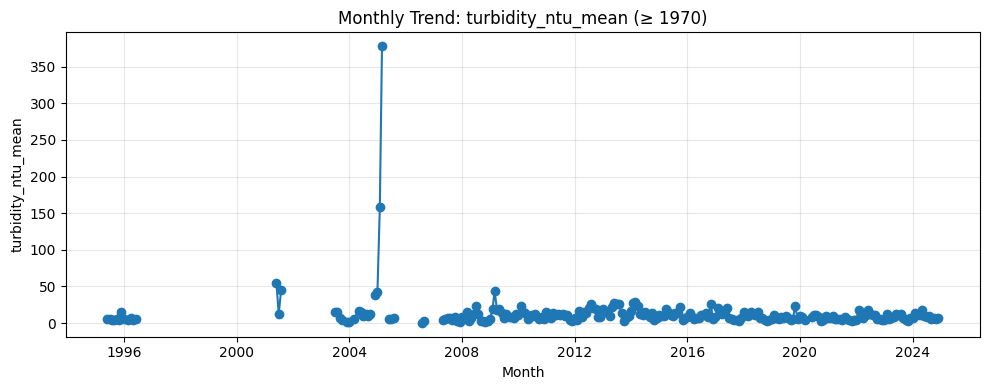

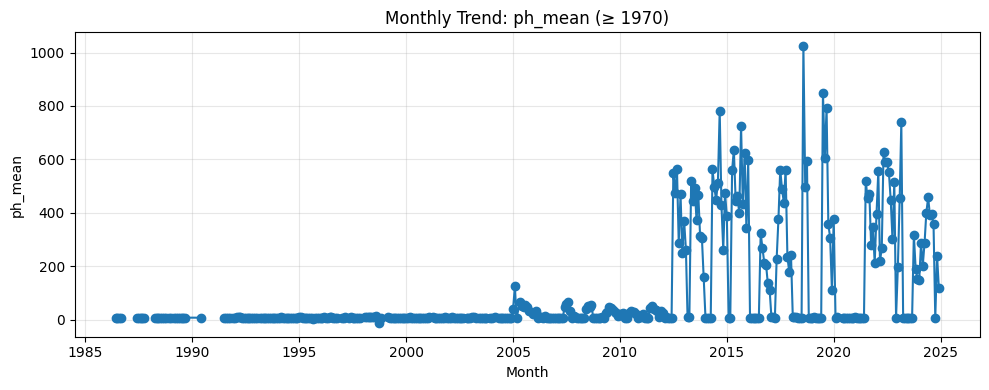

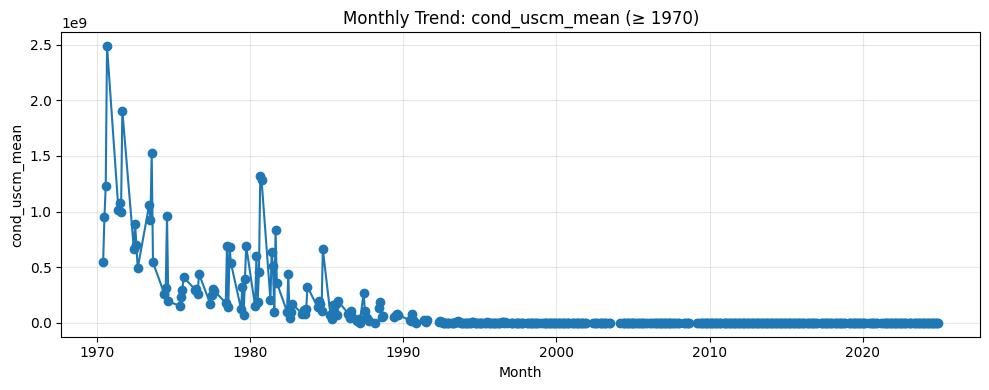

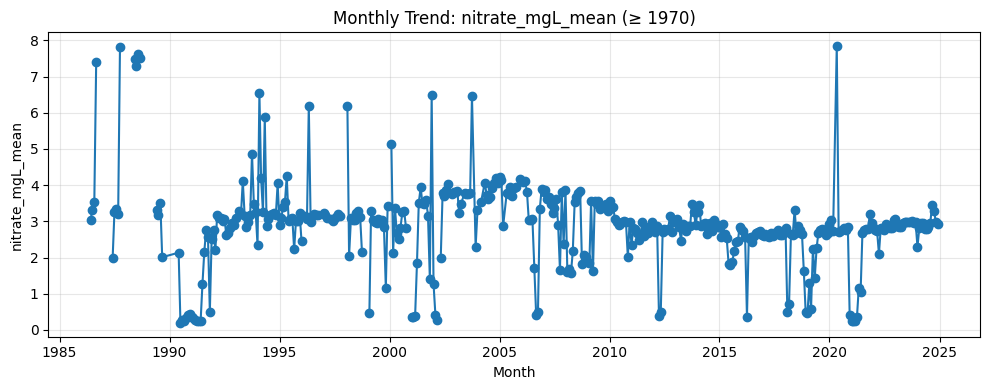

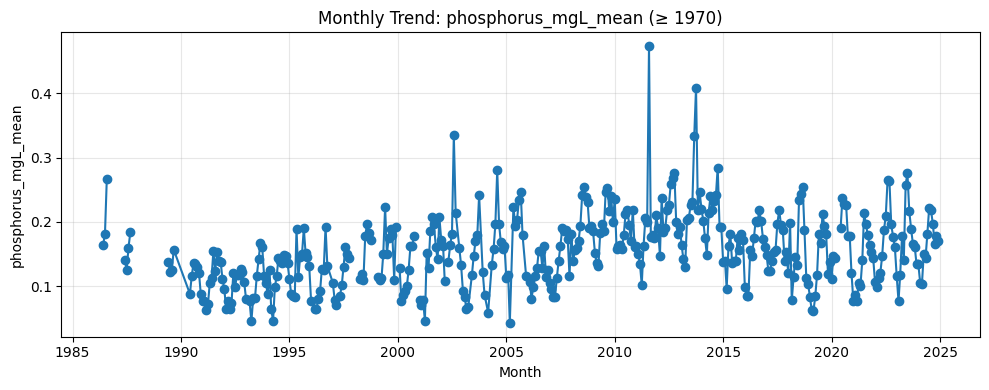

In [188]:
monthly_features = (
    dm_1970.groupby("month_start")[feature_cols]
    .mean()
    .reset_index()
)

monthly_features.head()
for col in feature_cols:
    plt.figure(figsize=(10, 4))
    plt.plot(monthly_features["month_start"], monthly_features[col], marker="o")
    plt.title(f"Monthly Trend: {col} (≥ 1970)")
    plt.xlabel("Month")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

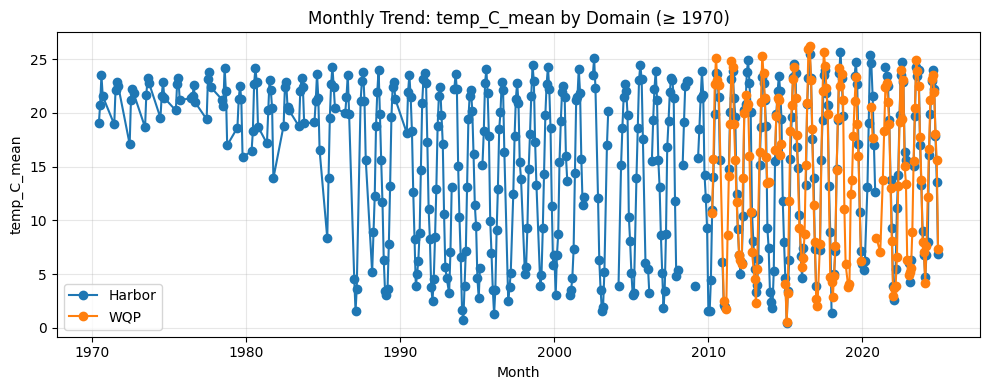

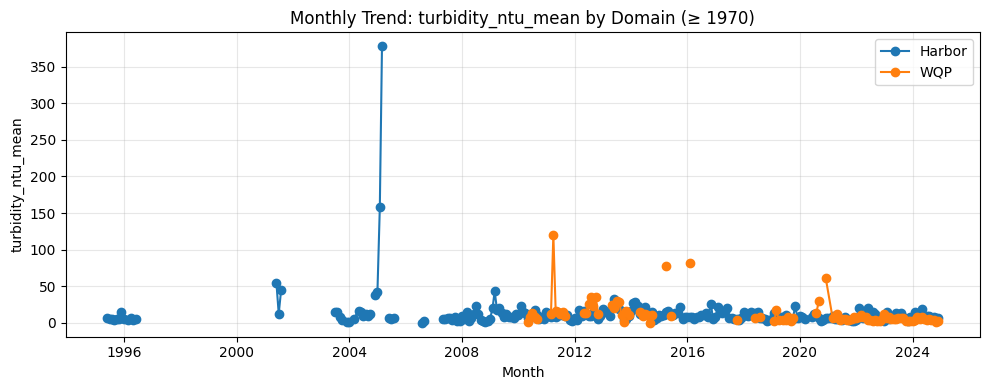

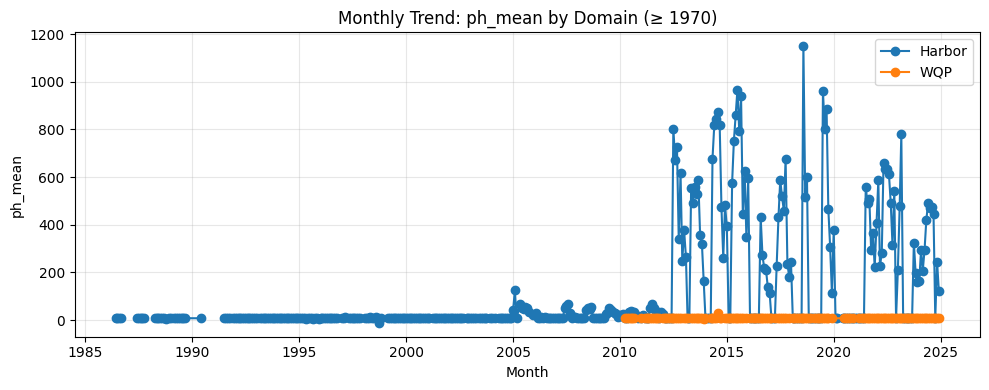

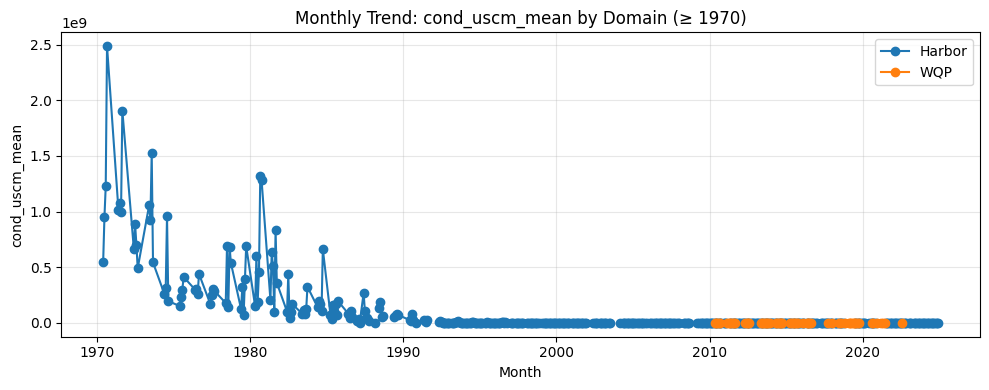

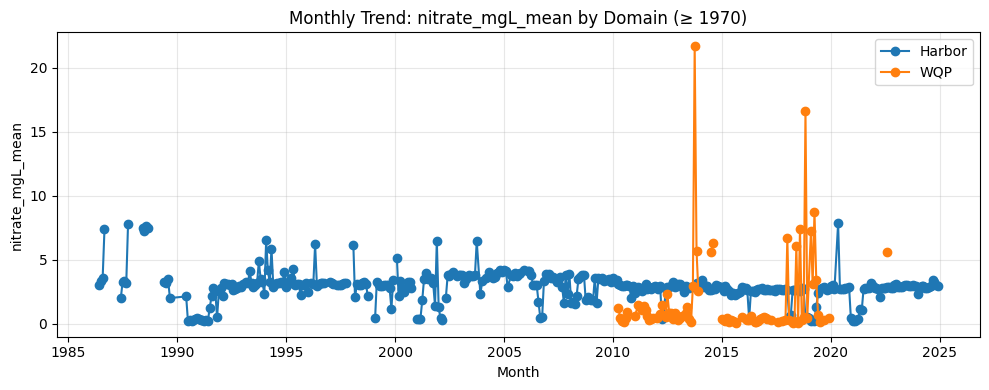

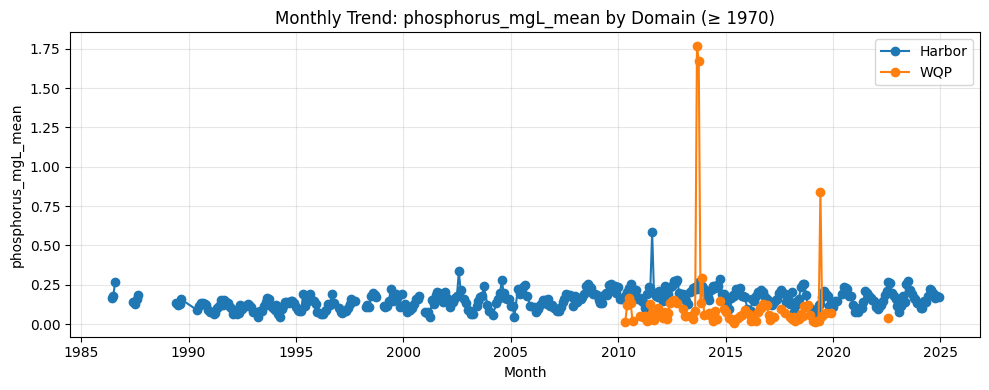

In [189]:
for col in feature_cols:
    monthly_dom_feat = (
        dm_1970.groupby(["month_start", "domain"])[col]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(10,4))
    for dom, sub in monthly_dom_feat.groupby("domain"):
        plt.plot(sub["month_start"], sub[col], marker="o", label=dom)

    plt.title(f"Monthly Trend: {col} by Domain (≥ 1970)")
    plt.xlabel("Month")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

####Model Training

In [190]:
model_df = dm_1970.copy()

# input features
X = model_df[feature_cols]

# target
y = model_df["y_surface"]

model_idx = X.dropna(how="all").index
X = X.loc[model_idx]
y = y.loc[model_idx]

print("Final modeling dataset shape:", X.shape)

Final modeling dataset shape: (28699, 6)


In [191]:
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)

In [192]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []
pr_scores = []

for train_idx, test_idx in skf.split(X_imp, y):
    X_train, X_test = X_imp[train_idx], X_imp[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced"   # helps with imbalance
    )

    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]

    auc_scores.append(roc_auc_score(y_test, y_prob))
    pr_scores.append(average_precision_score(y_test, y_prob))

print("Mean AUC:", np.mean(auc_scores))
print("Mean PR-AUC:", np.mean(pr_scores))

Mean AUC: 0.8966121296489085
Mean PR-AUC: 0.6742242000570796


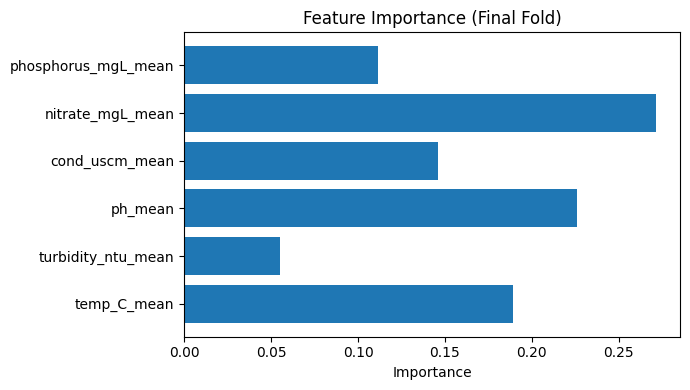

In [193]:
#feature importance plot
importances = model.feature_importances_

plt.figure(figsize=(7,4))
plt.barh(feature_cols, importances)
plt.title("Feature Importance (Final Fold)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

####Export

Export dir: framework2_model2_exports


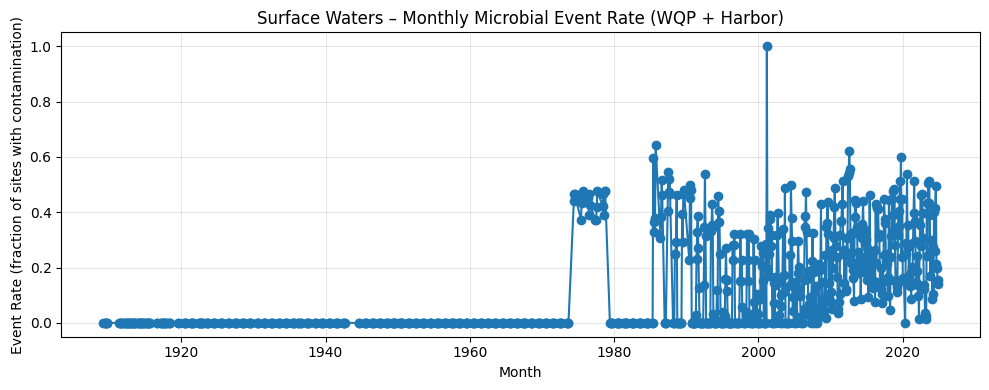

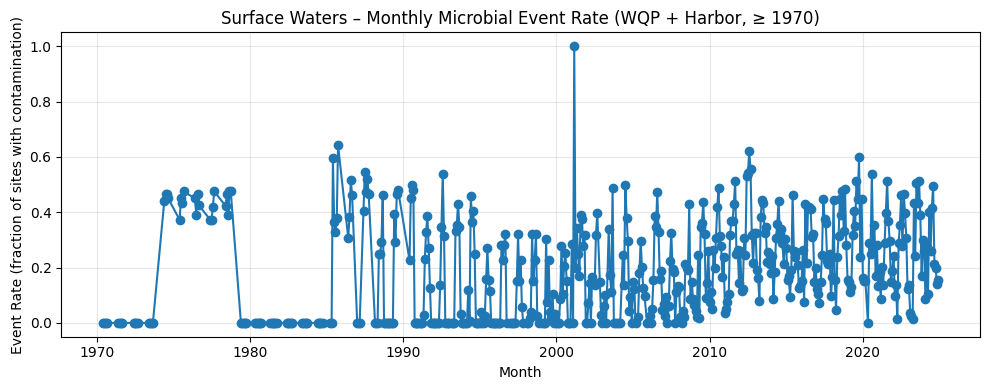

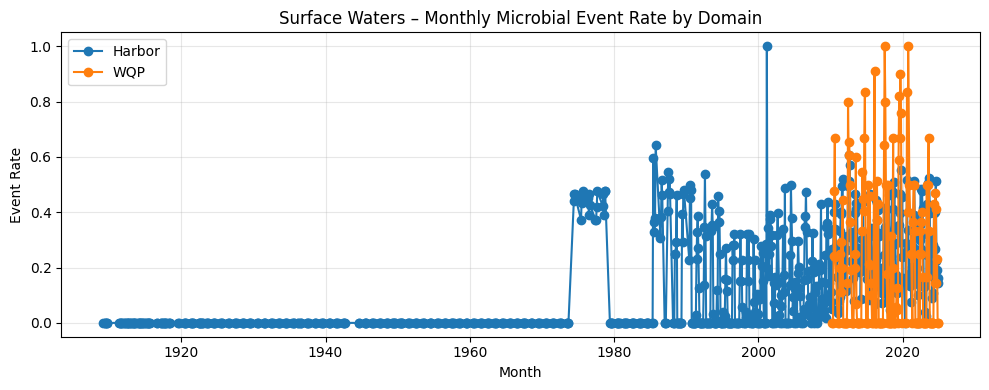

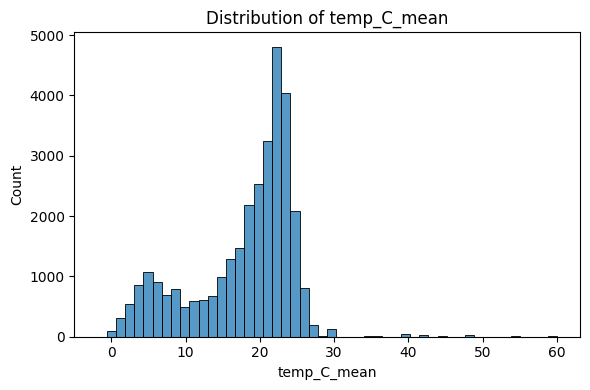

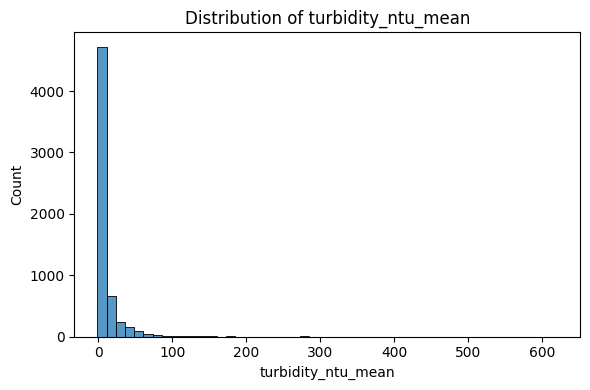

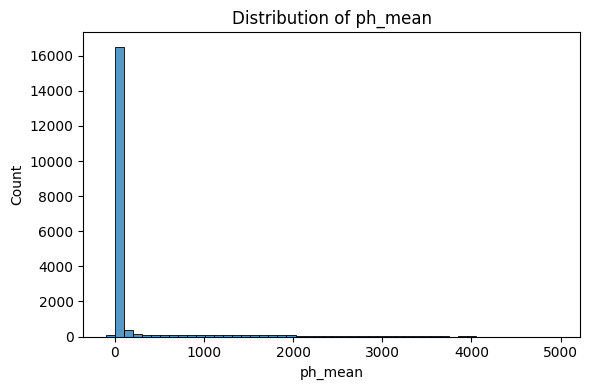

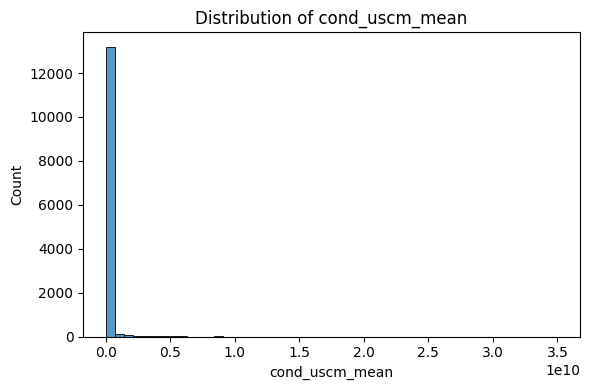

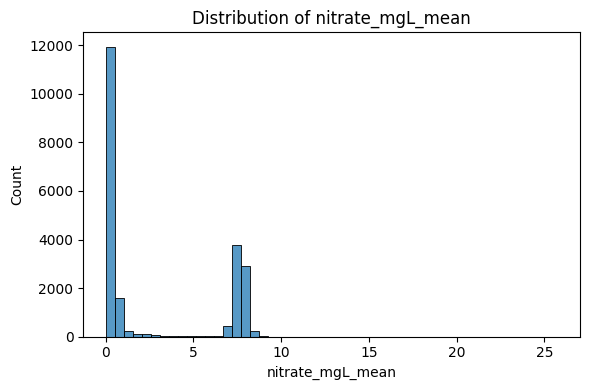

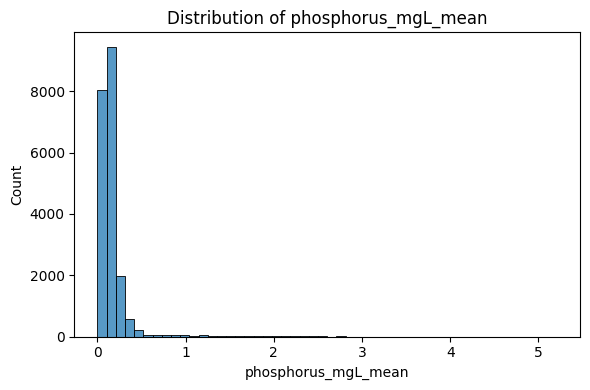

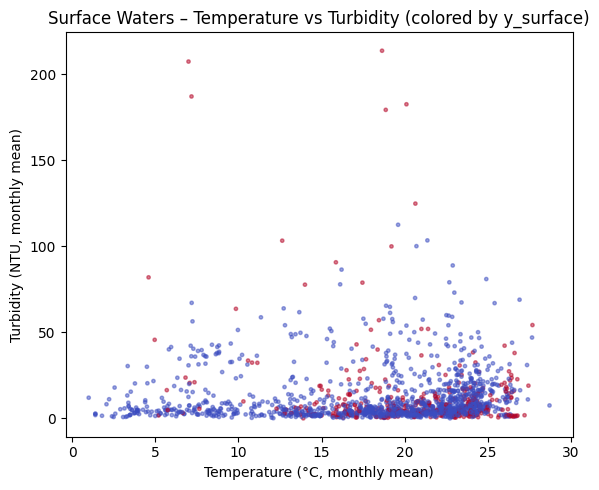

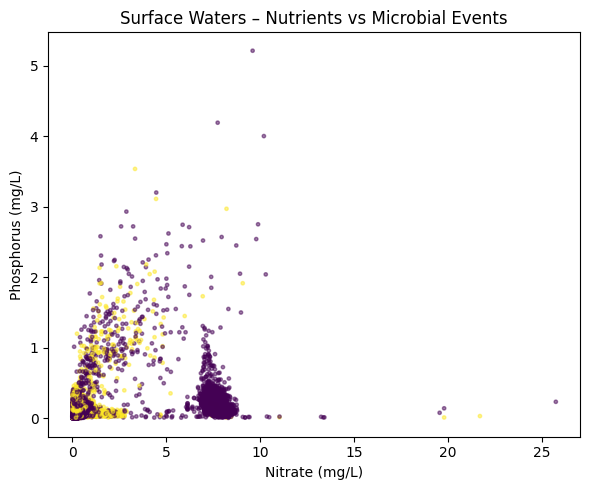

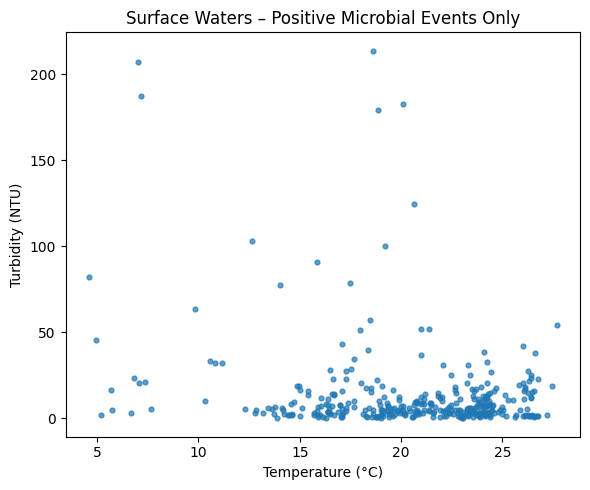

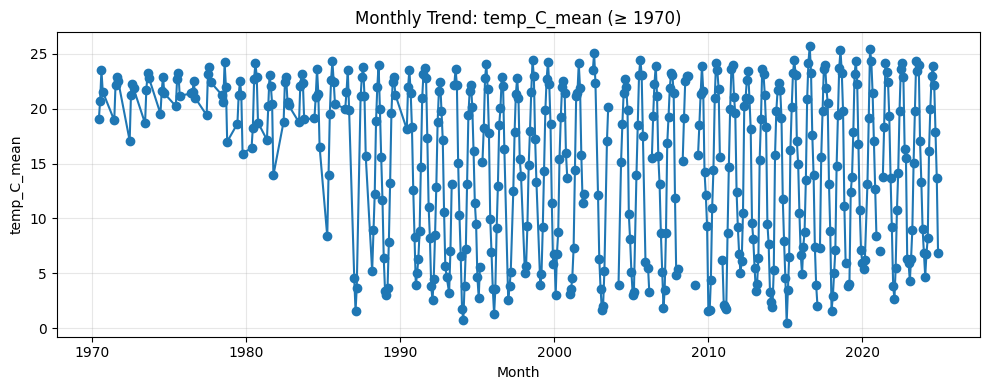

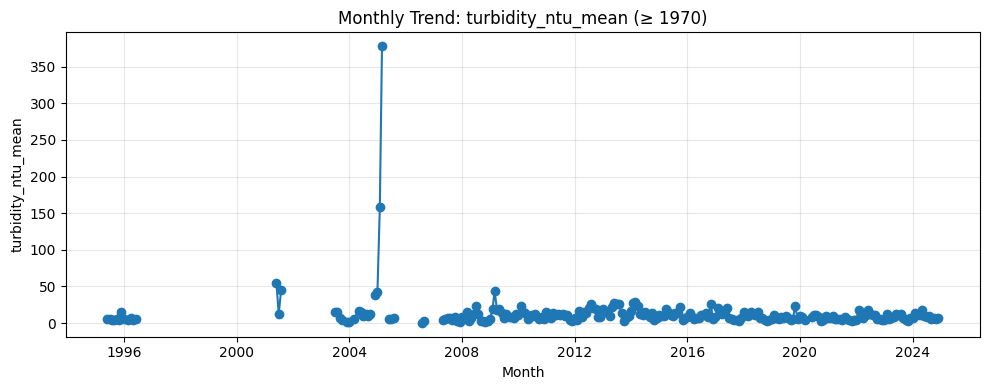

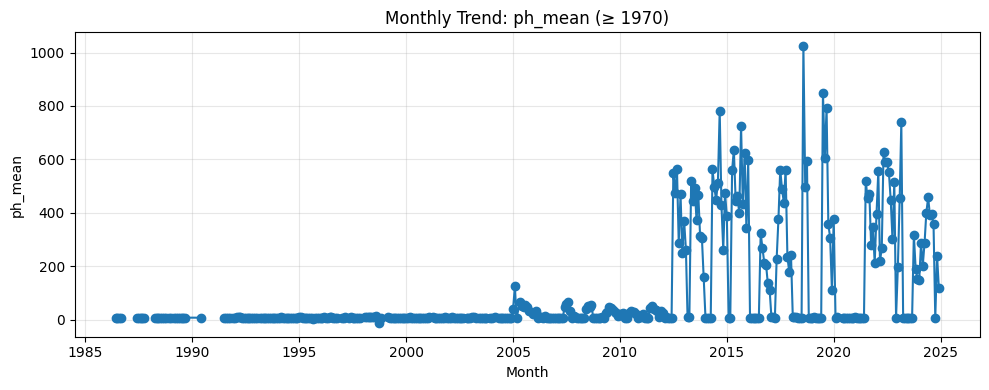

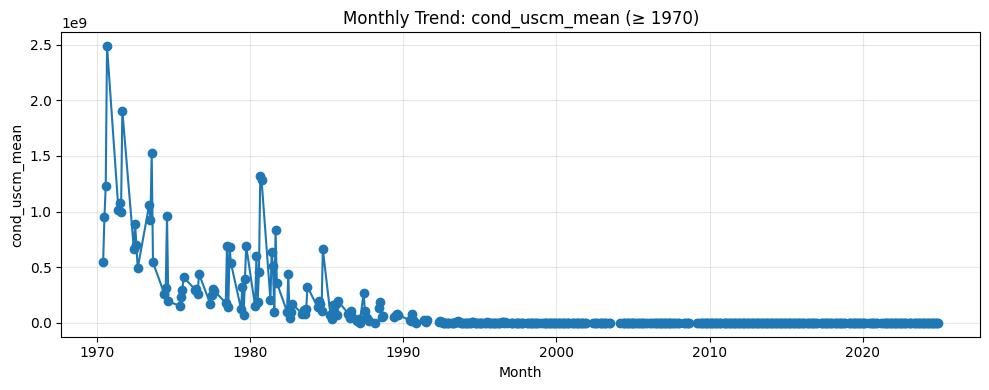

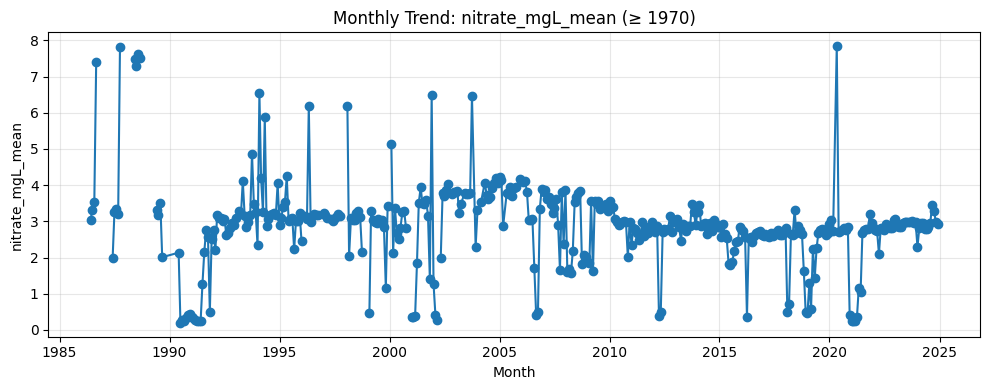

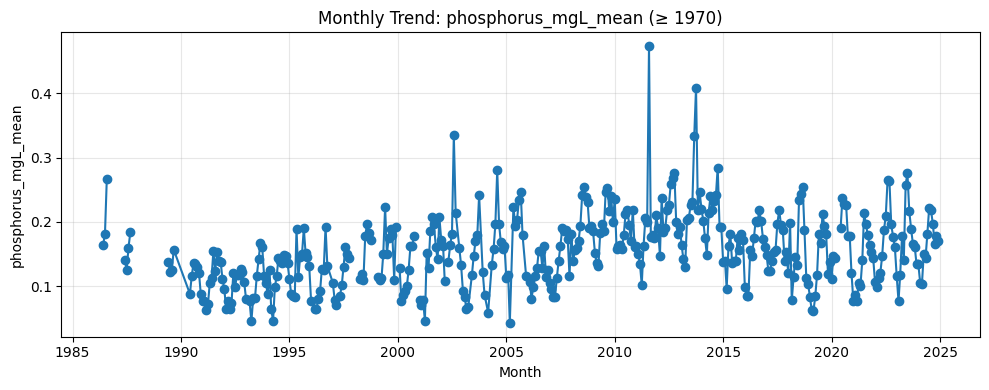

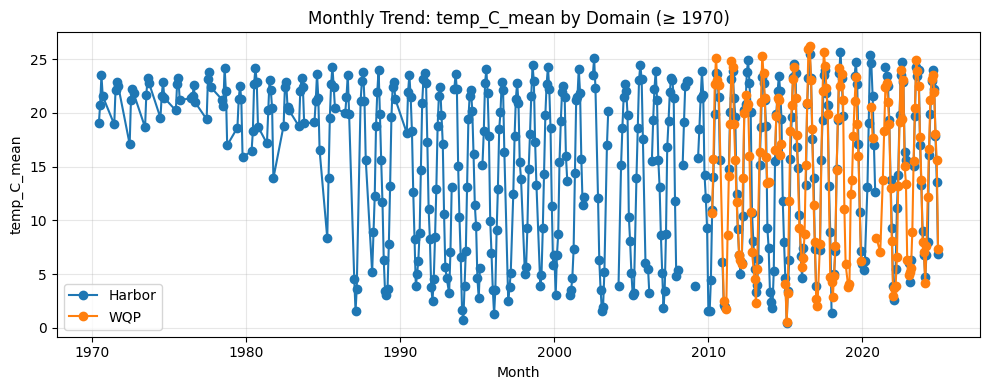

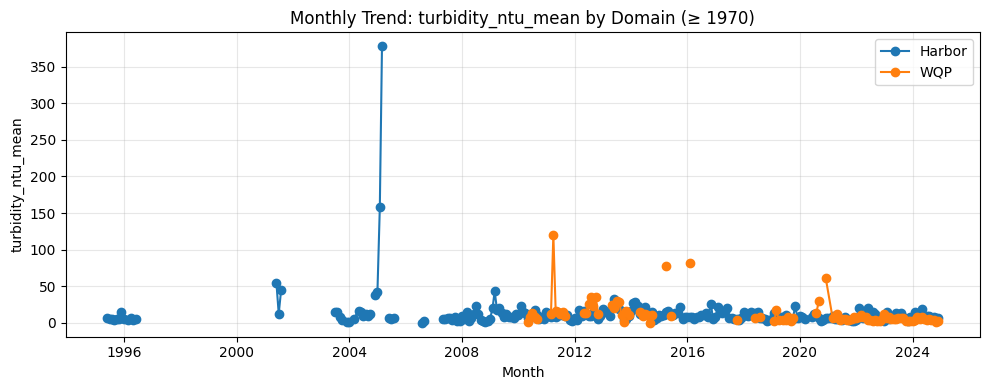

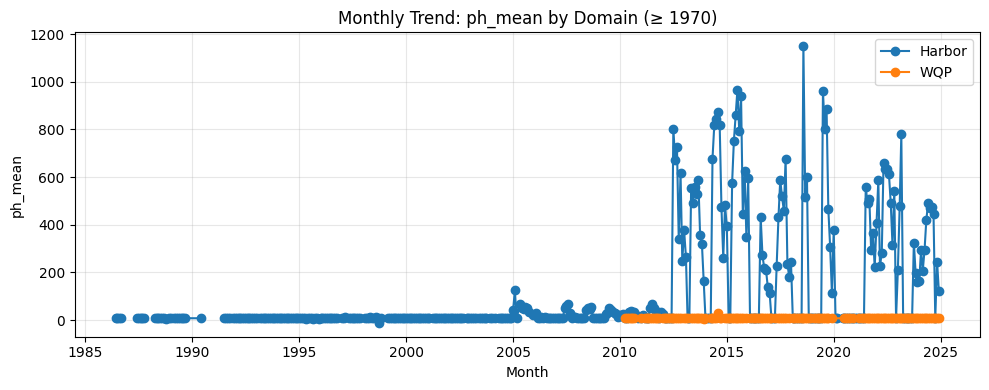

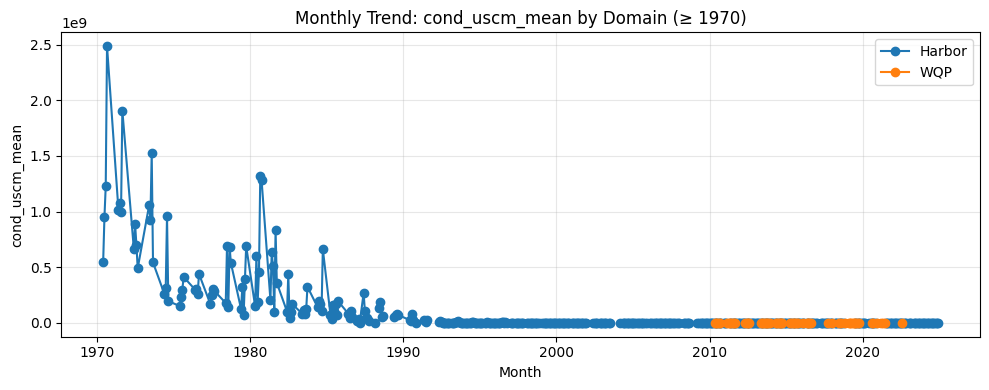

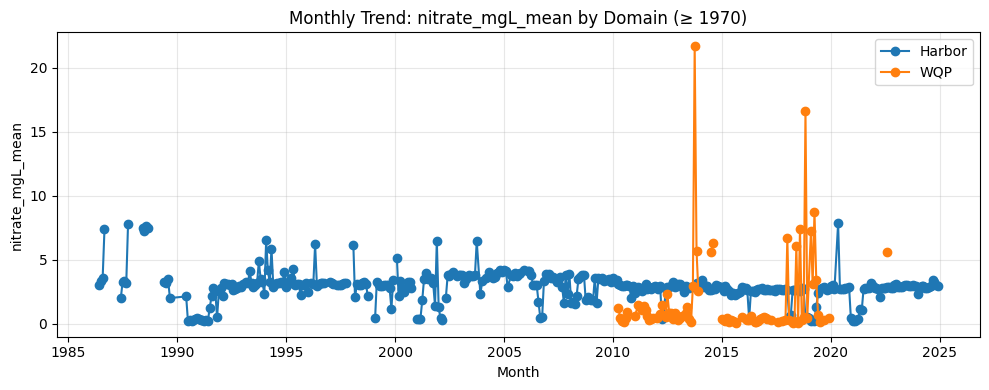

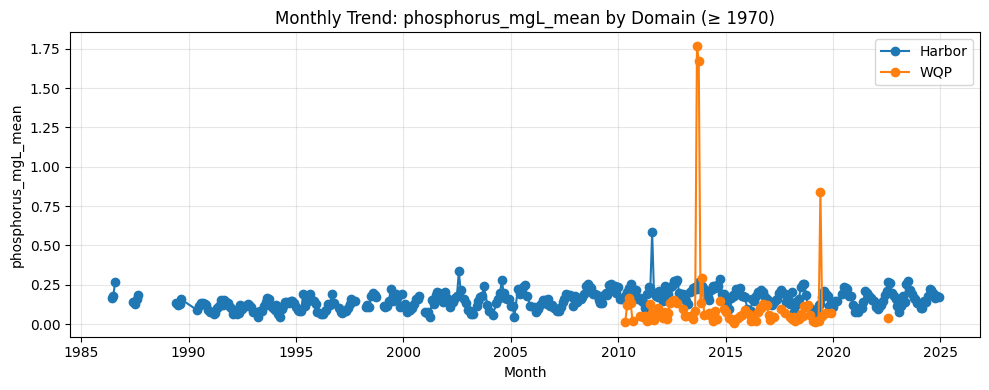

Final modeling dataset shape: (28699, 6)
Mean AUC: 0.8966121296489085
Mean PR-AUC: 0.6742242000570796


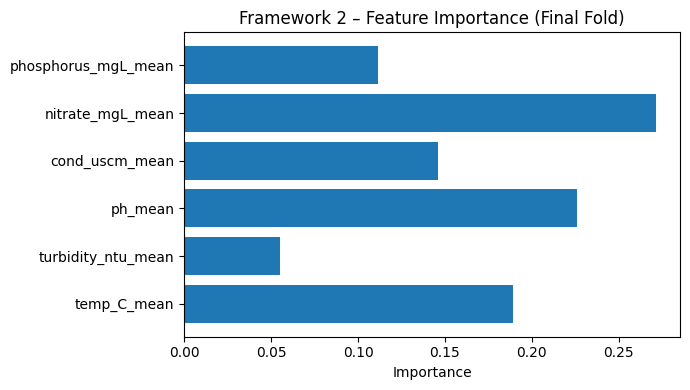

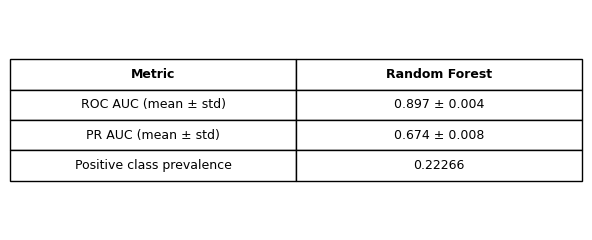

Created zip: framework2_model2_bundle.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [194]:
from google.colab import files  # for download


# ===== 2. Rebuild Model 2 dataset & features =====

# Starting from unified surface table
dm = surface_unified_monthly.copy()

feature_cols = [
    "temp_C_mean",
    "turbidity_ntu_mean",
    "ph_mean",
    "cond_uscm_mean",
    "nitrate_mgL_mean",
    "phosphorus_mgL_mean",
]

# Drop rows where all physchem features are NaN
dm = dm.dropna(subset=feature_cols, how="all").copy()

# Make sure month_start exists and is datetime
if "month_start" not in dm.columns:
    dm["month_start"] = dm["month"].dt.to_timestamp()

# Restrict to >= 1970 for main modeling, as in your code
dm_1970 = dm[dm["month_start"] >= pd.Timestamp("1970-01-01")].copy()

# Global monthly microbial event rate
monthly_all = (
    dm.groupby("month_start")["y_surface"]
    .mean()
    .reset_index(name="event_rate")
)

# Monthly event rate >=1970
monthly_1970 = (
    dm_1970.groupby("month_start")["y_surface"]
    .mean()
    .reset_index(name="event_rate")
)

# Monthly event rate by domain
monthly_dom = (
    dm.groupby(["month_start", "domain"])["y_surface"]
    .mean()
    .reset_index(name="event_rate")
)

# Monthly feature means (≥1970)
monthly_features = (
    dm_1970.groupby("month_start")[feature_cols]
    .mean()
    .reset_index()
)

# Monthly feature means by domain (≥1970) – will use for JSON only
monthly_dom_features = {}
for col in feature_cols:
    monthly_dom_feat = (
        dm_1970.groupby(["month_start", "domain"])[col]
        .mean()
        .reset_index()
    )
    monthly_dom_features[col] = monthly_dom_feat


# ===== 3. Export directory =====
EXPORT_DIR = Path("framework2_model2_exports")
EXPORT_DIR.mkdir(exist_ok=True)
print("Export dir:", EXPORT_DIR)


# ===== 4. PNG plots =====

# 4.1 Surface Waters – Monthly microbial event rate (all years)
plt.figure(figsize=(10,4))
plt.plot(monthly_all["month_start"], monthly_all["event_rate"], marker="o")
plt.title("Surface Waters – Monthly Microbial Event Rate (WQP + Harbor)")
plt.xlabel("Month")
plt.ylabel("Event Rate (fraction of sites with contamination)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(EXPORT_DIR / "monthly_event_rate_all_years.png", dpi=300)
plt.show()

# 4.2 Same but ≥1970
plt.figure(figsize=(10,4))
plt.plot(monthly_1970["month_start"], monthly_1970["event_rate"], marker="o")
plt.title("Surface Waters – Monthly Microbial Event Rate (WQP + Harbor, ≥ 1970)")
plt.xlabel("Month")
plt.ylabel("Event Rate (fraction of sites with contamination)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(EXPORT_DIR / "monthly_event_rate_1970_plus.png", dpi=300)
plt.show()

# 4.3 Monthly event rate by domain
plt.figure(figsize=(10,4))
for dom, sub in monthly_dom.groupby("domain"):
    plt.plot(sub["month_start"], sub["event_rate"], marker="o", label=dom)
plt.title("Surface Waters – Monthly Microbial Event Rate by Domain")
plt.xlabel("Month")
plt.ylabel("Event Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(EXPORT_DIR / "monthly_event_rate_by_domain.png", dpi=300)
plt.show()

# 4.4 Histograms for each physchem feature
for col in feature_cols:
    if col not in dm.columns:
        continue
    plt.figure(figsize=(6,4))
    sns.histplot(dm[col], bins=50, kde=False)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(EXPORT_DIR / f"hist_{col}.png", dpi=300)
    plt.show()

# 4.5 Scatter: temp vs turbidity colored by y_surface
plt.figure(figsize=(6,5))
plt.scatter(
    dm["temp_C_mean"],
    dm["turbidity_ntu_mean"],
    c=dm["y_surface"],
    s=6,
    alpha=0.5,
    cmap="coolwarm"
)
plt.xlabel("Temperature (°C, monthly mean)")
plt.ylabel("Turbidity (NTU, monthly mean)")
plt.title("Surface Waters – Temperature vs Turbidity (colored by y_surface)")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "scatter_temp_vs_turbidity_colored_by_y_surface.png", dpi=300)
plt.show()

# 4.6 Scatter: nitrate vs phosphorus colored by y_surface
plt.figure(figsize=(6,5))
plt.scatter(
    dm["nitrate_mgL_mean"],
    dm["phosphorus_mgL_mean"],
    c=dm["y_surface"],
    s=6,
    alpha=0.5
)
plt.xlabel("Nitrate (mg/L)")
plt.ylabel("Phosphorus (mg/L)")
plt.title("Surface Waters – Nutrients vs Microbial Events")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "scatter_nutrients_vs_events.png", dpi=300)
plt.show()

# 4.7 Scatter: positive events only (temp vs turbidity)
pos = dm[dm["y_surface"] == 1].copy()

plt.figure(figsize=(6,5))
plt.scatter(
    pos["temp_C_mean"],
    pos["turbidity_ntu_mean"],
    s=12,
    alpha=0.7
)
plt.xlabel("Temperature (°C)")
plt.ylabel("Turbidity (NTU)")
plt.title("Surface Waters – Positive Microbial Events Only")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "scatter_positive_events_only.png", dpi=300)
plt.show()

# 4.8 Monthly trends of each feature (≥1970)
for col in feature_cols:
    plt.figure(figsize=(10,4))
    plt.plot(monthly_features["month_start"], monthly_features[col], marker="o")
    plt.title(f"Monthly Trend: {col} (≥ 1970)")
    plt.xlabel("Month")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(EXPORT_DIR / f"trend_{col}_1970_plus.png", dpi=300)
    plt.show()

# 4.9 Monthly trends of each feature by domain (≥1970)
for col in feature_cols:
    monthly_dom_feat = monthly_dom_features[col]
    plt.figure(figsize=(10,4))
    for dom, sub in monthly_dom_feat.groupby("domain"):
        plt.plot(sub["month_start"], sub[col], marker="o", label=dom)
    plt.title(f"Monthly Trend: {col} by Domain (≥ 1970)")
    plt.xlabel("Month")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(EXPORT_DIR / f"trend_{col}_by_domain_1970_plus.png", dpi=300)
    plt.show()


# ===== 5. Model training (re-run RF CV for clean summary) =====

model_df = dm_1970.copy()

X = model_df[feature_cols]
y = model_df["y_surface"]

# keep rows where not all features are NaN
model_idx = X.dropna(how="all").index
X = X.loc[model_idx]
y = y.loc[model_idx]

print("Final modeling dataset shape:", X.shape)

imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []
pr_scores = []

for train_idx, test_idx in skf.split(X_imp, y):
    X_train, X_test = X_imp[train_idx], X_imp[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced",
    )

    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]

    auc_scores.append(roc_auc_score(y_test, y_prob))
    pr_scores.append(average_precision_score(y_test, y_prob))

mean_auc = float(np.mean(auc_scores))
std_auc  = float(np.std(auc_scores))
mean_pr  = float(np.mean(pr_scores))
std_pr   = float(np.std(pr_scores))

print("Mean AUC:", mean_auc)
print("Mean PR-AUC:", mean_pr)

summary_2 = {
    "rf_auc_mean": mean_auc,
    "rf_auc_std": std_auc,
    "rf_pr_mean": mean_pr,
    "rf_pr_std": std_pr,
    "n_splits": 5,
    "n_samples": int(X_imp.shape[0]),
    "pos_prevalence": float(y.mean()),
}

# Feature importances (final model from last fold)
importances = model.feature_importances_
plt.figure(figsize=(7,4))
plt.barh(feature_cols, importances)
plt.title("Framework 2 – Feature Importance (Final Fold)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "feature_importance_model2.png", dpi=300)
plt.show()


# ===== 6. Training results table: CSV + PNG + JSON =====

# Simple table (only RF, no dummy baseline in this model)
results_table = pd.DataFrame(
    {
        "Metric": [
            "ROC AUC (mean ± std)",
            "PR AUC (mean ± std)",
            "Positive class prevalence",
        ],
        "Random Forest": [
            f"{mean_auc:.3f} ± {std_auc:.3f}",
            f"{mean_pr:.3f} ± {std_pr:.3f}",
            round(summary_2["pos_prevalence"], 5),
        ],
    }
)

results_table.to_csv(EXPORT_DIR / "model2_training_results_table.csv", index=False)

# PNG table
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis("off")

table_data = [results_table.columns.tolist()] + results_table.values.tolist()
table = ax.table(
    cellText=table_data,
    loc="center",
    cellLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.6)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")

fig.tight_layout()
fig.savefig(EXPORT_DIR / "model2_training_results_table.png", dpi=300, bbox_inches="tight")
plt.show()

# Raw numeric JSON summary
with open(EXPORT_DIR / "model2_training_results.json", "w") as f:
    json.dump(summary_2, f, indent=2)


# ===== 7. Graph data JSON (for recreating line plots) =====

graphs_json = {}

# Event rate (all years)
graphs_json["monthly_event_rate_all"] = {
    "month_start": monthly_all["month_start"].astype(str).tolist(),
    "event_rate": monthly_all["event_rate"].tolist(),
    "title": "Surface Waters – Monthly Microbial Event Rate (WQP + Harbor)",
    "y_label": "Event Rate",
}

# Event rate (≥1970)
graphs_json["monthly_event_rate_1970_plus"] = {
    "month_start": monthly_1970["month_start"].astype(str).tolist(),
    "event_rate": monthly_1970["event_rate"].tolist(),
    "title": "Surface Waters – Monthly Microbial Event Rate (WQP + Harbor, ≥ 1970)",
    "y_label": "Event Rate",
}

# Event rate by domain
graphs_json["monthly_event_rate_by_domain"] = {
    "month_start": monthly_dom["month_start"].astype(str).tolist(),
    "domain": monthly_dom["domain"].tolist(),
    "event_rate": monthly_dom["event_rate"].tolist(),
    "title": "Surface Waters – Monthly Event Rate by Domain",
    "y_label": "Event Rate",
}

# Monthly feature trends (≥1970)
graphs_json["monthly_feature_trends_1970_plus"] = {
    "month_start": monthly_features["month_start"].astype(str).tolist(),
    "features": {
        col: monthly_features[col].tolist()
        for col in feature_cols
    },
    "title": "Surface Waters – Monthly PhysChem Trends (≥ 1970)",
}

# Monthly feature trends by domain (≥1970)
graphs_json["monthly_feature_trends_by_domain_1970_plus"] = {}
for col in feature_cols:
    df_feat = monthly_dom_features[col]
    graphs_json["monthly_feature_trends_by_domain_1970_plus"][col] = {
        "month_start": df_feat["month_start"].astype(str).tolist(),
        "domain": df_feat["domain"].tolist(),
        "value": df_feat[col].tolist(),
        "y_label": col,
    }

with open(EXPORT_DIR / "framework2_model2_graph_data.json", "w") as f:
    json.dump(graphs_json, f, indent=2)


# ===== 8. Zip everything & download =====

zip_path = "framework2_model2_bundle.zip"

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, filenames in os.walk(EXPORT_DIR):
        for fname in filenames:
            full_path = Path(root) / fname
            rel_path = full_path.relative_to(EXPORT_DIR)
            zf.write(full_path, arcname=rel_path)

print("Created zip:", zip_path)
files.download(zip_path)

## Framework 2 (Crop Yield Prediction)




###Model 1

####Feature Engineering

In [196]:
usda_path = DATA_ROOT / "USDA_NASS_Regional_Crop_Yield" / "USDA_Regional_Crop_Yield_Data.csv"

# Parse HTML table(s) from the saved file
usda_tables = pd.read_html(usda_path, header=0)  # header=0 uses first row as header
df_usda_raw = usda_tables[0]

print("USDA raw shape:", df_usda_raw.shape)
print(df_usda_raw.columns.tolist())
df_usda_raw.head()

USDA raw shape: (38683, 21)
['Program', 'Year', 'Period', 'Week Ending', 'Geo Level', 'State', 'State ANSI', 'Ag District', 'Ag District Code', 'County', 'County ANSI', 'Zip Code', 'Region', 'watershed_code', 'Watershed', 'Commodity', 'Data Item', 'Domain', 'Domain Category', 'Value', 'CV (%)']


Program  Year Period  Week Ending Geo Level     State  State ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
1  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
2  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
3  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
4  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   

  Ag District  Ag District Code  County  ...  Zip Code  Region  \
0     CENTRAL                50  CAYUGA  ...       NaN     NaN   
1     CENTRAL                50  CAYUGA  ...       NaN     NaN   
2     CENTRAL                50  CAYUGA  ...       NaN     NaN   
3     CENTRAL                50  CAYUGA  ...       NaN     NaN   
4     CENTRAL                50  CAYUGA  ...       NaN     NaN   

   watershed_code  Watershed   Commodity  \
0               0        NaN  ARTICHOKES   
1               0        NaN  ARTICHOKES   
2               0        NaN  ARTICHOKES   
3               0        NaN  ARTICHOKES   
4               0        NaN   ASPARAGUS   

                                           Data Item Domain Domain Category  \
0                       ARTICHOKES - ACRES HARVESTED  TOTAL   NOT SPECIFIED   
1        ARTICHOKES - OPERATIONS WITH AREA HARVESTED  TOTAL   NOT SPECIFIED   
2           ARTICHOKES, PROCESSING - ACRES HARVESTED  TOTAL   NOT SPECIFIED   
3  ARTICHOKES, PROCESSING - OPERATIONS WITH AREA ...  TOTAL   NOT SPECIFIED   
4                        ASPARAGUS - ACRES HARVESTED  TOTAL   NOT SPECIFIED   

  Value CV (%)  
0   (D)    (D)  
1     1    (L)  
2   (D)    (D)  
3     1    (L)  
4     4    5.5  

[5 rows x 21 columns]

In [197]:
### Clean USDA NASS data (NY counties, crop yields)

df_y = df_usda_raw.copy()
df_y.columns = [c.upper() for c in df_y.columns]  # normalize

print("Raw USDA columns:", df_y.columns.tolist())
print(df_y.head(3))

# 1) Filter to NY + county (your query already did this, but it won't hurt)
mask = (
    (df_y["STATE"].str.upper() == "NEW YORK") &
    (df_y["GEO LEVEL"].str.upper() == "COUNTY")
)
df_y = df_y.loc[mask].copy()
print("After STATE=NY & GEO LEVEL=COUNTY:", df_y.shape)

# 2) Clean numeric VALUE
df_y["VALUE_NUM"] = (
    df_y["VALUE"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({
        "(D)": np.nan, "(L)": np.nan, "(Z)": np.nan, "(NA)": np.nan, "": np.nan
    })
)
df_y["VALUE_NUM"] = pd.to_numeric(df_y["VALUE_NUM"], errors="coerce")
df_y = df_y.dropna(subset=["VALUE_NUM"]).copy()

# 3) Pick a commodity
print("Example COMMODITY values:", df_y["COMMODITY"].unique()[:20])

# >>> CHANGE THIS to something that actually appears, e.g. "CORN", "SOYBEANS", "BARLEY"
target_commodity = "CORN"

if target_commodity in df_y["COMMODITY"].unique():
    df_y = df_y[df_y["COMMODITY"] == target_commodity].copy()
    print(f"After COMMODITY='{target_commodity}' filter:", df_y.shape)
else:
    print(f"WARNING: '{target_commodity}' not found in COMMODITY; using all commodities")

# 4) Build yield values

df_y["YEAR"] = pd.to_numeric(df_y["YEAR"], errors="coerce")
df_y = df_y.dropna(subset=["YEAR"]).copy()
df_y["YEAR"] = df_y["YEAR"].astype(int)

# Try to use direct YIELD rows if they exist
has_yield_rows = df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False).any()
print("Any DATA ITEM rows with 'YIELD'?", has_yield_rows)

if has_yield_rows:
    yield_rows = df_y[df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False)].copy()
    yield_rows["COUNTY_NAME"] = (
        yield_rows["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )
    panel = (
        yield_rows[["YEAR", "COUNTY_NAME", "COMMODITY", "VALUE_NUM"]]
        .rename(columns={"VALUE_NUM": "YIELD"})
        .drop_duplicates()
        .copy()
    )
else:
    # Compute yield = PRODUCTION / ACRES HARVESTED
    sub = df_y[df_y["DATA ITEM"].str.contains("ACRES HARVESTED|PRODUCTION", case=False, na=False)].copy()

    def simplify_item(s):
        s = str(s).upper()
        if "ACRES HARVESTED" in s:
            return "ACRES"
        if "PRODUCTION" in s:
            return "PRODUCTION"
        return None

    sub["DATA_ITEM_SIMPLE"] = sub["DATA ITEM"].apply(simplify_item)
    sub = sub[sub["DATA_ITEM_SIMPLE"].notna()].copy()

    pivot = sub.pivot_table(
        index=["YEAR", "COUNTY", "COMMODITY"],
        columns="DATA_ITEM_SIMPLE",
        values="VALUE_NUM",
        aggfunc="first"
    ).reset_index()

    # Drop rows where we don't have both pieces
    pivot = pivot.dropna(subset=["ACRES", "PRODUCTION"]).copy()
    pivot["YIELD"] = pivot["PRODUCTION"] / pivot["ACRES"]

    pivot["COUNTY_NAME"] = (
        pivot["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )

    panel = pivot[["YEAR", "COUNTY_NAME", "COMMODITY", "YIELD"]].copy()

print("Yield panel shape (county-year):", panel.shape)
panel.head()


Raw USDA columns: ['PROGRAM', 'YEAR', 'PERIOD', 'WEEK ENDING', 'GEO LEVEL', 'STATE', 'STATE ANSI', 'AG DISTRICT', 'AG DISTRICT CODE', 'COUNTY', 'COUNTY ANSI', 'ZIP CODE', 'REGION', 'WATERSHED_CODE', 'WATERSHED', 'COMMODITY', 'DATA ITEM', 'DOMAIN', 'DOMAIN CATEGORY', 'VALUE', 'CV (%)']
  PROGRAM  YEAR PERIOD  WEEK ENDING GEO LEVEL     STATE  STATE ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
1  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
2  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   

  AG DISTRICT  AG DISTRICT CODE  COUNTY  ...  ZIP CODE  REGION  \
0     CENTRAL                50  CAYUGA  ...       NaN     NaN   
1     CENTRAL                50  CAYUGA  ...       NaN     NaN   
2     CENTRAL                50  CAYUGA  ...       NaN     NaN   

   WATERSHED_CODE  WATERSHED   COMMODITY  \
0               0        NaN  ARTICHOKES   
1               0        NaN  ARTICHOKES   
2               0        NaN  AR

YEAR COUNTY_NAME COMMODITY  YIELD
31578  2024      CAYUGA      CORN  182.2
31581  2024      CAYUGA      CORN   21.0
31589  2024    CHENANGO      CORN  132.8
31592  2024    CHENANGO      CORN   19.0
31599  2024    CORTLAND      CORN   20.0

In [198]:
df_y = df_usda_raw.copy()
df_y.columns = [c.upper() for c in df_y.columns]  # normalize

print("Raw USDA columns:", df_y.columns.tolist())
print(df_y.head(3))

# 1) Filter to NY + county (your query already did this, but it won't hurt)
mask = (
    (df_y["STATE"].str.upper() == "NEW YORK") &
    (df_y["GEO LEVEL"].str.upper() == "COUNTY")
)
df_y = df_y.loc[mask].copy()
print("After STATE=NY & GEO LEVEL=COUNTY:", df_y.shape)

# 2) Clean numeric VALUE
df_y["VALUE_NUM"] = (
    df_y["VALUE"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({
        "(D)": np.nan, "(L)": np.nan, "(Z)": np.nan, "(NA)": np.nan, "": np.nan
    })
)
df_y["VALUE_NUM"] = pd.to_numeric(df_y["VALUE_NUM"], errors="coerce")
df_y = df_y.dropna(subset=["VALUE_NUM"]).copy()

# 3) Pick a commodity
print("Example COMMODITY values:", df_y["COMMODITY"].unique()[:20])

# >>> CHANGE THIS to something that actually appears, e.g. "CORN", "SOYBEANS", "BARLEY"
target_commodity = "BARLEY"

if target_commodity in df_y["COMMODITY"].unique():
    df_y = df_y[df_y["COMMODITY"] == target_commodity].copy()
    print(f"After COMMODITY='{target_commodity}' filter:", df_y.shape)
else:
    print(f"WARNING: '{target_commodity}' not found in COMMODITY; using all commodities")

# 4) Build yield values

df_y["YEAR"] = pd.to_numeric(df_y["YEAR"], errors="coerce")
df_y = df_y.dropna(subset=["YEAR"]).copy()
df_y["YEAR"] = df_y["YEAR"].astype(int)

# Try to use direct YIELD rows if they exist
has_yield_rows = df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False).any()
print("Any DATA ITEM rows with 'YIELD'?", has_yield_rows)

if has_yield_rows:
    yield_rows = df_y[df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False)].copy()
    yield_rows["COUNTY_NAME"] = (
        yield_rows["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )
    panel = (
        yield_rows[["YEAR", "COUNTY_NAME", "COMMODITY", "VALUE_NUM"]]
        .rename(columns={"VALUE_NUM": "YIELD"})
        .drop_duplicates()
        .copy()
    )
else:
    # Compute yield = PRODUCTION / ACRES HARVESTED
    sub = df_y[df_y["DATA ITEM"].str.contains("ACRES HARVESTED|PRODUCTION", case=False, na=False)].copy()

    def simplify_item(s):
        s = str(s).upper()
        if "ACRES HARVESTED" in s:
            return "ACRES"
        if "PRODUCTION" in s:
            return "PRODUCTION"
        return None

    sub["DATA_ITEM_SIMPLE"] = sub["DATA ITEM"].apply(simplify_item)
    sub = sub[sub["DATA_ITEM_SIMPLE"].notna()].copy()

    pivot = sub.pivot_table(
        index=["YEAR", "COUNTY", "COMMODITY"],
        columns="DATA_ITEM_SIMPLE",
        values="VALUE_NUM",
        aggfunc="first"
    ).reset_index()

    # Drop rows where we don't have both pieces
    pivot = pivot.dropna(subset=["ACRES", "PRODUCTION"]).copy()
    pivot["YIELD"] = pivot["PRODUCTION"] / pivot["ACRES"]

    pivot["COUNTY_NAME"] = (
        pivot["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )

    panel = pivot[["YEAR", "COUNTY_NAME", "COMMODITY", "YIELD"]].copy()

print("Yield panel shape (county-year):", panel.shape)
panel.head()


Raw USDA columns: ['PROGRAM', 'YEAR', 'PERIOD', 'WEEK ENDING', 'GEO LEVEL', 'STATE', 'STATE ANSI', 'AG DISTRICT', 'AG DISTRICT CODE', 'COUNTY', 'COUNTY ANSI', 'ZIP CODE', 'REGION', 'WATERSHED_CODE', 'WATERSHED', 'COMMODITY', 'DATA ITEM', 'DOMAIN', 'DOMAIN CATEGORY', 'VALUE', 'CV (%)']
  PROGRAM  YEAR PERIOD  WEEK ENDING GEO LEVEL     STATE  STATE ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
1  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
2  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   

  AG DISTRICT  AG DISTRICT CODE  COUNTY  ...  ZIP CODE  REGION  \
0     CENTRAL                50  CAYUGA  ...       NaN     NaN   
1     CENTRAL                50  CAYUGA  ...       NaN     NaN   
2     CENTRAL                50  CAYUGA  ...       NaN     NaN   

   WATERSHED_CODE  WATERSHED   COMMODITY  \
0               0        NaN  ARTICHOKES   
1               0        NaN  ARTICHOKES   
2               0        NaN  AR

DATA_ITEM_SIMPLE  YEAR COUNTY_NAME COMMODITY      YIELD
0                 2012    ALLEGANY    BARLEY  41.878505
1                 2012      CAYUGA    BARLEY  42.354887
2                 2012    CORTLAND    BARLEY  53.613636
3                 2012    FRANKLIN    BARLEY  36.333333
4                 2012    HERKIMER    BARLEY  33.429134

In [199]:
df_y = df_usda_raw.copy()
df_y.columns = [c.upper() for c in df_y.columns]  # normalize

print("Raw USDA columns:", df_y.columns.tolist())
print(df_y.head(3))

# 1) Filter to NY + county (your query already did this, but it won't hurt)
mask = (
    (df_y["STATE"].str.upper() == "NEW YORK") &
    (df_y["GEO LEVEL"].str.upper() == "COUNTY")
)
df_y = df_y.loc[mask].copy()
print("After STATE=NY & GEO LEVEL=COUNTY:", df_y.shape)

# 2) Clean numeric VALUE
df_y["VALUE_NUM"] = (
    df_y["VALUE"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({
        "(D)": np.nan, "(L)": np.nan, "(Z)": np.nan, "(NA)": np.nan, "": np.nan
    })
)
df_y["VALUE_NUM"] = pd.to_numeric(df_y["VALUE_NUM"], errors="coerce")
df_y = df_y.dropna(subset=["VALUE_NUM"]).copy()

# 3) Pick a commodity
print("Example COMMODITY values:", df_y["COMMODITY"].unique()[:20])

# >>> CHANGE THIS to something that actually appears, e.g. "CORN", "SOYBEANS", "BARLEY"
target_commodity = "BEANS"

if target_commodity in df_y["COMMODITY"].unique():
    df_y = df_y[df_y["COMMODITY"] == target_commodity].copy()
    print(f"After COMMODITY='{target_commodity}' filter:", df_y.shape)
else:
    print(f"WARNING: '{target_commodity}' not found in COMMODITY; using all commodities")

# 4) Build yield values

df_y["YEAR"] = pd.to_numeric(df_y["YEAR"], errors="coerce")
df_y = df_y.dropna(subset=["YEAR"]).copy()
df_y["YEAR"] = df_y["YEAR"].astype(int)

# Try to use direct YIELD rows if they exist
has_yield_rows = df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False).any()
print("Any DATA ITEM rows with 'YIELD'?", has_yield_rows)

if has_yield_rows:
    yield_rows = df_y[df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False)].copy()
    yield_rows["COUNTY_NAME"] = (
        yield_rows["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )
    panel = (
        yield_rows[["YEAR", "COUNTY_NAME", "COMMODITY", "VALUE_NUM"]]
        .rename(columns={"VALUE_NUM": "YIELD"})
        .drop_duplicates()
        .copy()
    )
else:
    # Compute yield = PRODUCTION / ACRES HARVESTED
    sub = df_y[df_y["DATA ITEM"].str.contains("ACRES HARVESTED|PRODUCTION", case=False, na=False)].copy()

    def simplify_item(s):
        s = str(s).upper()
        if "ACRES HARVESTED" in s:
            return "ACRES"
        if "PRODUCTION" in s:
            return "PRODUCTION"
        return None

    sub["DATA_ITEM_SIMPLE"] = sub["DATA ITEM"].apply(simplify_item)
    sub = sub[sub["DATA_ITEM_SIMPLE"].notna()].copy()

    pivot = sub.pivot_table(
        index=["YEAR", "COUNTY", "COMMODITY"],
        columns="DATA_ITEM_SIMPLE",
        values="VALUE_NUM",
        aggfunc="first"
    ).reset_index()

    # Drop rows where we don't have both pieces
    pivot = pivot.dropna(subset=["ACRES", "PRODUCTION"]).copy()
    pivot["YIELD"] = pivot["PRODUCTION"] / pivot["ACRES"]

    pivot["COUNTY_NAME"] = (
        pivot["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )

    panel = pivot[["YEAR", "COUNTY_NAME", "COMMODITY", "YIELD"]].copy()

print("Yield panel shape (county-year):", panel.shape)
panel.head()

Raw USDA columns: ['PROGRAM', 'YEAR', 'PERIOD', 'WEEK ENDING', 'GEO LEVEL', 'STATE', 'STATE ANSI', 'AG DISTRICT', 'AG DISTRICT CODE', 'COUNTY', 'COUNTY ANSI', 'ZIP CODE', 'REGION', 'WATERSHED_CODE', 'WATERSHED', 'COMMODITY', 'DATA ITEM', 'DOMAIN', 'DOMAIN CATEGORY', 'VALUE', 'CV (%)']
  PROGRAM  YEAR PERIOD  WEEK ENDING GEO LEVEL     STATE  STATE ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
1  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
2  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   

  AG DISTRICT  AG DISTRICT CODE  COUNTY  ...  ZIP CODE  REGION  \
0     CENTRAL                50  CAYUGA  ...       NaN     NaN   
1     CENTRAL                50  CAYUGA  ...       NaN     NaN   
2     CENTRAL                50  CAYUGA  ...       NaN     NaN   

   WATERSHED_CODE  WATERSHED   COMMODITY  \
0               0        NaN  ARTICHOKES   
1               0        NaN  ARTICHOKES   
2               0        NaN  AR

YEAR COUNTY_NAME COMMODITY   YIELD
37302  2012     STEUBEN     BEANS  2190.0
38657  2010     STEUBEN     BEANS  2230.0

In [200]:
df_y = df_usda_raw.copy()
df_y.columns = [c.upper() for c in df_y.columns]  # normalize

print("Raw USDA columns:", df_y.columns.tolist())
print(df_y.head(3))

# 1) Filter to NY + county (your query already did this, but it won't hurt)
mask = (
    (df_y["STATE"].str.upper() == "NEW YORK") &
    (df_y["GEO LEVEL"].str.upper() == "COUNTY")
)
df_y = df_y.loc[mask].copy()
print("After STATE=NY & GEO LEVEL=COUNTY:", df_y.shape)

# 2) Clean numeric VALUE
df_y["VALUE_NUM"] = (
    df_y["VALUE"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({
        "(D)": np.nan, "(L)": np.nan, "(Z)": np.nan, "(NA)": np.nan, "": np.nan
    })
)
df_y["VALUE_NUM"] = pd.to_numeric(df_y["VALUE_NUM"], errors="coerce")
df_y = df_y.dropna(subset=["VALUE_NUM"]).copy()

# 3) Pick a commodity
print("Example COMMODITY values:", df_y["COMMODITY"].unique()[:20])

# >>> CHANGE THIS to something that actually appears, e.g. "CORN", "SOYBEANS", "BARLEY"
target_commodity = "BUCKWHEAT"

if target_commodity in df_y["COMMODITY"].unique():
    df_y = df_y[df_y["COMMODITY"] == target_commodity].copy()
    print(f"After COMMODITY='{target_commodity}' filter:", df_y.shape)
else:
    print(f"WARNING: '{target_commodity}' not found in COMMODITY; using all commodities")

# 4) Build yield values

df_y["YEAR"] = pd.to_numeric(df_y["YEAR"], errors="coerce")
df_y = df_y.dropna(subset=["YEAR"]).copy()
df_y["YEAR"] = df_y["YEAR"].astype(int)

# Try to use direct YIELD rows if they exist
has_yield_rows = df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False).any()
print("Any DATA ITEM rows with 'YIELD'?", has_yield_rows)

if has_yield_rows:
    yield_rows = df_y[df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False)].copy()
    yield_rows["COUNTY_NAME"] = (
        yield_rows["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )
    panel = (
        yield_rows[["YEAR", "COUNTY_NAME", "COMMODITY", "VALUE_NUM"]]
        .rename(columns={"VALUE_NUM": "YIELD"})
        .drop_duplicates()
        .copy()
    )
else:
    # Compute yield = PRODUCTION / ACRES HARVESTED
    sub = df_y[df_y["DATA ITEM"].str.contains("ACRES HARVESTED|PRODUCTION", case=False, na=False)].copy()

    def simplify_item(s):
        s = str(s).upper()
        if "ACRES HARVESTED" in s:
            return "ACRES"
        if "PRODUCTION" in s:
            return "PRODUCTION"
        return None

    sub["DATA_ITEM_SIMPLE"] = sub["DATA ITEM"].apply(simplify_item)
    sub = sub[sub["DATA_ITEM_SIMPLE"].notna()].copy()

    pivot = sub.pivot_table(
        index=["YEAR", "COUNTY", "COMMODITY"],
        columns="DATA_ITEM_SIMPLE",
        values="VALUE_NUM",
        aggfunc="first"
    ).reset_index()

    # Drop rows where we don't have both pieces
    pivot = pivot.dropna(subset=["ACRES", "PRODUCTION"]).copy()
    pivot["YIELD"] = pivot["PRODUCTION"] / pivot["ACRES"]

    pivot["COUNTY_NAME"] = (
        pivot["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )

    panel = pivot[["YEAR", "COUNTY_NAME", "COMMODITY", "YIELD"]].copy()

print("Yield panel shape (county-year):", panel.shape)
panel.head()

Raw USDA columns: ['PROGRAM', 'YEAR', 'PERIOD', 'WEEK ENDING', 'GEO LEVEL', 'STATE', 'STATE ANSI', 'AG DISTRICT', 'AG DISTRICT CODE', 'COUNTY', 'COUNTY ANSI', 'ZIP CODE', 'REGION', 'WATERSHED_CODE', 'WATERSHED', 'COMMODITY', 'DATA ITEM', 'DOMAIN', 'DOMAIN CATEGORY', 'VALUE', 'CV (%)']
  PROGRAM  YEAR PERIOD  WEEK ENDING GEO LEVEL     STATE  STATE ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
1  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
2  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   

  AG DISTRICT  AG DISTRICT CODE  COUNTY  ...  ZIP CODE  REGION  \
0     CENTRAL                50  CAYUGA  ...       NaN     NaN   
1     CENTRAL                50  CAYUGA  ...       NaN     NaN   
2     CENTRAL                50  CAYUGA  ...       NaN     NaN   

   WATERSHED_CODE  WATERSHED   COMMODITY  \
0               0        NaN  ARTICHOKES   
1               0        NaN  ARTICHOKES   
2               0        NaN  AR

DATA_ITEM_SIMPLE  YEAR COUNTY_NAME  COMMODITY      YIELD
0                 2012      CAYUGA  BUCKWHEAT  21.737160
1                 2012  CHAUTAUQUA  BUCKWHEAT  34.962963
2                 2012     CLINTON  BUCKWHEAT  14.857143
3                 2012     MADISON  BUCKWHEAT  16.731707
4                 2012     STEUBEN  BUCKWHEAT  23.868613

In [201]:
df_y = df_usda_raw.copy()
df_y.columns = [c.upper() for c in df_y.columns]  # normalize

print("Raw USDA columns:", df_y.columns.tolist())
print(df_y.head(3))

# 1) Filter to NY + county (your query already did this, but it won't hurt)
mask = (
    (df_y["STATE"].str.upper() == "NEW YORK") &
    (df_y["GEO LEVEL"].str.upper() == "COUNTY")
)
df_y = df_y.loc[mask].copy()
print("After STATE=NY & GEO LEVEL=COUNTY:", df_y.shape)

# 2) Clean numeric VALUE
df_y["VALUE_NUM"] = (
    df_y["VALUE"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({
        "(D)": np.nan, "(L)": np.nan, "(Z)": np.nan, "(NA)": np.nan, "": np.nan
    })
)
df_y["VALUE_NUM"] = pd.to_numeric(df_y["VALUE_NUM"], errors="coerce")
df_y = df_y.dropna(subset=["VALUE_NUM"]).copy()

# 3) Pick a commodity
print("Example COMMODITY values:", df_y["COMMODITY"].unique()[:20])

# >>> CHANGE THIS to something that actually appears, e.g. "CORN", "SOYBEANS", "BARLEY"
target_commodity = "HAY"

if target_commodity in df_y["COMMODITY"].unique():
    df_y = df_y[df_y["COMMODITY"] == target_commodity].copy()
    print(f"After COMMODITY='{target_commodity}' filter:", df_y.shape)
else:
    print(f"WARNING: '{target_commodity}' not found in COMMODITY; using all commodities")

# 4) Build yield values

df_y["YEAR"] = pd.to_numeric(df_y["YEAR"], errors="coerce")
df_y = df_y.dropna(subset=["YEAR"]).copy()
df_y["YEAR"] = df_y["YEAR"].astype(int)

# Try to use direct YIELD rows if they exist
has_yield_rows = df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False).any()
print("Any DATA ITEM rows with 'YIELD'?", has_yield_rows)

if has_yield_rows:
    yield_rows = df_y[df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False)].copy()
    yield_rows["COUNTY_NAME"] = (
        yield_rows["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )
    panel = (
        yield_rows[["YEAR", "COUNTY_NAME", "COMMODITY", "VALUE_NUM"]]
        .rename(columns={"VALUE_NUM": "YIELD"})
        .drop_duplicates()
        .copy()
    )
else:
    # Compute yield = PRODUCTION / ACRES HARVESTED
    sub = df_y[df_y["DATA ITEM"].str.contains("ACRES HARVESTED|PRODUCTION", case=False, na=False)].copy()

    def simplify_item(s):
        s = str(s).upper()
        if "ACRES HARVESTED" in s:
            return "ACRES"
        if "PRODUCTION" in s:
            return "PRODUCTION"
        return None

    sub["DATA_ITEM_SIMPLE"] = sub["DATA ITEM"].apply(simplify_item)
    sub = sub[sub["DATA_ITEM_SIMPLE"].notna()].copy()

    pivot = sub.pivot_table(
        index=["YEAR", "COUNTY", "COMMODITY"],
        columns="DATA_ITEM_SIMPLE",
        values="VALUE_NUM",
        aggfunc="first"
    ).reset_index()

    # Drop rows where we don't have both pieces
    pivot = pivot.dropna(subset=["ACRES", "PRODUCTION"]).copy()
    pivot["YIELD"] = pivot["PRODUCTION"] / pivot["ACRES"]

    pivot["COUNTY_NAME"] = (
        pivot["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )

    panel = pivot[["YEAR", "COUNTY_NAME", "COMMODITY", "YIELD"]].copy()

print("Yield panel shape (county-year):", panel.shape)
panel.head()

Raw USDA columns: ['PROGRAM', 'YEAR', 'PERIOD', 'WEEK ENDING', 'GEO LEVEL', 'STATE', 'STATE ANSI', 'AG DISTRICT', 'AG DISTRICT CODE', 'COUNTY', 'COUNTY ANSI', 'ZIP CODE', 'REGION', 'WATERSHED_CODE', 'WATERSHED', 'COMMODITY', 'DATA ITEM', 'DOMAIN', 'DOMAIN CATEGORY', 'VALUE', 'CV (%)']
  PROGRAM  YEAR PERIOD  WEEK ENDING GEO LEVEL     STATE  STATE ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
1  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
2  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   

  AG DISTRICT  AG DISTRICT CODE  COUNTY  ...  ZIP CODE  REGION  \
0     CENTRAL                50  CAYUGA  ...       NaN     NaN   
1     CENTRAL                50  CAYUGA  ...       NaN     NaN   
2     CENTRAL                50  CAYUGA  ...       NaN     NaN   

   WATERSHED_CODE  WATERSHED   COMMODITY  \
0               0        NaN  ARTICHOKES   
1               0        NaN  ARTICHOKES   
2               0        NaN  AR

YEAR                COUNTY_NAME COMMODITY  YIELD
33589  2018                   CHENANGO       HAY   2.85
33603  2018                   CORTLAND       HAY   3.10
33647  2018                   ONONDAGA       HAY   3.30
33661  2018                     OSWEGO       HAY   1.80
33675  2018  OTHER (COMBINED) COUNTIES       HAY   2.70

In [202]:
df_y = df_usda_raw.copy()
df_y.columns = [c.upper() for c in df_y.columns]  # normalize

print("Raw USDA columns:", df_y.columns.tolist())
print(df_y.head(3))

# 1) Filter to NY + county (your query already did this, but it won't hurt)
mask = (
    (df_y["STATE"].str.upper() == "NEW YORK") &
    (df_y["GEO LEVEL"].str.upper() == "COUNTY")
)
df_y = df_y.loc[mask].copy()
print("After STATE=NY & GEO LEVEL=COUNTY:", df_y.shape)

# 2) Clean numeric VALUE
df_y["VALUE_NUM"] = (
    df_y["VALUE"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({
        "(D)": np.nan, "(L)": np.nan, "(Z)": np.nan, "(NA)": np.nan, "": np.nan
    })
)
df_y["VALUE_NUM"] = pd.to_numeric(df_y["VALUE_NUM"], errors="coerce")
df_y = df_y.dropna(subset=["VALUE_NUM"]).copy()

# 3) Pick a commodity
print("Example COMMODITY values:", df_y["COMMODITY"].unique()[:20])

# >>> CHANGE THIS to something that actually appears, e.g. "CORN", "SOYBEANS", "BARLEY"
target_commodity = "HEMP"

if target_commodity in df_y["COMMODITY"].unique():
    df_y = df_y[df_y["COMMODITY"] == target_commodity].copy()
    print(f"After COMMODITY='{target_commodity}' filter:", df_y.shape)
else:
    print(f"WARNING: '{target_commodity}' not found in COMMODITY; using all commodities")

# 4) Build yield values

df_y["YEAR"] = pd.to_numeric(df_y["YEAR"], errors="coerce")
df_y = df_y.dropna(subset=["YEAR"]).copy()
df_y["YEAR"] = df_y["YEAR"].astype(int)

# Try to use direct YIELD rows if they exist
has_yield_rows = df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False).any()
print("Any DATA ITEM rows with 'YIELD'?", has_yield_rows)

if has_yield_rows:
    yield_rows = df_y[df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False)].copy()
    yield_rows["COUNTY_NAME"] = (
        yield_rows["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )
    panel = (
        yield_rows[["YEAR", "COUNTY_NAME", "COMMODITY", "VALUE_NUM"]]
        .rename(columns={"VALUE_NUM": "YIELD"})
        .drop_duplicates()
        .copy()
    )
else:
    # Compute yield = PRODUCTION / ACRES HARVESTED
    sub = df_y[df_y["DATA ITEM"].str.contains("ACRES HARVESTED|PRODUCTION", case=False, na=False)].copy()

    def simplify_item(s):
        s = str(s).upper()
        if "ACRES HARVESTED" in s:
            return "ACRES"
        if "PRODUCTION" in s:
            return "PRODUCTION"
        return None

    sub["DATA_ITEM_SIMPLE"] = sub["DATA ITEM"].apply(simplify_item)
    sub = sub[sub["DATA_ITEM_SIMPLE"].notna()].copy()

    pivot = sub.pivot_table(
        index=["YEAR", "COUNTY", "COMMODITY"],
        columns="DATA_ITEM_SIMPLE",
        values="VALUE_NUM",
        aggfunc="first"
    ).reset_index()

    # Drop rows where we don't have both pieces
    pivot = pivot.dropna(subset=["ACRES", "PRODUCTION"]).copy()
    pivot["YIELD"] = pivot["PRODUCTION"] / pivot["ACRES"]

    pivot["COUNTY_NAME"] = (
        pivot["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )

    panel = pivot[["YEAR", "COUNTY_NAME", "COMMODITY", "YIELD"]].copy()

print("Yield panel shape (county-year):", panel.shape)
panel.head()

Raw USDA columns: ['PROGRAM', 'YEAR', 'PERIOD', 'WEEK ENDING', 'GEO LEVEL', 'STATE', 'STATE ANSI', 'AG DISTRICT', 'AG DISTRICT CODE', 'COUNTY', 'COUNTY ANSI', 'ZIP CODE', 'REGION', 'WATERSHED_CODE', 'WATERSHED', 'COMMODITY', 'DATA ITEM', 'DOMAIN', 'DOMAIN CATEGORY', 'VALUE', 'CV (%)']
  PROGRAM  YEAR PERIOD  WEEK ENDING GEO LEVEL     STATE  STATE ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
1  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
2  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   

  AG DISTRICT  AG DISTRICT CODE  COUNTY  ...  ZIP CODE  REGION  \
0     CENTRAL                50  CAYUGA  ...       NaN     NaN   
1     CENTRAL                50  CAYUGA  ...       NaN     NaN   
2     CENTRAL                50  CAYUGA  ...       NaN     NaN   

   WATERSHED_CODE  WATERSHED   COMMODITY  \
0               0        NaN  ARTICHOKES   
1               0        NaN  ARTICHOKES   
2               0        NaN  AR

DATA_ITEM_SIMPLE  YEAR COUNTY_NAME COMMODITY       YIELD
0                 2022    DELAWARE      HEMP   98.000000
1                 2022    DUTCHESS      HEMP  442.571429
2                 2022      ORANGE      HEMP    0.200000
7                 2022  WASHINGTON      HEMP   67.302326

In [203]:
df_y = df_usda_raw.copy()
df_y.columns = [c.upper() for c in df_y.columns]  # normalize

print("Raw USDA columns:", df_y.columns.tolist())
print(df_y.head(3))

# 1) Filter to NY + county (your query already did this, but it won't hurt)
mask = (
    (df_y["STATE"].str.upper() == "NEW YORK") &
    (df_y["GEO LEVEL"].str.upper() == "COUNTY")
)
df_y = df_y.loc[mask].copy()
print("After STATE=NY & GEO LEVEL=COUNTY:", df_y.shape)

# 2) Clean numeric VALUE
df_y["VALUE_NUM"] = (
    df_y["VALUE"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({
        "(D)": np.nan, "(L)": np.nan, "(Z)": np.nan, "(NA)": np.nan, "": np.nan
    })
)
df_y["VALUE_NUM"] = pd.to_numeric(df_y["VALUE_NUM"], errors="coerce")
df_y = df_y.dropna(subset=["VALUE_NUM"]).copy()

# 3) Pick a commodity
print("Example COMMODITY values:", df_y["COMMODITY"].unique()[:20])

# >>> CHANGE THIS to something that actually appears, e.g. "CORN", "SOYBEANS", "BARLEY"
target_commodity = "HERBS"

if target_commodity in df_y["COMMODITY"].unique():
    df_y = df_y[df_y["COMMODITY"] == target_commodity].copy()
    print(f"After COMMODITY='{target_commodity}' filter:", df_y.shape)
else:
    print(f"WARNING: '{target_commodity}' not found in COMMODITY; using all commodities")

# 4) Build yield values

df_y["YEAR"] = pd.to_numeric(df_y["YEAR"], errors="coerce")
df_y = df_y.dropna(subset=["YEAR"]).copy()
df_y["YEAR"] = df_y["YEAR"].astype(int)

# Try to use direct YIELD rows if they exist
has_yield_rows = df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False).any()
print("Any DATA ITEM rows with 'YIELD'?", has_yield_rows)

if has_yield_rows:
    yield_rows = df_y[df_y["DATA ITEM"].str.contains("YIELD", case=False, na=False)].copy()
    yield_rows["COUNTY_NAME"] = (
        yield_rows["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )
    panel = (
        yield_rows[["YEAR", "COUNTY_NAME", "COMMODITY", "VALUE_NUM"]]
        .rename(columns={"VALUE_NUM": "YIELD"})
        .drop_duplicates()
        .copy()
    )
else:
    # Compute yield = PRODUCTION / ACRES HARVESTED
    sub = df_y[df_y["DATA ITEM"].str.contains("ACRES HARVESTED|PRODUCTION", case=False, na=False)].copy()

    def simplify_item(s):
        s = str(s).upper()
        if "ACRES HARVESTED" in s:
            return "ACRES"
        if "PRODUCTION" in s:
            return "PRODUCTION"
        return None

    sub["DATA_ITEM_SIMPLE"] = sub["DATA ITEM"].apply(simplify_item)
    sub = sub[sub["DATA_ITEM_SIMPLE"].notna()].copy()

    pivot = sub.pivot_table(
        index=["YEAR", "COUNTY", "COMMODITY"],
        columns="DATA_ITEM_SIMPLE",
        values="VALUE_NUM",
        aggfunc="first"
    ).reset_index()

    # Drop rows where we don't have both pieces
    pivot = pivot.dropna(subset=["ACRES", "PRODUCTION"]).copy()
    pivot["YIELD"] = pivot["PRODUCTION"] / pivot["ACRES"]

    pivot["COUNTY_NAME"] = (
        pivot["COUNTY"]
        .astype(str)
        .str.upper()
        .str.replace(" COUNTY", "", regex=False)
        .str.strip()
    )

    panel = pivot[["YEAR", "COUNTY_NAME", "COMMODITY", "YIELD"]].copy()

print("Yield panel shape (county-year):", panel.shape)
panel.head()

Raw USDA columns: ['PROGRAM', 'YEAR', 'PERIOD', 'WEEK ENDING', 'GEO LEVEL', 'STATE', 'STATE ANSI', 'AG DISTRICT', 'AG DISTRICT CODE', 'COUNTY', 'COUNTY ANSI', 'ZIP CODE', 'REGION', 'WATERSHED_CODE', 'WATERSHED', 'COMMODITY', 'DATA ITEM', 'DOMAIN', 'DOMAIN CATEGORY', 'VALUE', 'CV (%)']
  PROGRAM  YEAR PERIOD  WEEK ENDING GEO LEVEL     STATE  STATE ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
1  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
2  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   

  AG DISTRICT  AG DISTRICT CODE  COUNTY  ...  ZIP CODE  REGION  \
0     CENTRAL                50  CAYUGA  ...       NaN     NaN   
1     CENTRAL                50  CAYUGA  ...       NaN     NaN   
2     CENTRAL                50  CAYUGA  ...       NaN     NaN   

   WATERSHED_CODE  WATERSHED   COMMODITY  \
0               0        NaN  ARTICHOKES   
1               0        NaN  ARTICHOKES   
2               0        NaN  AR

DATA_ITEM_SIMPLE  YEAR COUNTY_NAME COMMODITY        YIELD
32                2017     MADISON     HERBS    60.000000
34                2017      ORANGE     HERBS  2000.000000
46                2017      ULSTER     HERBS   945.454545
59                2022    DUTCHESS     HERBS   707.111111
66                2022     MADISON     HERBS    51.846154

In [204]:
### Clean USDA NASS data (NY counties, crop yields)

df_y = df_usda_raw.copy()
df_y.columns = [c.upper() for c in df_y.columns]  # normalize

print("Raw USDA columns:", df_y.columns.tolist())
print(df_y.head(3))

# 1) Filter to NY + county (your query already did this, but it won't hurt)
mask = (
    (df_y["STATE"].str.upper() == "NEW YORK") &
    (df_y["GEO LEVEL"].str.upper() == "COUNTY")
)
df_y = df_y.loc[mask].copy()
print("After STATE=NY & GEO LEVEL=COUNTY:", df_y.shape)

# 2) Clean numeric VALUE
df_y["VALUE_NUM"] = (
    df_y["VALUE"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({
        "(D)": np.nan, "(L)": np.nan, "(Z)": np.nan, "(NA)": np.nan, "": np.nan
    })
)
df_y["VALUE_NUM"] = pd.to_numeric(df_y["VALUE_NUM"], errors="coerce")
df_y = df_y.dropna(subset=["VALUE_NUM"]).copy()
print("Example COMMODITY values:", df_y["COMMODITY"].unique()[:20])
target_commodity = "CORN"

corn = df_y[df_y["COMMODITY"] == target_commodity].copy()
print(f"Rows for {target_commodity}:", corn.shape)

corn["YEAR"] = pd.to_numeric(corn["YEAR"], errors="coerce")
corn = corn.dropna(subset=["YEAR"]).copy()
corn["YEAR"] = corn["YEAR"].astype(int)

# Only rows that are some type of YIELD
yield_rows = corn[corn["DATA ITEM"].str.contains("YIELD", case=False, na=False)].copy()
print("Unique DATA ITEM values containing 'YIELD' (first 20):")
print(yield_rows["DATA ITEM"].unique()[:20])

# Simplify the data item:
# - Prefer grain yield (bushels/acre) over silage/other yields
def simplify_corn_item(s):
    s = str(s).upper()
    if "GRAIN" in s and "YIELD" in s:
        return "GRAIN_YIELD"
    if "SILAGE" in s and "YIELD" in s:
        return "SILAGE_YIELD"
    return "OTHER_YIELD"

yield_rows["DATA_ITEM_SIMPLE"] = yield_rows["DATA ITEM"].apply(simplify_corn_item)

# Prefer grain yield if available; otherwise keep all yield rows
if (yield_rows["DATA_ITEM_SIMPLE"] == "GRAIN_YIELD").any():
    yield_rows = yield_rows[yield_rows["DATA_ITEM_SIMPLE"] == "GRAIN_YIELD"].copy()
    print("Using only GRAIN_YIELD rows")
else:
    print("No explicit GRAIN_YIELD rows found; using all YIELD rows")

# Now aggregate to one yield per (YEAR, COUNTY)
yield_panel = (
    yield_rows
    .groupby(["YEAR", "COUNTY", "COMMODITY"], as_index=False)["VALUE_NUM"]
    .mean()  # average if more than one YIELD row left
)

# Clean county names
yield_panel["COUNTY_NAME"] = (
    yield_panel["COUNTY"]
    .astype(str)
    .str.upper()
    .str.replace(" COUNTY", "", regex=False)
    .str.strip()
)

yield_panel = yield_panel.rename(columns={"VALUE_NUM": "YIELD"})

panel = yield_panel[["YEAR", "COUNTY_NAME", "COMMODITY", "YIELD"]].copy()

print("Yield panel shape (county-year, corn grain):", panel.shape)
panel.head()

Raw USDA columns: ['PROGRAM', 'YEAR', 'PERIOD', 'WEEK ENDING', 'GEO LEVEL', 'STATE', 'STATE ANSI', 'AG DISTRICT', 'AG DISTRICT CODE', 'COUNTY', 'COUNTY ANSI', 'ZIP CODE', 'REGION', 'WATERSHED_CODE', 'WATERSHED', 'COMMODITY', 'DATA ITEM', 'DOMAIN', 'DOMAIN CATEGORY', 'VALUE', 'CV (%)']
  PROGRAM  YEAR PERIOD  WEEK ENDING GEO LEVEL     STATE  STATE ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
1  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   
2  CENSUS  2022   YEAR          NaN    COUNTY  NEW YORK          36   

  AG DISTRICT  AG DISTRICT CODE  COUNTY  ...  ZIP CODE  REGION  \
0     CENTRAL                50  CAYUGA  ...       NaN     NaN   
1     CENTRAL                50  CAYUGA  ...       NaN     NaN   
2     CENTRAL                50  CAYUGA  ...       NaN     NaN   

   WATERSHED_CODE  WATERSHED   COMMODITY  \
0               0        NaN  ARTICHOKES   
1               0        NaN  ARTICHOKES   
2               0        NaN  AR

YEAR  COUNTY_NAME COMMODITY  YIELD
0  2010       ALBANY      CORN  138.8
1  2010     ALLEGANY      CORN  162.6
2  2010       BROOME      CORN  160.5
3  2010  CATTARAUGUS      CORN  146.6
4  2010       CAYUGA      CORN  151.0

In [205]:
panel = panel.dropna(subset=["YIELD"]).copy()

q = panel["YIELD"].quantile([0.33, 0.66])
q_low, q_high = q.loc[0.33], q.loc[0.66]
print("Yield thresholds:", q_low, q_high)

def categorize_yield(v):
    if v < q_low:
        return 0
    elif v < q_high:
        return 1
    else:
        return 2

panel["y_yield"] = panel["YIELD"].apply(categorize_yield)
print(panel["y_yield"].value_counts())

Yield thresholds: 133.324 149.624
y_yield
2    141
1    137
0    137
Name: count, dtype: int64


####Geospatial Processing

In [206]:
surf = surface_unified_monthly.copy()

# Year and month from the monthly timestamp
surf["year"] = surf["month_start"].dt.year
surf["month_num"] = surf["month_start"].dt.month

# Growing season: April–September (4–9)
growing = surf[surf["month_num"].between(4, 9)].copy()

# Candidate physchem + microbial features
wq_feature_cols = [
    "temp_C_mean",
    "turbidity_ntu_mean",
    "ph_mean",
    "cond_uscm_mean",
    "nitrate_mgL_mean",
    "phosphorus_mgL_mean",
    "y_surface",  # will become an annual microbial event rate
]

# Keep only features that actually exist in the unified table
wq_feature_cols = [c for c in wq_feature_cols if c in growing.columns]
print("Water-quality feature columns used:", wq_feature_cols)

# Annual mean across all NY surface sites (WQP + Harbor)
annual_wq = (
    growing
    .groupby("year")[wq_feature_cols]
    .mean()
    .rename(columns={"y_surface": "surface_event_rate"})
    .reset_index()
)

print("Annual water-quality table:", annual_wq.shape)
annual_wq.head()


Water-quality feature columns used: ['temp_C_mean', 'turbidity_ntu_mean', 'ph_mean', 'cond_uscm_mean', 'nitrate_mgL_mean', 'phosphorus_mgL_mean', 'y_surface']
Annual water-quality table: (114, 8)


year  temp_C_mean  turbidity_ntu_mean  ph_mean  cond_uscm_mean  \
0  1909    19.247951                 NaN      NaN             NaN   
1  1911    21.728190                 NaN      NaN             NaN   
2  1912    18.954000                 NaN      NaN             NaN   
3  1913    26.598761                 NaN      NaN             NaN   
4  1914    20.428378                 NaN      NaN             NaN   

   nitrate_mgL_mean  phosphorus_mgL_mean  surface_event_rate  
0               NaN                  NaN                 0.0  
1               NaN                  NaN                 0.0  
2               NaN                  NaN                 0.0  
3               NaN                  NaN                 0.0  
4               NaN                  NaN                 0.0

#### Modeling Architecture

In [207]:
panel["YEAR"] = panel["YEAR"].astype(int)
annual_wq["year"] = annual_wq["year"].astype(int)

# Join on year (state-level WQ applied to all counties in that year)
model_df = panel.merge(
    annual_wq,
    left_on="YEAR",
    right_on="year",
    how="left"
)

# Drop duplicate year column if present
if "year" in model_df.columns:
    model_df = model_df.drop(columns=["year"])

# Feature columns: year + all WQ features we just created
feature_cols_wq = [c for c in annual_wq.columns if c != "year"]
feature_cols_wq = [c for c in feature_cols_wq if c in model_df.columns]
feature_cols = ["YEAR"] + feature_cols_wq

print("Feature columns:", feature_cols)

# Drop rows with missing label
model_use = model_df.dropna(subset=["y_yield"]).copy()

# Drop rows where ALL features are NaN
model_use = model_use.dropna(subset=feature_cols, how="all").copy()

X = model_use[feature_cols].values
y = model_use["y_yield"].astype(int).values

print("Modeling dataset shape:", X.shape)
print("Class counts (0=Low,1=Med,2=High):", np.bincount(y))


Feature columns: ['YEAR', 'temp_C_mean', 'turbidity_ntu_mean', 'ph_mean', 'cond_uscm_mean', 'nitrate_mgL_mean', 'phosphorus_mgL_mean', 'surface_event_rate']
Modeling dataset shape: (415, 8)
Class counts (0=Low,1=Med,2=High): [137 137 141]


####Model Training

In [208]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_rf, f1_dummy = [], []
auc_rf, auc_dummy = [], []

fold = 0
for train_idx, test_idx in skf.split(X, y):
    fold += 1
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # --- Dummy baseline: always predicts the majority class ---
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_tr, y_tr)
    y_dummy_pred = dummy.predict(X_te)
    y_dummy_proba = dummy.predict_proba(X_te)

    f1_d = f1_score(y_te, y_dummy_pred, average="macro")

    # For ROC-AUC we need one-hot true labels
    y_te_onehot = pd.get_dummies(y_te)
    auc_d = roc_auc_score(
        y_te_onehot, y_dummy_proba,
        average="macro", multi_class="ovr"
    )

    f1_dummy.append(f1_d)
    auc_dummy.append(auc_d)

    # --- RandomForest model ---
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=1,
        class_weight="balanced",   # up-weights rare yield classes
        random_state=42,
        n_jobs=-1,
    )

    rf.fit(X_tr, y_tr)
    y_rf_pred = rf.predict(X_te)
    y_rf_proba = rf.predict_proba(X_te)

    f1_r = f1_score(y_te, y_rf_pred, average="macro")
    auc_r = roc_auc_score(
        y_te_onehot, y_rf_proba,
        average="macro", multi_class="ovr"
    )

    f1_rf.append(f1_r)
    auc_rf.append(auc_r)

    print(
        f"Fold {fold}: "
        f"RF F1={f1_r:.3f}, AUC={auc_r:.3f}  |  "
        f"Dummy F1={f1_d:.3f}, AUC={auc_d:.3f}"
    )

print("\n--- Cross-validated performance (Yield model) ---")
print(f"RF    Macro F1:  {np.mean(f1_rf):.3f} ± {np.std(f1_rf):.3f}")
print(f"RF    Macro AUC: {np.mean(auc_rf):.3f} ± {np.std(auc_rf):.3f}")
print(f"Dummy Macro F1:  {np.mean(f1_dummy):.3f} ± {np.std(f1_dummy):.3f}")
print(f"Dummy Macro AUC: {np.mean(auc_dummy):.3f} ± {np.std(auc_dummy):.3f}")


Fold 1: RF F1=0.465, AUC=0.658  |  Dummy F1=0.168, AUC=0.500
Fold 2: RF F1=0.486, AUC=0.674  |  Dummy F1=0.168, AUC=0.500
Fold 3: RF F1=0.540, AUC=0.690  |  Dummy F1=0.173, AUC=0.500
Fold 4: RF F1=0.516, AUC=0.704  |  Dummy F1=0.168, AUC=0.500
Fold 5: RF F1=0.554, AUC=0.718  |  Dummy F1=0.168, AUC=0.500

--- Cross-validated performance (Yield model) ---
RF    Macro F1:  0.512 ± 0.033
RF    Macro AUC: 0.689 ± 0.021
Dummy Macro F1:  0.169 ± 0.002
Dummy Macro AUC: 0.500 ± 0.000


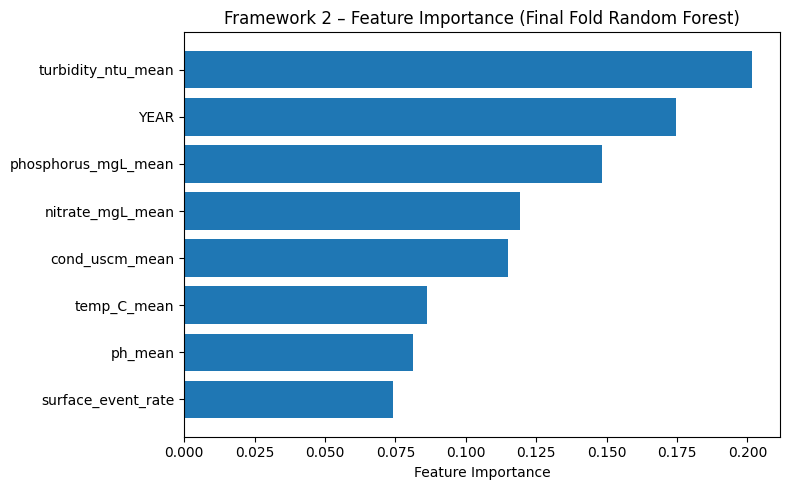

In [209]:
# --- Feature importance plot for Framework 2 yield model ---

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)  # smallest → largest

plt.figure(figsize=(8, 5))
plt.barh(
    [feature_cols[i] for i in sorted_idx],
    importances[sorted_idx]
)
plt.xlabel("Feature Importance")
plt.title("Framework 2 – Feature Importance (Final Fold Random Forest)")
plt.tight_layout()
plt.show()


####Exports

Yield panel shape (county-year, corn grain): (415, 5)
y_yield
2    141
1    137
0    137
Name: count, dtype: int64
Annual water-quality table: (114, 8)
Feature columns: ['YEAR', 'temp_C_mean', 'turbidity_ntu_mean', 'ph_mean', 'cond_uscm_mean', 'nitrate_mgL_mean', 'phosphorus_mgL_mean', 'surface_event_rate']
Modeling dataset shape: (415, 8)
Class counts (0=Low,1=Med,2=High): [137 137 141]
Fold 1: RF F1=0.465, AUC=0.658  |  Dummy F1=0.168, AUC=0.500
Fold 2: RF F1=0.486, AUC=0.674  |  Dummy F1=0.168, AUC=0.500
Fold 3: RF F1=0.540, AUC=0.690  |  Dummy F1=0.173, AUC=0.500
Fold 4: RF F1=0.516, AUC=0.704  |  Dummy F1=0.168, AUC=0.500
Fold 5: RF F1=0.554, AUC=0.718  |  Dummy F1=0.168, AUC=0.500

--- Cross-validated performance (Yield model) ---
RF    Macro F1:  0.512 ± 0.033
RF    Macro AUC: 0.689 ± 0.021
Dummy Macro F1:  0.169 ± 0.002
Dummy Macro AUC: 0.500 ± 0.000
Export dir: framework2_model1_yield_exports


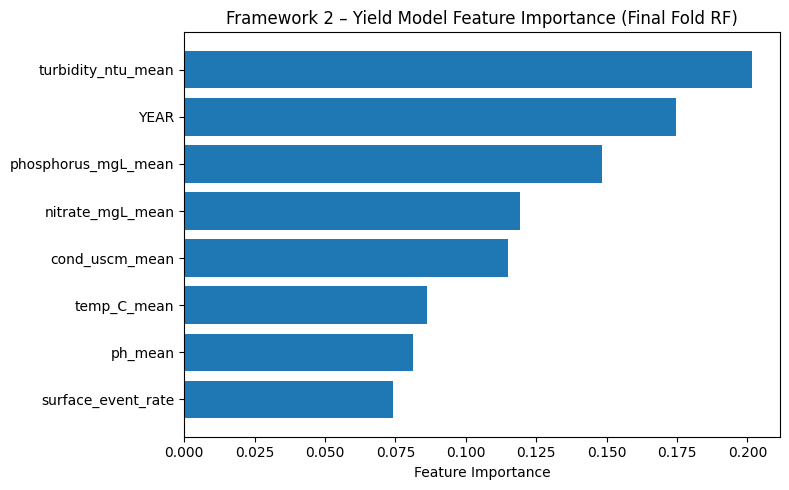

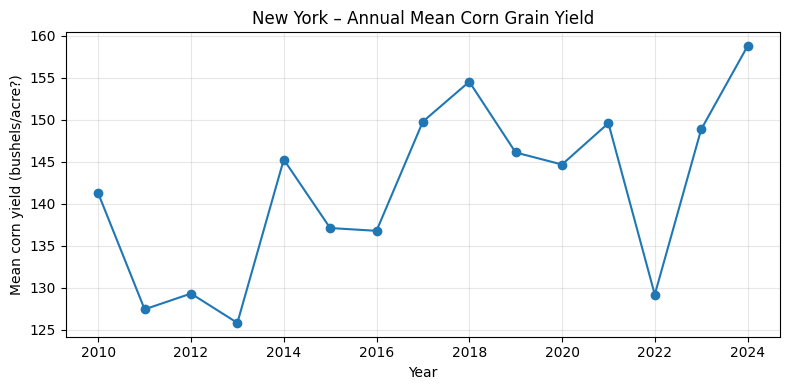

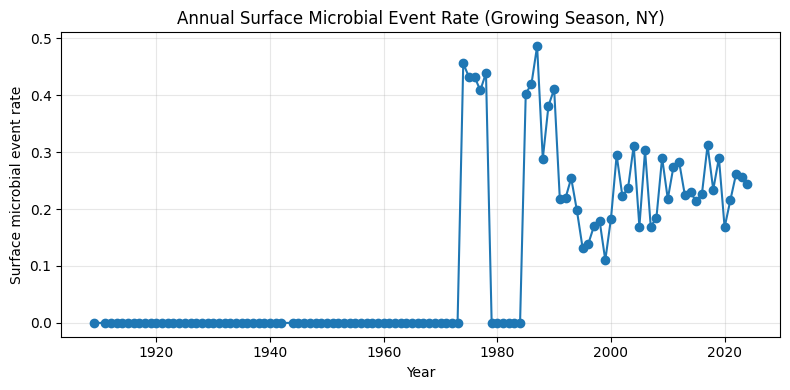

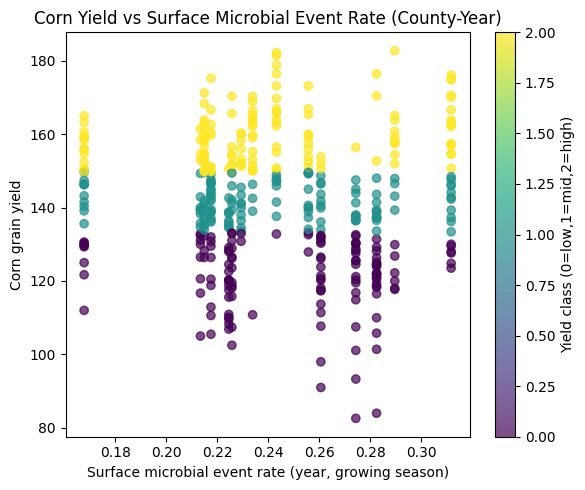

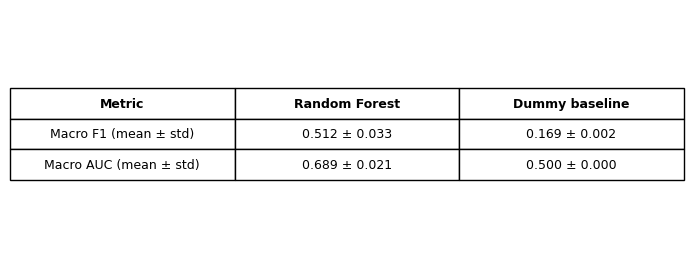

Created zip: framework2_model1_yield_bundle.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [210]:
from google.colab import files as colab_files  # avoid name clash


# ===== 2. Load USDA NASS & build corn grain yield panel =====

usda_path = DATA_ROOT / "USDA_NASS_Regional_Crop_Yield" / "USDA_Regional_Crop_Yield_Data.csv"

# Parse HTML table(s) from the saved file
usda_tables = pd.read_html(usda_path, header=0)
df_usda_raw = usda_tables[0]

df_y = df_usda_raw.copy()
df_y.columns = [c.upper() for c in df_y.columns]  # normalize

# NY + county
mask = (
    (df_y["STATE"].str.upper() == "NEW YORK") &
    (df_y["GEO LEVEL"].str.upper() == "COUNTY")
)
df_y = df_y.loc[mask].copy()

# Clean numeric VALUE
df_y["VALUE_NUM"] = (
    df_y["VALUE"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({
        "(D)": np.nan, "(L)": np.nan, "(Z)": np.nan,
        "(NA)": np.nan, "": np.nan
    })
)
df_y["VALUE_NUM"] = pd.to_numeric(df_y["VALUE_NUM"], errors="coerce")
df_y = df_y.dropna(subset=["VALUE_NUM"]).copy()

# Corn only
target_commodity = "CORN"
corn = df_y[df_y["COMMODITY"] == target_commodity].copy()
corn["YEAR"] = pd.to_numeric(corn["YEAR"], errors="coerce")
corn = corn.dropna(subset=["YEAR"]).copy()
corn["YEAR"] = corn["YEAR"].astype(int)

# Only rows with YIELD in DATA ITEM
yield_rows = corn[corn["DATA ITEM"].str.contains("YIELD", case=False, na=False)].copy()

def simplify_corn_item(s):
    s = str(s).upper()
    if "GRAIN" in s and "YIELD" in s:
        return "GRAIN_YIELD"
    if "SILAGE" in s and "YIELD" in s:
        return "SILAGE_YIELD"
    return "OTHER_YIELD"

yield_rows["DATA_ITEM_SIMPLE"] = yield_rows["DATA ITEM"].apply(simplify_corn_item)

# Prefer grain yield if available
if (yield_rows["DATA_ITEM_SIMPLE"] == "GRAIN_YIELD").any():
    yield_rows = yield_rows[yield_rows["DATA_ITEM_SIMPLE"] == "GRAIN_YIELD"].copy()

# Aggregate to one yield per (YEAR, COUNTY)
yield_panel = (
    yield_rows
    .groupby(["YEAR", "COUNTY", "COMMODITY"], as_index=False)["VALUE_NUM"]
    .mean()
)

# Clean county names
yield_panel["COUNTY_NAME"] = (
    yield_panel["COUNTY"]
    .astype(str)
    .str.upper()
    .str.replace(" COUNTY", "", regex=False)
    .str.strip()
)

yield_panel = yield_panel.rename(columns={"VALUE_NUM": "YIELD"})
panel = yield_panel[["YEAR", "COUNTY_NAME", "COMMODITY", "YIELD"]].copy()
panel = panel.dropna(subset=["YIELD"]).copy()

# Tertile-based yield classes
q = panel["YIELD"].quantile([0.33, 0.66])
q_low, q_high = q.loc[0.33], q.loc[0.66]

def categorize_yield(v):
    if v < q_low:
        return 0
    elif v < q_high:
        return 1
    else:
        return 2

panel["y_yield"] = panel["YIELD"].apply(categorize_yield)

print("Yield panel shape (county-year, corn grain):", panel.shape)
print(panel["y_yield"].value_counts())


# ===== 3. Build annual surface water quality features (Framework 2 surf table) =====

surf = surface_unified_monthly.copy()  # assumes already defined
surf["year"] = surf["month_start"].dt.year
surf["month_num"] = surf["month_start"].dt.month

# Growing season only (Apr–Sep)
growing = surf[surf["month_num"].between(4, 9)].copy()

wq_feature_cols = [
    "temp_C_mean",
    "turbidity_ntu_mean",
    "ph_mean",
    "cond_uscm_mean",
    "nitrate_mgL_mean",
    "phosphorus_mgL_mean",
    "y_surface",  # event rate
]
wq_feature_cols = [c for c in wq_feature_cols if c in growing.columns]

annual_wq = (
    growing
    .groupby("year")[wq_feature_cols]
    .mean()
    .rename(columns={"y_surface": "surface_event_rate"})
    .reset_index()
)

print("Annual water-quality table:", annual_wq.shape)


# ===== 4. Modeling dataframe: join yield + WQ, build features =====

panel["YEAR"] = panel["YEAR"].astype(int)
annual_wq["year"] = annual_wq["year"].astype(int)

model_df = panel.merge(
    annual_wq,
    left_on="YEAR",
    right_on="year",
    how="left"
)

if "year" in model_df.columns:
    model_df = model_df.drop(columns=["year"])

feature_cols_wq = [c for c in annual_wq.columns if c != "year"]
feature_cols_wq = [c for c in feature_cols_wq if c in model_df.columns]
feature_cols = ["YEAR"] + feature_cols_wq

print("Feature columns:", feature_cols)

model_use = model_df.dropna(subset=["y_yield"]).copy()
model_use = model_use.dropna(subset=feature_cols, how="all").copy()

X = model_use[feature_cols].values
y = model_use["y_yield"].astype(int).values

print("Modeling dataset shape:", X.shape)
print("Class counts (0=Low,1=Med,2=High):", np.bincount(y))


# ===== 5. Model training: RF vs Dummy, 5-fold CV =====

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_rf, f1_dummy = [], []
auc_rf, auc_dummy = [], []

fold = 0
for train_idx, test_idx in skf.split(X, y):
    fold += 1
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # Dummy baseline
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_tr, y_tr)
    y_dummy_pred = dummy.predict(X_te)
    y_dummy_proba = dummy.predict_proba(X_te)

    f1_d = f1_score(y_te, y_dummy_pred, average="macro")
    y_te_onehot = pd.get_dummies(y_te)
    auc_d = roc_auc_score(
        y_te_onehot, y_dummy_proba,
        average="macro", multi_class="ovr"
    )

    f1_dummy.append(f1_d)
    auc_dummy.append(auc_d)

    # RandomForest
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_tr, y_tr)
    y_rf_pred = rf.predict(X_te)
    y_rf_proba = rf.predict_proba(X_te)

    f1_r = f1_score(y_te, y_rf_pred, average="macro")
    auc_r = roc_auc_score(
        y_te_onehot, y_rf_proba,
        average="macro", multi_class="ovr"
    )

    f1_rf.append(f1_r)
    auc_rf.append(auc_r)

    print(
        f"Fold {fold}: "
        f"RF F1={f1_r:.3f}, AUC={auc_r:.3f}  |  "
        f"Dummy F1={f1_d:.3f}, AUC={auc_d:.3f}"
    )

print("\n--- Cross-validated performance (Yield model) ---")
print(f"RF    Macro F1:  {np.mean(f1_rf):.3f} ± {np.std(f1_rf):.3f}")
print(f"RF    Macro AUC: {np.mean(auc_rf):.3f} ± {np.std(auc_rf):.3f}")
print(f"Dummy Macro F1:  {np.mean(f1_dummy):.3f} ± {np.std(f1_dummy):.3f}")
print(f"Dummy Macro AUC: {np.mean(auc_dummy):.3f} ± {np.std(auc_dummy):.3f}")

summary_yield = {
    "rf_macro_f1_mean": float(np.mean(f1_rf)),
    "rf_macro_f1_std":  float(np.std(f1_rf)),
    "rf_macro_auc_mean": float(np.mean(auc_rf)),
    "rf_macro_auc_std":  float(np.std(auc_rf)),
    "dummy_macro_f1_mean": float(np.mean(f1_dummy)),
    "dummy_macro_f1_std":  float(np.std(f1_dummy)),
    "dummy_macro_auc_mean": float(np.mean(auc_dummy)),
    "dummy_macro_auc_std":  float(np.std(auc_dummy)),
    "class_counts": np.bincount(y).tolist(),
    "n_samples": int(len(y)),
    "n_splits": 5,
}

# Feature importance (last RF)
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)


# ===== 6. Export directory =====
EXPORT_DIR = Path("framework2_model1_yield_exports")
EXPORT_DIR.mkdir(exist_ok=True)
print("Export dir:", EXPORT_DIR)


# ===== 7. PNG plots =====

# 7.1 Feature importance
plt.figure(figsize=(8, 5))
plt.barh(
    [feature_cols[i] for i in sorted_idx],
    importances[sorted_idx]
)
plt.xlabel("Feature Importance")
plt.title("Framework 2 – Yield Model Feature Importance (Final Fold RF)")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "feature_importance_yield_model.png", dpi=300)
plt.show()

# 7.2 Annual mean yield (state-level)
annual_yield = (
    panel.groupby("YEAR")["YIELD"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(annual_yield["YEAR"], annual_yield["YIELD"], marker="o")
plt.xlabel("Year")
plt.ylabel("Mean corn yield (bushels/acre?)")
plt.title("New York – Annual Mean Corn Grain Yield")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(EXPORT_DIR / "annual_mean_corn_yield.png", dpi=300)
plt.show()

# 7.3 Annual surface event rate (from annual_wq)
plt.figure(figsize=(8,4))
plt.plot(annual_wq["year"], annual_wq["surface_event_rate"], marker="o")
plt.xlabel("Year")
plt.ylabel("Surface microbial event rate")
plt.title("Annual Surface Microbial Event Rate (Growing Season, NY)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(EXPORT_DIR / "annual_surface_event_rate.png", dpi=300)
plt.show()

# 7.4 Scatter: yield vs surface event rate (county-year)
scatter_df = model_use.dropna(subset=["YIELD", "surface_event_rate"]).copy()

plt.figure(figsize=(6,5))
sc = plt.scatter(
    scatter_df["surface_event_rate"],
    scatter_df["YIELD"],
    c=scatter_df["y_yield"],
    cmap="viridis",
    alpha=0.7
)
plt.xlabel("Surface microbial event rate (year, growing season)")
plt.ylabel("Corn grain yield")
plt.title("Corn Yield vs Surface Microbial Event Rate (County-Year)")
plt.colorbar(sc, label="Yield class (0=low,1=mid,2=high)")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "scatter_yield_vs_surface_event_rate.png", dpi=300)
plt.show()


# ===== 8. Training results table: CSV + PNG + JSON =====

results_table = pd.DataFrame(
    {
        "Metric": [
            "Macro F1 (mean ± std)",
            "Macro AUC (mean ± std)",
        ],
        "Random Forest": [
            f"{summary_yield['rf_macro_f1_mean']:.3f} ± {summary_yield['rf_macro_f1_std']:.3f}",
            f"{summary_yield['rf_macro_auc_mean']:.3f} ± {summary_yield['rf_macro_auc_std']:.3f}",
        ],
        "Dummy baseline": [
            f"{summary_yield['dummy_macro_f1_mean']:.3f} ± {summary_yield['dummy_macro_f1_std']:.3f}",
            f"{summary_yield['dummy_macro_auc_mean']:.3f} ± {summary_yield['dummy_macro_auc_std']:.3f}",
        ],
    }
)

# CSV
results_table.to_csv(EXPORT_DIR / "model1_yield_training_results_table.csv", index=False)

# PNG pretty table
fig, ax = plt.subplots(figsize=(7, 2.8))
ax.axis("off")

table_data = [results_table.columns.tolist()] + results_table.values.tolist()
table = ax.table(
    cellText=table_data,
    loc="center",
    cellLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.6)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")

fig.tight_layout()
fig.savefig(EXPORT_DIR / "model1_yield_training_results_table.png", dpi=300, bbox_inches="tight")
plt.show()

# Raw JSON summary
with open(EXPORT_DIR / "model1_yield_training_results.json", "w") as f:
    json.dump(summary_yield, f, indent=2)


# ===== 9. Graph series JSON for re-creation =====

graphs_json = {}

graphs_json["annual_mean_corn_yield"] = {
    "year": annual_yield["YEAR"].astype(int).tolist(),
    "mean_yield": annual_yield["YIELD"].tolist(),
    "title": "New York – Annual Mean Corn Grain Yield",
    "y_label": "Mean yield",
}

graphs_json["annual_surface_event_rate"] = {
    "year": annual_wq["year"].astype(int).tolist(),
    "surface_event_rate": annual_wq["surface_event_rate"].tolist(),
    "title": "Annual Surface Microbial Event Rate (Growing Season, NY)",
    "y_label": "Surface event rate",
}

graphs_json["yield_vs_surface_event_rate"] = {
    "surface_event_rate": scatter_df["surface_event_rate"].tolist(),
    "yield": scatter_df["YIELD"].tolist(),
    "yield_class": scatter_df["y_yield"].astype(int).tolist(),
    "title": "Corn Yield vs Surface Microbial Event Rate (County-Year)",
    "x_label": "Surface microbial event rate",
    "y_label": "Corn grain yield",
}

with open(EXPORT_DIR / "framework2_model1_yield_graph_data.json", "w") as f:
    json.dump(graphs_json, f, indent=2)


# ===== 10. Zip everything & download =====

zip_path = "framework2_model1_yield_bundle.zip"

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, filenames in os.walk(EXPORT_DIR):
        for fname in filenames:
            full_path = Path(root) / fname
            rel_path = full_path.relative_to(EXPORT_DIR)
            zf.write(full_path, arcname=rel_path)

print("Created zip:", zip_path)
colab_files.download(zip_path)

###Model 2

In [211]:
def build_annual_numeric_panel(df, date_col, prefix):
    """
    Generic helper: take a water-quality dataframe with a date column,
    compute annual means of all numeric columns, prefix their names,
    and return a tidy (year, features...) table.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df["year"] = df[date_col].dt.year

    # Keep only numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if "year" not in num_cols:
        num_cols = ["year"] + num_cols

    annual = (
        df[num_cols]
        .groupby("year")
        .mean()
        .reset_index()
    )

    # Prefix feature columns (but not 'year')
    new_cols = ["year"] + [f"{prefix}{c}" for c in annual.columns if c != "year"]
    annual.columns = new_cols

    return annual

In [212]:
ws_path = DATA_ROOT / "NYC_DEP_Watershed_WQ" / "Watershed_Water_Quality_Data.csv"
ws_raw = pd.read_csv(ws_path, low_memory=False)
print("Watershed WQ shape:", ws_raw.shape)
print(ws_raw.columns[:20])

# Try common date column names – adjust if needed once you see the printout
candidate_dates = ["sample_date", "SampleDate", "SAMPLE_DATE", "date", "DATE"]
date_col = None
for c in candidate_dates:
    if c in ws_raw.columns:
        date_col = c
        break

if date_col is None:
    raise ValueError("Could not find a date column in Watershed WQ; adjust candidate_dates manually.")

ws_annual = build_annual_numeric_panel(ws_raw, date_col=date_col, prefix="ws_")
print("Watershed annual panel:", ws_annual.shape)
ws_annual.head()

Watershed WQ shape: (4047, 10)
Index(['site', 'date', 'turbidity_ntu_at_12am', 'turbidity_ntu_at_4am',
       'turbidity_ntu_at_8am', 'turbidity_ntu_at_12pm', 'turbidity_ntu_at_4pm',
       'turbidity_ntu_at_8pm', 'average_24hrturbidity_ntu',
       'coliform_fecal_fc_100ml'],
      dtype='object')
Watershed annual panel: (11, 8)


year  ws_turbidity_ntu_at_12am  ws_turbidity_ntu_at_4am  \
0  2015                  0.759363                 0.761070   
1  2016                  0.779672                 0.775567   
2  2017                  0.771646                 0.770202   
3  2018                  0.830153                 0.826523   
4  2019                  0.726452                 0.722671   

   ws_turbidity_ntu_at_8am  ws_turbidity_ntu_at_12pm  ws_turbidity_ntu_at_4pm  \
0                 0.769815                  0.750000                 0.752602   
1                 0.777708                  0.769924                 0.785443   
2                 0.769066                  0.775190                 0.765823   
3                 0.825127                  0.822265                 0.831934   
4                 0.733162                  0.725773                 0.728351   

   ws_turbidity_ntu_at_8pm  ws_average_24hrturbidity_ntu  
0                 0.765056                      0.760406  
1                 0.785823                      0.780000  
2                 0.768734                      0.770859  
3                 0.836768                      0.829949  
4                 0.729485                      0.728686

In [213]:
pb20_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2020" / "LIPineBarrens_2020_DataRelease.xlsx"
pb21_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2021" / "LIPineBarrens_2021_DataRelease.xlsx"
pb22_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2022" / "LIPineBarrens_2022_DataRelease.xlsx"

xl20 = pd.ExcelFile(pb20_xlsx)
xl21 = pd.ExcelFile(pb21_xlsx)
xl22 = pd.ExcelFile(pb22_xlsx)

print("Pine Barrens 2020 sheet names:", xl20.sheet_names)
print("Pine Barrens 2021 sheet names:", xl21.sheet_names)
print("Pine Barrens 2022 sheet names:", xl22.sheet_names)

Pine Barrens 2020 sheet names: ['TOC', 'Site List', 'References', 'Analyte List', 'Field', 'Nutrients', 'Inorganics', 'Pesticides', 'Pesticide Field-Spike', 'Pharmaceuticals', 'GW levels', 'GW levels recorder']
Pine Barrens 2021 sheet names: ['TOC', 'Site List', 'References', 'Analyte List', 'Field', 'Nutrients', 'Inorganics', 'Pesticides', 'Pharmaceuticals', 'GW levels', 'GW levels, recorder']
Pine Barrens 2022 sheet names: ['TOC', 'Site List', 'References', 'Analyte List', 'Field', 'Nutrients', 'Inorganics', 'Pesticides', 'Pesticide Field-Spike', 'Pharmaceuticals', 'GW levels', 'GW levels, recorder']


In [214]:
pb20_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2020" / "LIPineBarrens_2020_DataRelease.xlsx"

df_raw = pd.read_excel(pb20_xlsx, sheet_name="Field", header=None)
df_raw.head(40)

0   \
0   Citation: Bayraktar, B.N., Fisher, I.J., and S...   
1   Field data collected during the time of sample...   
2                                 USGS Station Number   
3                                                 NaN   
4                                            01304440   
5                                            01304440   
6                                            01304500   
7                                            01304500   
8                                            01304990   
9                                            01304990   
10                                           01304990   
11                                           01304990   
12                                           01304995   
13                                           01304995   
14                                           01304995   
15                                           01304995   
16                                           01304998   
17                                           01304998   
18                                           01304998   
19                                           01304998   
20                                           01305000   
21                                           01305000   
22                                           01305000   
23                                           01305000   
24                                           01305040   
25                                           01305040   
26                                           01305040   
27                                           01305040   

                                              1                2   \
0                                            NaN              NaN   
1                                            NaN              NaN   
2                              USGS Station Name       Field Name   
3                                            NaN              NaN   
4                PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
5                PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
6                  PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
7                  PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
8              CARMANS RIVER AT MIDDLE ISLAND NY         Bartlett   
9              CARMANS RIVER AT MIDDLE ISLAND NY         Bartlett   
10             CARMANS RIVER AT MIDDLE ISLAND NY         Bartlett   
11             CARMANS RIVER AT MIDDLE ISLAND NY         Bartlett   
12                 CARMANS RIVER NEAR YAPHANK NY       Upper Lake   
13                 CARMANS RIVER NEAR YAPHANK NY       Upper Lake   
14                 CARMANS RIVER NEAR YAPHANK NY       Upper Lake   
15                 CARMANS RIVER NEAR YAPHANK NY       Upper Lake   
16  CARMANS RIVER BELOW LOWER LAKE AT YAPHANK NY       Lower Lake   
17  CARMANS RIVER BELOW LOWER LAKE AT YAPHANK NY       Lower Lake   
18  CARMANS RIVER BELOW LOWER LAKE AT YAPHANK NY       Lower Lake   
19  CARMANS RIVER BELOW LOWER LAKE AT YAPHANK NY       Lower Lake   
20                   CARMANS RIVER AT YAPHANK NY     Carmans Gage   
21                   CARMANS RIVER AT YAPHANK NY     Carmans Gage   
22                   CARMANS RIVER AT YAPHANK NY     Carmans Gage   
23                   CARMANS RIVER AT YAPHANK NY     Carmans Gage   
24                CARMANS RIVER AT SOUTHHAVEN NY            Tidal   
25                CARMANS RIVER AT SOUTHHAVEN NY            Tidal   
26                CARMANS RIVER AT SOUTHHAVEN NY            Tidal   
27                CARMANS RIVER AT SOUTHHAVEN NY            Tidal   

                     3                4                 5               6   \
0                   NaN              NaN               NaN             NaN   
1                   NaN              NaN               NaN             NaN   
2           Sample Date  Air temperature  Dissolved oxygen              pH   
3                   NaN  degrees celsius              mg/L  standard units   
4   2

In [215]:
def load_pine_sheet(xlsx_path, sheet_name):
    # Skip metadata rows (0,1) and the units row (3)
    df = pd.read_excel(
        xlsx_path,
        sheet_name=sheet_name,
        skiprows=[0, 1, 3]
    )
    return df

pb20_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2020" / "LIPineBarrens_2020_DataRelease.xlsx"
pb21_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2021" / "LIPineBarrens_2021_DataRelease.xlsx"
pb22_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2022" / "LIPineBarrens_2022_DataRelease.xlsx"

# Load "Field" sheet for all years
pb20_field = load_pine_sheet(pb20_xlsx, "Field")
pb21_field = load_pine_sheet(pb21_xlsx, "Field")
pb22_field = load_pine_sheet(pb22_xlsx, "Field")

pb20_field.head()

USGS Station Number                  USGS Station Name       Field Name  \
0              1304440    PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
1              1304440    PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
2              1304500      PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
3              1304500      PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
4              1304990  CARMANS RIVER AT MIDDLE ISLAND NY         Bartlett   

  Sample Date Air temperature  Dissolved oxygen   pH  Specific conductance  \
0  2019-11-04              --               9.2  6.4                    72   
1  2020-06-02            21.6               6.6  6.6                    90   
2  2019-11-04            14.4              10.2  6.7                   170   
3  2020-06-02              20               8.2  6.7                   163   
4  2019-11-05            14.4               5.9  6.0                   150   

   Water temperature  Turbidity Stream Width Velocity Water Depth  
0                9.9        5.4           22     1.67          --  
1               19.6        3.6           20     0.62         0.6  
2               10.8        0.9           61      1.1          --  
3               20.1        1.3           60     0.88           1  
4                8.6        1.0            6       --         0.9

In [216]:
def build_annual_numeric_panel(df, date_col, prefix):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year

    # keep only numeric columns + year
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if "year" not in num_cols:
        num_cols = ["year"] + num_cols

    annual = (
        df[num_cols]
        .groupby("year")
        .mean()
        .reset_index()
    )

    new_cols = ["year"] + [
        f"{prefix}{c}" for c in annual.columns if c != "year"
    ]
    annual.columns = new_cols

    return annual

In [217]:
pb20_field_annual = build_annual_numeric_panel(
    pb20_field,
    date_col="Sample Date",
    prefix="pine20_field_"
)

pb21_field_annual = build_annual_numeric_panel(
    pb21_field,
    date_col="Sample Date",
    prefix="pine21_field_"
)

pb22_field_annual = build_annual_numeric_panel(
    pb22_field,
    date_col="Sample Date",
    prefix="pine22_field_"
)


pb20_field_annual, pb21_field_annual, pb22_field_annual

(   year  pine20_field_USGS Station Number  pine20_field_Dissolved oxygen  \
 0  2019                      1.304852e+06                       9.400000   
 1  2020                      1.304942e+06                       9.188235   
 
    pine20_field_pH  pine20_field_Specific conductance  \
 0         6.600000                         171.571429   
 1         6.641176                         187.000000   
 
    pine20_field_Water temperature  pine20_field_Turbidity  
 0                       10.157143                1.942857  
 1                       15.782353                1.282353  ,
    year  pine21_field_USGS Station Number
 0  2020                      1.304852e+06
 1  2021                      1.304942e+06,
    year  pine22_field_USGS Station Number  pine22_field_Air temperature  \
 0  2021                      1.304852e+06                     12.142857   
 1  2022                      1.304942e+06                     23.029412   
 
    pine22_field_Dissolved oxygen  pine22_field

In [218]:
# Load all major Pine Barrens sheets for 2020–2022

pine_sheets = ["Nutrients", "Inorganics", "Pesticides", "Pharmaceuticals", "GW levels"]

pb20_all = {}
pb21_all = {}
pb22_all = {}

for sh in pine_sheets:
    pb20_all[sh] = load_pine_sheet(pb20_xlsx, sh)
    pb21_all[sh] = load_pine_sheet(pb21_xlsx, sh)
    pb22_all[sh] = load_pine_sheet(pb22_xlsx, sh)

# Peek at the columns to confirm
for sh in pine_sheets:
    print(f"\n--- Pine 2020 {sh} columns ---")
    print(pb20_all[sh].columns.tolist()[:20])



--- Pine 2020 Nutrients columns ---
['USGS Station Number', 'USGS Station Name', 'Field Name', 'Sample Date', 'Notes', 'Ammonia (NH3 + NH4+)', 'Nitrate plus nitrite', 'Nitrite', 'Orthophosphate', 'Phosphorus', 'Phosphorus, unfiltered', 'Total nitrogen', 'Total nitrogen, unfiltered']

--- Pine 2020 Inorganics columns ---
['USGS Station Number', 'USGS Station Name', 'Field Name', 'Sample Date', 'Notes', 'Alkalinity', 'Aluminum', 'Antimony', 'Arsenic', 'Barium', 'Beryllium', 'Boron', 'Bromide', 'Cadmium', 'Calcium', 'Chloride', 'Chromium', 'Cobalt', 'Copper', 'Dissolved solids']

--- Pine 2020 Pesticides columns ---
['USGS Station Number', 'USGS Station Name', 'Field Name', 'Sample Date', 'Notes', '1H-1,2,4-Triazole', '2-(1-Hydroxyethyl)-6-methylaniline', '2,4-D', '2-[(2-Ethyl-6-methylphenyl)amino]-1-propanol', '2-Aminobenzimidazole', '2-Amino-N-isopropylbenzamide', "2-Chloro-2',6'-diethylacetanilide", '2-Chloro-4-isopropylamino-6-amino-s-triazine', '2-Chloro-6-ethylamino-4-amino-s-triaz

In [219]:
# --- Load all Pine sheets for 2020–2022 with correct skiprows ---

pine_sheets = ["Field", "Nutrients", "Inorganics", "Pesticides", "Pharmaceuticals", "GW levels"]

def load_pine_sheet(xlsx_path, sheet_name):
    # Skip metadata rows (0,1) and the units row (3)
    return pd.read_excel(
        xlsx_path,
        sheet_name=sheet_name,
        skiprows=[0, 1, 3]
    )

pb20_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2020" / "LIPineBarrens_2020_DataRelease.xlsx"
pb21_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2021" / "LIPineBarrens_2021_DataRelease.xlsx"
pb22_xlsx = DATA_ROOT / "USGS_LI_PineBarrens_2022" / "LIPineBarrens_2022_DataRelease.xlsx"

pb20 = {sh: load_pine_sheet(pb20_xlsx, sh) for sh in pine_sheets}
pb21 = {sh: load_pine_sheet(pb21_xlsx, sh) for sh in pine_sheets}
pb22 = {sh: load_pine_sheet(pb22_xlsx, sh) for sh in pine_sheets}

for sh in pine_sheets:
    print(f"\nPine 2020 {sh} head:")
    display(pb20[sh].head())



Pine 2020 Field head:


USGS Station Number                  USGS Station Name       Field Name  \
0              1304440    PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
1              1304440    PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
2              1304500      PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
3              1304500      PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
4              1304990  CARMANS RIVER AT MIDDLE ISLAND NY         Bartlett   

  Sample Date Air temperature  Dissolved oxygen   pH  Specific conductance  \
0  2019-11-04              --               9.2  6.4                    72   
1  2020-06-02            21.6               6.6  6.6                    90   
2  2019-11-04            14.4              10.2  6.7                   170   
3  2020-06-02              20               8.2  6.7                   163   
4  2019-11-05            14.4               5.9  6.0                   150   

   Water temperature  Turbidity Stream Width Velocity Water Depth  
0                9.9        5.4           22     1.67          --  
1               19.6        3.6           20     0.62         0.6  
2               10.8        0.9           61      1.1          --  
3               20.1        1.3           60     0.88           1  
4                8.6        1.0            6       --         0.9


Pine 2020 Nutrients head:


USGS Station Number                  USGS Station Name       Field Name  \
0              1304440    PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
1              1304440    PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
2              1304500      PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
3              1304500      PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
4              1304990  CARMANS RIVER AT MIDDLE ISLAND NY         Bartlett   

  Sample Date Notes Ammonia (NH3 + NH4+) Nitrate plus nitrite Nitrite  \
0  2019-11-04   NaN                 0.04                <0.01   0.002   
1  2020-06-02   NaN                 0.03                 0.01  <0.001   
2  2019-11-04   NaN                 0.02                 0.21   0.003   
3  2020-06-02   NaN                 0.04                 0.12   0.005   
4  2019-11-05   NaN                 0.02                 0.38   0.002   

  Orthophosphate Phosphorus Phosphorus, unfiltered Total nitrogen  \
0          0.009      0.019                  0.057           0.45   
1          0.037      0.068                  0.118           0.71   
2           0.01      0.017                  0.034           0.44   
3          0.027      0.041                  0.071           0.45   
4         <0.004      0.006                   0.01           0.52   

  Total nitrogen, unfiltered  
0                       0.65  
1                        0.9  
2                       0.43  
3                       0.52  
4                       0.55


Pine 2020 Inorganics head:


USGS Station Number                  USGS Station Name       Field Name  \
0              1304440    PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
1              1304440    PECONIC RIVER NEAR CALVERTON NY  Connecticut Ave   
2              1304500      PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
3              1304500      PECONIC RIVER AT RIVERHEAD NY     Peconic Gage   
4              1304990  CARMANS RIVER AT MIDDLE ISLAND NY         Bartlett   

  Sample Date Notes Alkalinity Aluminum Antimony Arsenic Barium  ... Selenium  \
0  2019-11-04   NaN        7.4       77    0.113    0.76   10.1  ...     0.06   
1  2020-06-02   NaN       18.4       89    0.214     2.2   14.5  ...      0.1   
2  2019-11-04   NaN       19.4        8   <0.060    0.35   17.8  ...    <0.05   
3  2020-06-02   NaN       21.1       19     0.08    0.77   20.2  ...    <0.05   
4  2019-11-05   NaN       14.1       43     0.06   <0.10   34.5  ...     0.06   

  Silica Silver Sodium Strontium Sulfate Thallium Uranium Vanadium  Zinc  
0   9.58  <1.00   8.57      15.9    4.59   <0.040  <0.030     0.79   3.4  
1   7.87  <1.00   9.13      31.8    1.91   <0.040  <0.030      1.4   3.6  
2   5.14  <1.00   19.4        38     9.4   <0.040  <0.030     0.18  <2.0  
3   4.84  <1.00   16.8      33.5    8.43   <0.040  <0.030     0.46  <2.0  
4   9.88  <1.00   17.4      33.1    9.34   <0.040  <0.030     0.17   2.7  

[5 rows x 39 columns]


Pine 2020 Pesticides head:


USGS Station Number                        USGS Station Name  \
0              1304440         PECONIC RIVER NEAR CALVERTON, NY   
1              1304500            PECONIC RIVER AT RIVERHEAD NY   
2              1305000              CARMANS RIVER AT YAPHANK NY   
3              1305000              CARMANS RIVER AT YAPHANK NY   
4      405000073000023  QA--CHURN SAMPLE SPLITTER, 8 LITER PTFE   

              Field Name Sample Date            Notes 1H-1,2,4-Triazole  \
0        Connecticut Ave  2019-11-04              NaN              <200   
1           Peconic Gage  2019-11-04              NaN              <200   
2           Carmans Gage  2019-11-06              NaN              <200   
3           Carmans Gage  2019-11-06        Replicate              <200   
4  8 Liter churn sampler  2019-08-05  Equipment Blank             <40.0   

  2-(1-Hydroxyethyl)-6-methylaniline  2,4-D  \
0                             <1,000   <250   
1                             <1,000   <250   
2                             <1,000   <250   
3                             <1,000   <250   
4                             <1,000  <62.0   

  2-[(2-Ethyl-6-methylphenyl)amino]-1-propanol 2-Aminobenzimidazole  ...  \
0                                        <5.00                <9.00  ...   
1                                        <5.00                <9.00  ...   
2                                        <5.00                <9.00  ...   
3                                        <5.00                <9.00  ...   
4                                        <10.0                <9.00  ...   

  Diflubenzuron-d4 (4-chlorophenyl-d4) Dimethachlor sulfonic acid Diuron-d6  \
0                                101.0                       97.3     101.0   
1                                 99.1                      104.0      98.1   
2                                101.0                      113.0      95.1   
3                                102.0                      107.0      91.3   
4                                108.0                      103.0     100.0   

  Hexazinone-d6 (N,N-dimethyl-d6) Linuron-d6 (dimethyl-d6)  \
0                           101.0                    106.0   
1                            97.1                    105.0   
2                           101.0                     98.4   
3                            94.7                     94.1   
4                            99.9                     99.2   

  Malathion-d10 (diethyl-d10) Metolachlor-d6 Nicosulfuron-d6 (dimethoxy-d6)  \
0                        93.8            101                          108.0   
1                        97.3            101                           99.4   
2                        93.6            100                           96.5   
3                        90.5             95                           92.6   
4                        84.0            100                           93.5   

  Tebuconazole-d6 Thiobencarb-d10 (diethyl-d10)  
0            99.5                         102.0  
1           102.0                         101.0  
2            86.5                          92.6  
3            94.9                          95.5  
4            88.1                         107.0  

[5 rows x 243 columns]


Pine 2020 Pharmaceuticals head:


USGS Station Number                        USGS Station Name  \
0              1304440         PECONIC RIVER NEAR CALVERTON, NY   
1              1304500            PECONIC RIVER AT RIVERHEAD NY   
2              1305000              CARMANS RIVER AT YAPHANK NY   
3              1305000              CARMANS RIVER AT YAPHANK NY   
4      405000073000023  QA--CHURN SAMPLE SPLITTER, 8 LITER PTFE   

              Field Name SamplEDate            Notes 1,7-Dimethylxanthine  \
0        Connecticut Ave 2019-11-04              NaN                <88.0   
1           Peconic Gage 2019-11-04              NaN                <88.0   
2           Carmans Gage 2019-11-06              NaN                <88.0   
3           Carmans Gage 2019-11-06        Replicate                <88.0   
4  8 Liter churn sampler 2019-08-05  Equipment Blank                 <200   

  10-Hydroxy-amitriptyline Abacavir Acetaminophen Acyclovir  ...  \
0                    <8.30    <2.00         <20.0     <80.0  ...   
1                    <8.30    <2.00         <20.0     <80.0  ...   
2                    <8.30    <2.00         <20.0     <80.0  ...   
3                    <8.30    <2.00         <20.0     <80.0  ...   
4                    <8.30    <2.00         <20.0     <22.0  ...   

  Pseudoephedrine-d3 Raloxifene-d10 Ranitidine-d6  \
0               90.8           35.6         E24.2   
1               95.9           90.4          E150   
2              102.0             50          E140   
3              100.0           73.7          E144   
4               89.5          E68.6         E11.5   

  Sulfamethoxazole-(phenyl-13C6) Tamoxifen-d5 Temazepam-d5 Thiabendazole-d4  \
0                          116.0        E37.6        104.0             90.4   
1                           99.5         E111         90.4             83.5   
2                           98.7        E52.5         95.3             90.8   
3                           97.7         E160         92.3             88.3   
4                           92.4        E72.5         86.4             80.2   

  Tiotropium-d3 Trimethoprim-d9 Verapamil-d6  
0          E106           113.0         30.7  
1         E70.2           104.0        151.0  
2          E168           107.0        115.0  
3         E78.0           103.0        153.0  
4         E31.3            91.8         65.2  

[5 rows x 159 columns]


Pine 2020 GW levels head:


USGS Station Number USGS Station Name       Date      Time  \
0      404915072531801       S  9129. 1  2019-11-29  08:17:00   
1      404915072531801       S  9129. 1  2020-01-13  10:30:00   
2      404915072531801       S  9129. 1  2020-02-19  11:32:00   
3      404915072531801       S  9129. 1  2020-06-19  09:46:00   
4      404915072531801       S  9129. 1  2020-07-17  09:09:00   

   Groundwater level by manual measurement Method of measurement  
0                                    14.45                     V  
1                                    14.73                     V  
2                                    14.48                     V  
3                                    14.30                     V  
4                                    14.39                     V

In [220]:
def find_date_col(df):
    """
    Try to find the first column that looks like a date column.
    e.g. 'Sample Date', 'SamplEDate', 'Date', etc.
    """
    for c in df.columns:
        cl = c.lower()
        if "date" in cl:
            return c
    raise ValueError(f"No date-like column found. Columns: {df.columns.tolist()}")

# Make sure this helper is defined once
def build_annual_numeric_panel(df, date_col, prefix):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year

    # keep only numeric columns + year
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if "year" not in num_cols:
        num_cols = ["year"] + num_cols

    annual = (
        df[num_cols]
        .groupby("year")
        .mean()
        .reset_index()
    )

    new_cols = ["year"] + [
        f"{prefix}{c}" for c in annual.columns if c != "year"
    ]
    annual.columns = new_cols

    return annual


# --- Build annual panels for each sheet + year ---

def build_pine_annual_all():
    panels = []

    # Field
    panels.append(build_annual_numeric_panel(pb20["Field"], "Sample Date", "pine20_field_"))
    panels.append(build_annual_numeric_panel(pb21["Field"], "Sample Date", "pine21_field_"))
    panels.append(build_annual_numeric_panel(pb22["Field"], "Sample Date", "pine22_field_"))

    # Nutrients
    panels.append(build_annual_numeric_panel(pb20["Nutrients"], "Sample Date", "pine20_nutr_"))
    panels.append(build_annual_numeric_panel(pb21["Nutrients"], "Sample Date", "pine21_nutr_"))
    panels.append(build_annual_numeric_panel(pb22["Nutrients"], "Sample Date", "pine22_nutr_"))

    # Inorganics
    panels.append(build_annual_numeric_panel(pb20["Inorganics"], "Sample Date", "pine20_inorg_"))
    panels.append(build_annual_numeric_panel(pb21["Inorganics"], "Sample Date", "pine21_inorg_"))
    panels.append(build_annual_numeric_panel(pb22["Inorganics"], "Sample Date", "pine22_inorg_"))

    # Pesticides
    panels.append(build_annual_numeric_panel(pb20["Pesticides"], "Sample Date", "pine20_pest_"))
    panels.append(build_annual_numeric_panel(pb21["Pesticides"], "Sample Date", "pine21_pest_"))
    panels.append(build_annual_numeric_panel(pb22["Pesticides"], "Sample Date", "pine22_pest_"))

    # Pharmaceuticals – use auto-detected date column for each year
    for df, prefix in [
        (pb20["Pharmaceuticals"], "pine20_pharm_"),
        (pb21["Pharmaceuticals"], "pine21_pharm_"),
        (pb22["Pharmaceuticals"], "pine22_pharm_"),
    ]:
        date_col = find_date_col(df)
        print(f"Using date column '{date_col}' for {prefix}")
        panels.append(build_annual_numeric_panel(df, date_col, prefix))

    # Groundwater levels
    panels.append(build_annual_numeric_panel(pb20["GW levels"], "Date", "pine20_gw_"))
    panels.append(build_annual_numeric_panel(pb21["GW levels"], "Date", "pine21_gw_"))
    panels.append(build_annual_numeric_panel(pb22["GW levels"], "Date", "pine22_gw_"))

    return panels

pine_panels = build_pine_annual_all()
pine_panels


Using date column 'SamplEDate' for pine20_pharm_
Using date column 'Sample Date' for pine21_pharm_
Using date column 'Sample Date' for pine22_pharm_


[   year  pine20_field_USGS Station Number  pine20_field_Dissolved oxygen  \
 0  2019                      1.304852e+06                       9.400000   
 1  2020                      1.304942e+06                       9.188235   
 
    pine20_field_pH  pine20_field_Specific conductance  \
 0         6.600000                         171.571429   
 1         6.641176                         187.000000   
 
    pine20_field_Water temperature  pine20_field_Turbidity  
 0                       10.157143                1.942857  
 1                       15.782353                1.282353  ,
    year  pine21_field_USGS Station Number
 0  2020                      1.304852e+06
 1  2021                      1.304942e+06,
    year  pine22_field_USGS Station Number  pine22_field_Air temperature  \
 0  2021                      1.304852e+06                     12.142857   
 1  2022                      1.304942e+06                     23.029412   
 
    pine22_field_Dissolved oxygen  pine22_field

In [221]:
# Merge all panels on 'year' using outer join (years 2019–2022 etc.)
pb_env_annual = reduce(
    lambda left, right: pd.merge(left, right, on="year", how="outer"),
    pine_panels
).sort_values("year")

print(pb_env_annual.shape)
pb_env_annual.head()

(4, 197)


year  pine20_field_USGS Station Number  pine20_field_Dissolved oxygen  \
0  2019                      1.304852e+06                       9.400000   
1  2020                      1.304942e+06                       9.188235   
2  2021                               NaN                            NaN   
3  2022                               NaN                            NaN   

   pine20_field_pH  pine20_field_Specific conductance  \
0         6.600000                         171.571429   
1         6.641176                         187.000000   
2              NaN                                NaN   
3              NaN                                NaN   

   pine20_field_Water temperature  pine20_field_Turbidity  \
0                       10.157143                1.942857   
1                       15.782353                1.282353   
2                             NaN                     NaN   
3                             NaN                     NaN   

   pine21_field_USGS Station Number  pine22_field_USGS Station Number  \
0                               NaN                               NaN   
1                      1.304852e+06                               NaN   
2                      1.304942e+06                      1.304852e+06   
3                               NaN                      1.304942e+06   

   pine22_field_Air temperature  ...  pine22_pharm_Pseudoephedrine-d3  \
0                           NaN  ...                              NaN   
1                           NaN  ...                              NaN   
2                     12.142857  ...                             98.9   
3                     23.029412  ...                             65.4   

   pine22_pharm_Temazepam-d5  pine22_pharm_Thiabendazole-d4  \
0                        NaN                            NaN   
1                        NaN                            NaN   
2                    101.675                           95.5   
3                    113.000                           94.0   

   pine22_pharm_Trimethoprim-d9  pine20_gw_USGS Station Number  \
0                           NaN                   4.052803e+14   
1                           NaN                   4.052495e+14   
2                         102.8                            NaN   
3                          80.6                            NaN   

   pine20_gw_Groundwater level by manual measurement  \
0                                          35.468333   
1                                          32.649677   
2                                                NaN   
3                                                NaN   

   pine21_gw_USGS Station Number  \
0                            NaN   
1                   4.052276e+14   
2                   4.052604e+14   
3                            NaN   

   pine21_gw_Groundwater level by manual measurement  \
0                                                NaN   
1                                          31.581333   
2                                          32.159348   
3                                                NaN   

   pine22_gw_USGS Station Number  \
0                            NaN   
1                            NaN   
2                   4.052312e+14   
3                   4.052483e+14   

   pine22_gw_Groundwater level by manual measurement  
0                                                NaN  
1                                                NaN  
2                                          29.189000  
3                                          29.718947  

[4 rows x 197 columns]

In [222]:
yield_env = panel.merge(
    pb_env_annual,
    left_on="YEAR",
    right_on="year",
    how="left"
).drop(columns=["year"])  # keep YEAR as the main year column

yield_env.head()

YEAR  COUNTY_NAME COMMODITY  YIELD  y_yield  \
0  2010       ALBANY      CORN  138.8        1   
1  2010     ALLEGANY      CORN  162.6        2   
2  2010       BROOME      CORN  160.5        2   
3  2010  CATTARAUGUS      CORN  146.6        1   
4  2010       CAYUGA      CORN  151.0        2   

   pine20_field_USGS Station Number  pine20_field_Dissolved oxygen  \
0                               NaN                            NaN   
1                               NaN                            NaN   
2                               NaN                            NaN   
3                               NaN                            NaN   
4                               NaN                            NaN   

   pine20_field_pH  pine20_field_Specific conductance  \
0              NaN                                NaN   
1              NaN                                NaN   
2              NaN                                NaN   
3              NaN                                NaN   
4              NaN                                NaN   

   pine20_field_Water temperature  ...  pine22_pharm_Pseudoephedrine-d3  \
0                             NaN  ...                              NaN   
1                             NaN  ...                              NaN   
2                             NaN  ...                              NaN   
3                             NaN  ...                              NaN   
4                             NaN  ...                              NaN   

   pine22_pharm_Temazepam-d5  pine22_pharm_Thiabendazole-d4  \
0                        NaN                            NaN   
1                        NaN                            NaN   
2                        NaN                            NaN   
3                        NaN                            NaN   
4                        NaN                            NaN   

   pine22_pharm_Trimethoprim-d9  pine20_gw_USGS Station Number  \
0                           NaN                            NaN   
1                           NaN                            NaN   
2                           NaN                            NaN   
3                           NaN                            NaN   
4                           NaN                            NaN   

   pine20_gw_Groundwater level by manual measurement  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   pine21_gw_USGS Station Number  \
0                            NaN   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   

   pine21_gw_Groundwater level by manual measurement  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   pine22_gw_USGS Station Number  \
0                            NaN   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   

   pine22_gw_Groundwater level by manual measurement  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  

[5 rows x 201 columns]

In [223]:
# All Pine feature columns (anything starting with 'pine')
pine_feature_cols = [c for c in yield_env.columns if c.startswith("pine")]

feature_cols_yield = pine_feature_cols

X = yield_env[feature_cols_yield]
y = yield_env["y_yield"]

# Drop rows where all Pine features are NaN
valid_idx = X.dropna(how="all").index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

print("Final dataset with Pine features:", X.shape)
y.value_counts(normalize=True)


Final dataset with Pine features: (117, 196)


y_yield
2    0.410256
0    0.307692
1    0.282051
Name: proportion, dtype: float64

####Model Training

In [224]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_rf, f1_dummy = [], []
auc_rf, auc_dummy = [], []

fold = 0
for train_idx, test_idx in skf.split(X, y):
    fold += 1
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # Dummy model
    dum = DummyClassifier(strategy="most_frequent")
    dum.fit(X_tr, y_tr)
    y_dum = dum.predict(X_te)

    f1_dummy.append(f1_score(y_te, y_dum, average="macro"))
    auc_dummy.append(roc_auc_score(y_te, dum.predict_proba(X_te), multi_class="ovr"))

    # RandomForest
    rf = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    )
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)
    y_prob = rf.predict_proba(X_te)

    f1_rf.append(f1_score(y_te, y_pred, average="macro"))
    auc_rf.append(roc_auc_score(y_te, y_prob, multi_class="ovr"))

    print(
        f"Fold {fold}: RF F1={f1_rf[-1]:.3f}, AUC={auc_rf[-1]:.3f}  |  "
        f"Dummy F1={f1_dummy[-1]:.3f}, AUC={auc_dummy[-1]:.3f}"
    )

print("\n--- Cross-validated performance (Yield + Pine) ---")
print(f"RF    Macro F1:  {np.mean(f1_rf):.3f} ± {np.std(f1_rf):.3f}")
print(f"RF    Macro AUC: {np.mean(auc_rf):.3f} ± {np.std(auc_rf):.3f}")
print(f"Dummy Macro F1:  {np.mean(f1_dummy):.3f} ± {np.std(f1_dummy):.3f}")
print(f"Dummy Macro AUC: {np.mean(auc_dummy):.3f} ± {np.std(auc_dummy):.3f}")

Fold 1: RF F1=0.202, AUC=0.624  |  Dummy F1=0.196, AUC=0.500
Fold 2: RF F1=0.481, AUC=0.674  |  Dummy F1=0.196, AUC=0.500
Fold 3: RF F1=0.376, AUC=0.606  |  Dummy F1=0.202, AUC=0.500
Fold 4: RF F1=0.400, AUC=0.664  |  Dummy F1=0.188, AUC=0.500
Fold 5: RF F1=0.517, AUC=0.775  |  Dummy F1=0.188, AUC=0.500

--- Cross-validated performance (Yield + Pine) ---
RF    Macro F1:  0.395 ± 0.109
RF    Macro AUC: 0.669 ± 0.059
Dummy Macro F1:  0.194 ± 0.006
Dummy Macro AUC: 0.500 ± 0.000


####Exports

Model 2 (Yield + Pine) summary: {'rf_macro_f1_mean': 0.3951048951048951, 'rf_macro_f1_std': 0.10934687240394238, 'rf_macro_auc_mean': 0.6687342923280423, 'rf_macro_auc_std': 0.05877667170299584, 'dummy_macro_f1_mean': 0.19383541295306, 'dummy_macro_f1_std': 0.005609419754404948, 'dummy_macro_auc_mean': 0.5, 'dummy_macro_auc_std': 0.0, 'class_counts': [36, 33, 48], 'n_samples': 117, 'n_splits': 5}
Export dir: framework2_model2_yield_pine_exports


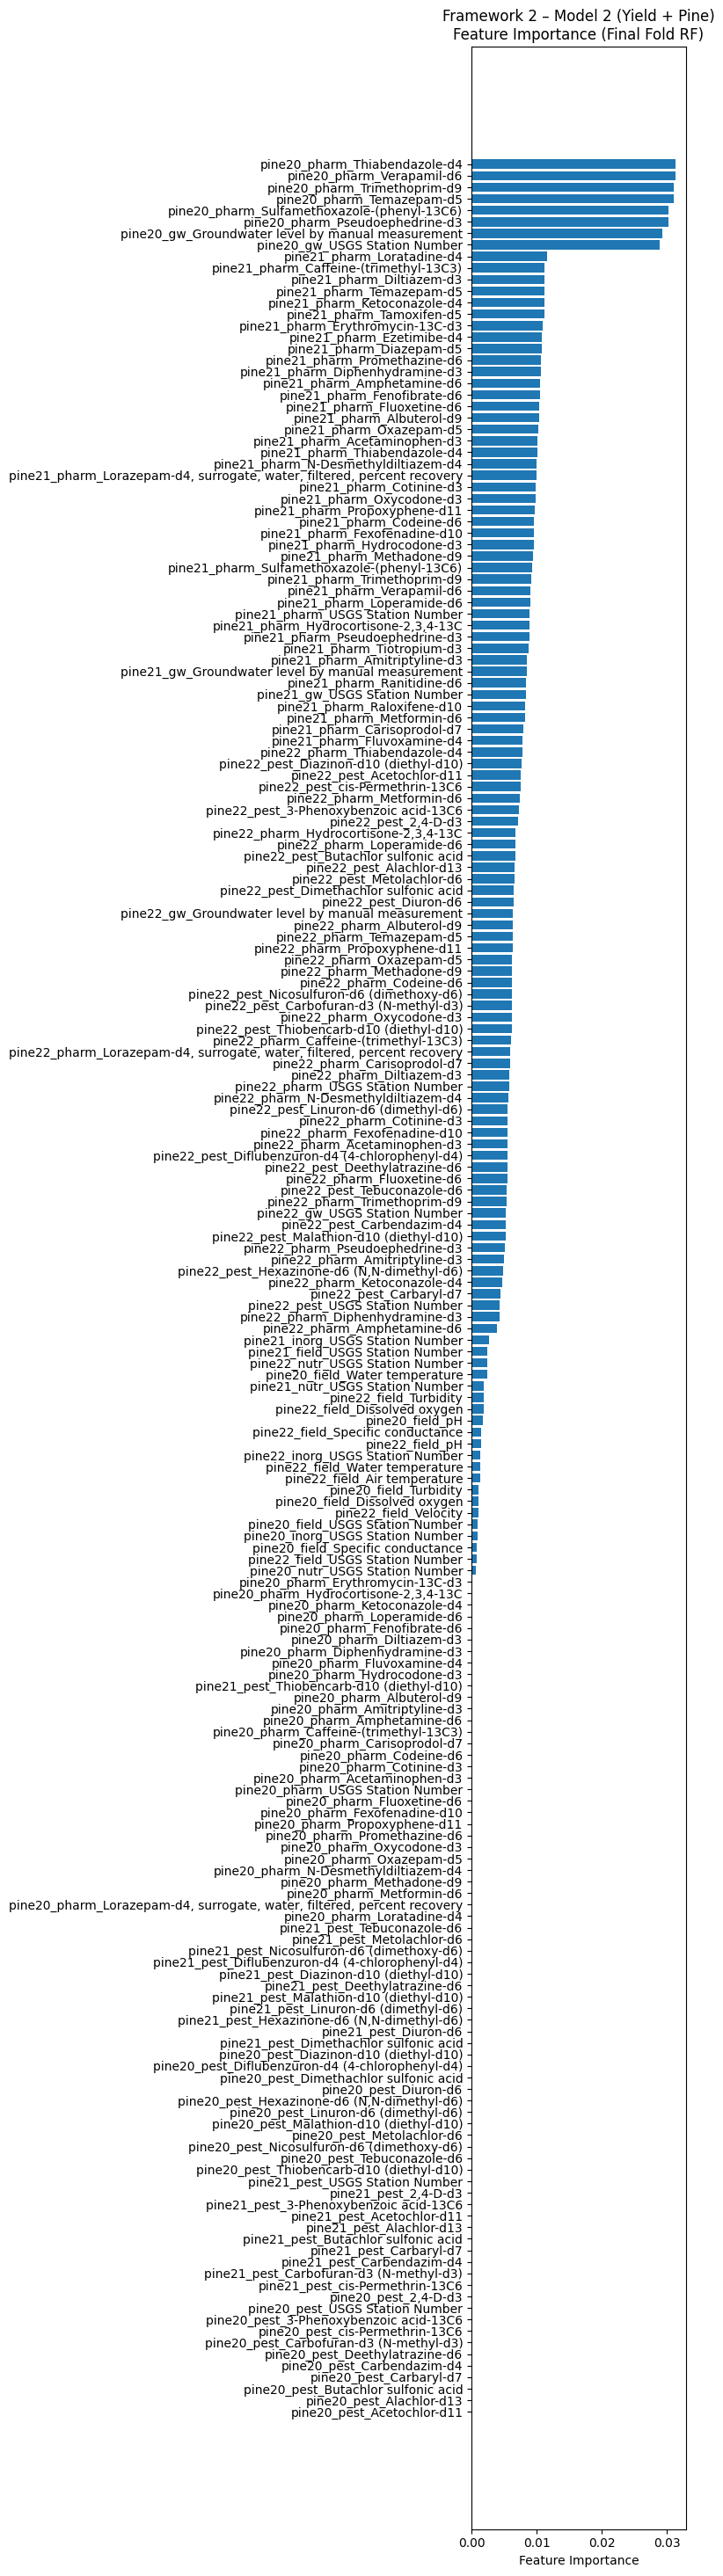

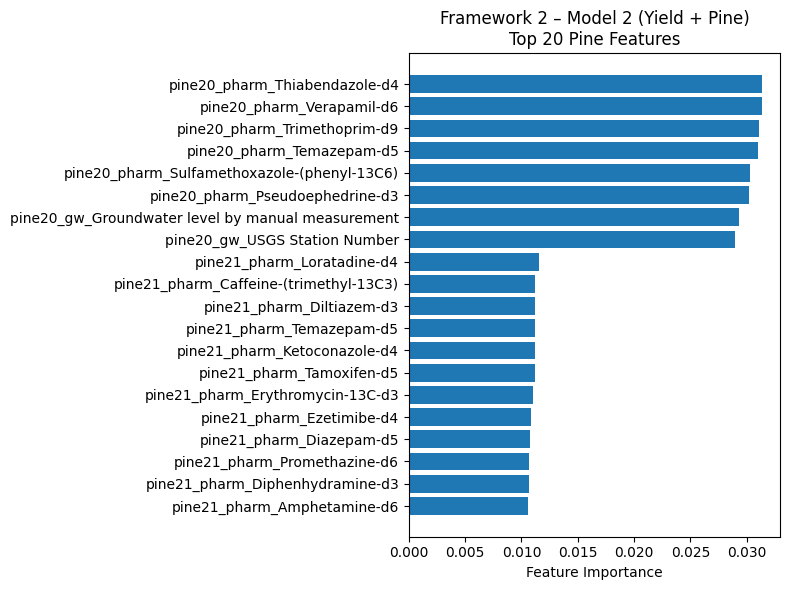

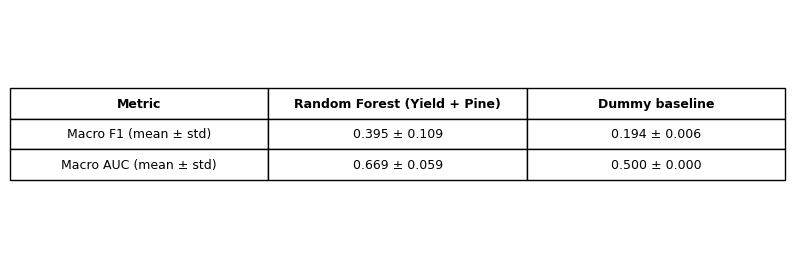

Created zip: framework2_model2_yield_pine_bundle.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [225]:
from google.colab import files as colab_files  # avoid name clash


# --- 1. Safety checks ---
try:
    _ = rf.feature_importances_
except NameError as e:
    raise RuntimeError(
        "rf (RandomForest model) is not defined. "
        "Make sure you run the Model 2 training cell first."
    )

if "feature_cols_yield" not in globals():
    raise RuntimeError(
        "feature_cols_yield is not defined. Run the Model 2 setup cell first."
    )


# --- 2. Compute summary metrics for Model 2 ---
summary_pine = {
    "rf_macro_f1_mean": float(np.mean(f1_rf)),
    "rf_macro_f1_std":  float(np.std(f1_rf)),
    "rf_macro_auc_mean": float(np.mean(auc_rf)),
    "rf_macro_auc_std":  float(np.std(auc_rf)),
    "dummy_macro_f1_mean": float(np.mean(f1_dummy)),
    "dummy_macro_f1_std":  float(np.std(f1_dummy)),
    "dummy_macro_auc_mean": float(np.mean(auc_dummy)),
    "dummy_macro_auc_std":  float(np.std(auc_dummy)),
    "class_counts": np.bincount(y).tolist(),
    "n_samples": int(len(y)),
    "n_splits": 5,
}

print("Model 2 (Yield + Pine) summary:", summary_pine)


# --- 3. Export directory ---
EXPORT_DIR = Path("framework2_model2_yield_pine_exports")
EXPORT_DIR.mkdir(exist_ok=True)
print("Export dir:", EXPORT_DIR)


# --- 4. Feature importance plots (PNG) ---

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)

# 4.1 Full feature importance
plt.figure(figsize=(8, max(4, len(feature_cols_yield) * 0.15)))
plt.barh(
    [feature_cols_yield[i] for i in sorted_idx],
    importances[sorted_idx]
)
plt.xlabel("Feature Importance")
plt.title("Framework 2 – Model 2 (Yield + Pine)\nFeature Importance (Final Fold RF)")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "pine_feature_importance_all.png", dpi=300)
plt.show()

# 4.2 Top 20 features (if there are many)
top_k = min(20, len(feature_cols_yield))
top_idx = np.argsort(importances)[-top_k:]

plt.figure(figsize=(8, max(4, top_k * 0.3)))
plt.barh(
    [feature_cols_yield[i] for i in top_idx],
    importances[top_idx]
)
plt.xlabel("Feature Importance")
plt.title("Framework 2 – Model 2 (Yield + Pine)\nTop 20 Pine Features")
plt.tight_layout()
plt.savefig(EXPORT_DIR / "pine_feature_importance_top20.png", dpi=300)
plt.show()


# --- 5. Training results table: CSV + PNG ---

results_table = pd.DataFrame(
    {
        "Metric": [
            "Macro F1 (mean ± std)",
            "Macro AUC (mean ± std)",
        ],
        "Random Forest (Yield + Pine)": [
            f"{summary_pine['rf_macro_f1_mean']:.3f} ± {summary_pine['rf_macro_f1_std']:.3f}",
            f"{summary_pine['rf_macro_auc_mean']:.3f} ± {summary_pine['rf_macro_auc_std']:.3f}",
        ],
        "Dummy baseline": [
            f"{summary_pine['dummy_macro_f1_mean']:.3f} ± {summary_pine['dummy_macro_f1_std']:.3f}",
            f"{summary_pine['dummy_macro_auc_mean']:.3f} ± {summary_pine['dummy_macro_auc_std']:.3f}",
        ],
    }
)

# 5.1 CSV table
results_table.to_csv(EXPORT_DIR / "model2_yield_pine_training_results_table.csv", index=False)

# 5.2 PNG table for the paper
fig, ax = plt.subplots(figsize=(8, 2.8))
ax.axis("off")

table_data = [results_table.columns.tolist()] + results_table.values.tolist()
table = ax.table(
    cellText=table_data,
    loc="center",
    cellLoc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.6)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")

fig.tight_layout()
fig.savefig(EXPORT_DIR / "model2_yield_pine_training_results_table.png", dpi=300, bbox_inches="tight")
plt.show()

# 5.3 Raw JSON summary
with open(EXPORT_DIR / "model2_yield_pine_training_results.json", "w") as f:
    json.dump(summary_pine, f, indent=2)


# --- 6. Graph-series JSON (for recreating plots later) ---

graphs_json = {}

# 6.1 Full feature importance series
graphs_json["pine_feature_importance_all"] = {
    "feature": feature_cols_yield,
    "importance": importances.tolist(),
    "title": "Framework 2 – Model 2 (Yield + Pine) Feature Importance",
    "x_label": "Importance",
    "y_label": "Feature",
}

# 6.2 Top-20 subset (ordered from lowest → highest as in barh)
graphs_json["pine_feature_importance_top20"] = {
    "feature": [feature_cols_yield[i] for i in top_idx],
    "importance": importances[top_idx].tolist(),
    "title": "Framework 2 – Model 2 (Yield + Pine) Top 20 Features",
    "x_label": "Importance",
    "y_label": "Feature",
    "top_k": int(top_k),
}

with open(EXPORT_DIR / "framework2_model2_yield_pine_graph_data.json", "w") as f:
    json.dump(graphs_json, f, indent=2)


# --- 7. Zip everything and download ---

zip_path = "framework2_model2_yield_pine_bundle.zip"

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, filenames in os.walk(EXPORT_DIR):
        for fname in filenames:
            full_path = Path(root) / fname
            # store paths inside zip relative to EXPORT_DIR
            rel_path = full_path.relative_to(EXPORT_DIR)
            zf.write(full_path, arcname=rel_path)

print("Created zip:", zip_path)
colab_files.download(zip_path)

##Explainability and Feature Attribution
SHAP explanations (summary + beeswarm + per-class)

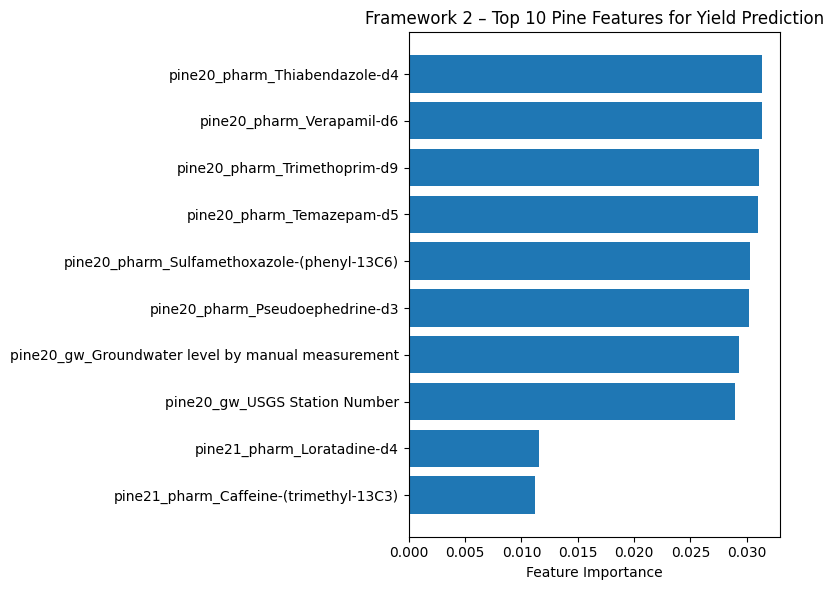

In [228]:
importances = rf.feature_importances_
feature_names = np.array(X.columns)

top_k = 10
top_idx = np.argsort(importances)[-top_k:]

plt.figure(figsize=(8, 6))
plt.barh(feature_names[top_idx], importances[top_idx])
plt.xlabel("Feature Importance")
plt.title("Framework 2 – Top 10 Pine Features for Yield Prediction")
plt.tight_layout()
plt.show()

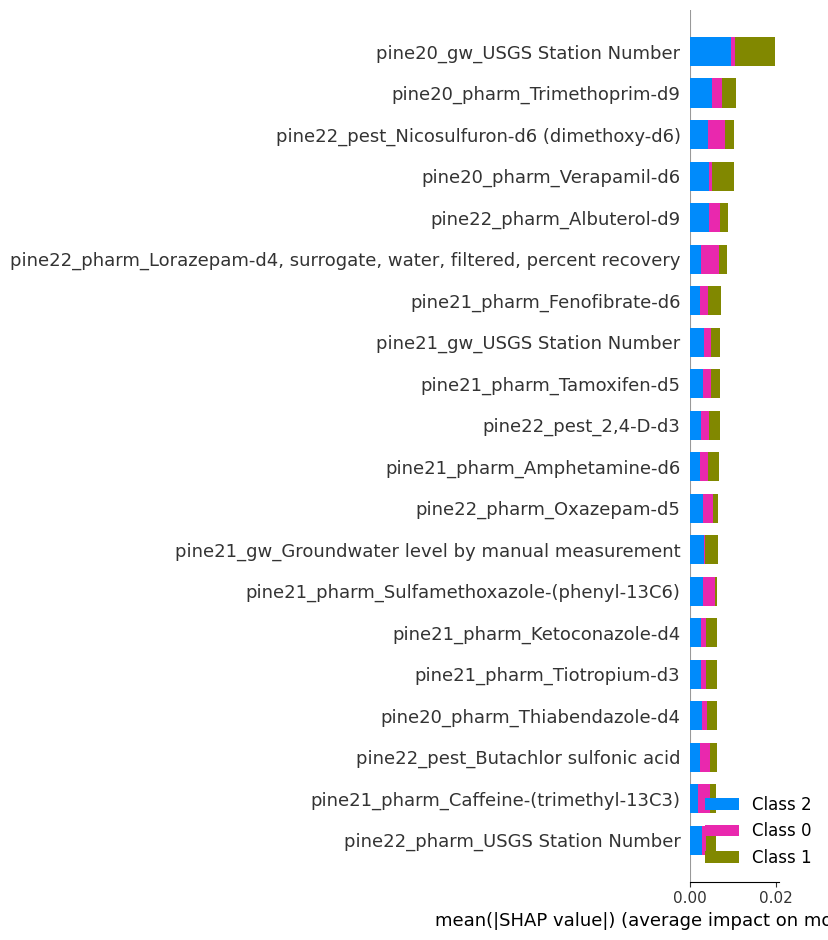

In [229]:
!pip install shap
import shap

# Use a smaller background for speed (e.g., 50 samples)
background = X.sample(n=min(50, len(X)), random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(background)

# Global importance (all classes combined)
shap.summary_plot(shap_values, background, plot_type="bar")


In [230]:
print("X shape:", X.shape)
print("Number of features:", X.shape[1])
print("Trained RF expects:", rf.n_features_in_)

X shape: (117, 196)
Number of features: 196
Trained RF expects: 196


In [231]:
# Use the same features RF was trained on
X_bg = X.copy()         # DataFrame, not numpy
X_bg = X_bg.reset_index(drop=True)

explainer = shap.TreeExplainer(rf)

# VERY IMPORTANT: use X_bg *here*:
shap_values = explainer.shap_values(X_bg)

# Inspect shapes
if isinstance(shap_values, list):
    for i, arr in enumerate(shap_values):
        print(f"class {i} shap_values shape:", arr.shape)
else:
    print("shap_values shape:", shap_values.shape)

print("X_bg shape:", X_bg.shape)

shap_values shape: (117, 196, 3)
X_bg shape: (117, 196)


sv_high shape: (117, 196)
X_bg shape: (117, 196)


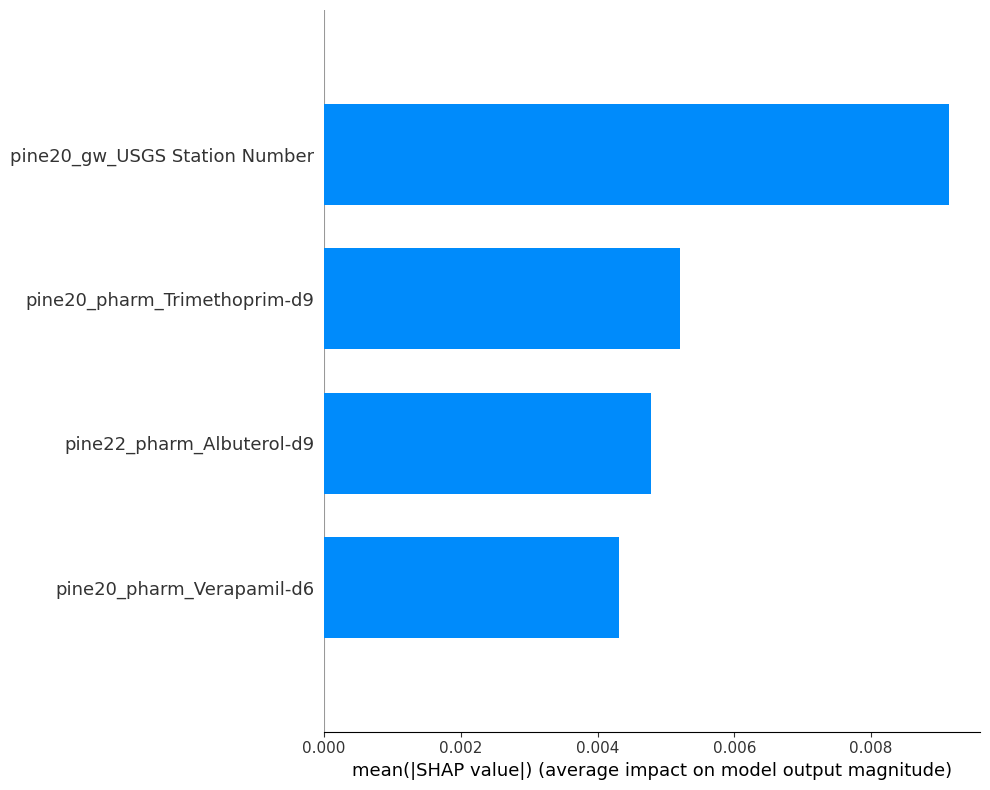

In [232]:
# High-yield class index
high_class = 2

# Extract SHAP values for class 2
sv_high = shap_values[:, :, high_class]  # shape (n_samples, n_features)

print("sv_high shape:", sv_high.shape)
print("X_bg shape:", X_bg.shape)

shap.summary_plot(
    sv_high,
    X_bg,
    feature_names=X_bg.columns,
    plot_type="bar",
    max_display=4,            # top 20
    plot_size=(10, 8)          # wider & taller
)

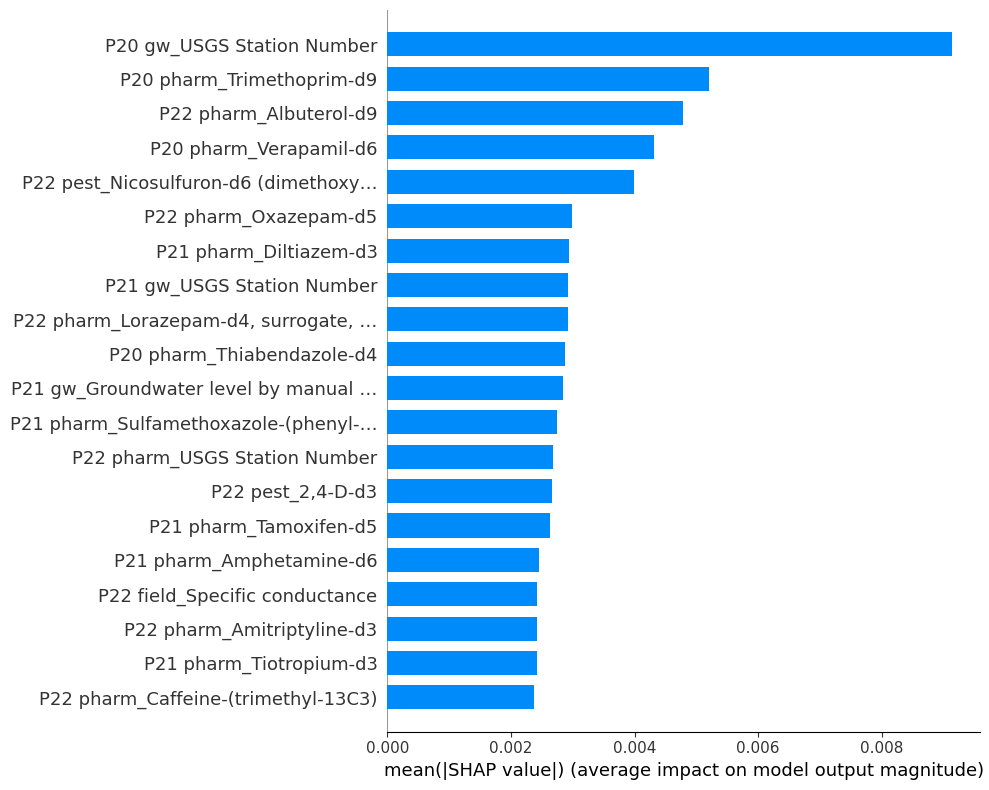

In [233]:
orig_names = X_bg.columns.tolist()
short_names = []

for name in orig_names:
    label = name

    # strip noisy prefixes
    label = label.replace("pine20_", "P20 ")
    label = label.replace("pine21_", "P21 ")
    label = label.replace("pine22_", "P22 ")

    # optional: shorten very long chemical descriptions
    if len(label) > 35:
        label = label[:35] + "…"

    short_names.append(label)

shap.summary_plot(
    sv_high,
    X_bg,
    feature_names=short_names,
    plot_type="bar",
    max_display=20,
    plot_size=(10, 8)
)


In [234]:
top_idx = np.argsort(np.abs(sv_high).mean(0))[::-1][:20]
for i in top_idx:
    print(f"{short_names[i]:40s}  ->  {orig_names[i]}")


P20 gw_USGS Station Number                ->  pine20_gw_USGS Station Number
P20 pharm_Trimethoprim-d9                 ->  pine20_pharm_Trimethoprim-d9
P22 pharm_Albuterol-d9                    ->  pine22_pharm_Albuterol-d9
P20 pharm_Verapamil-d6                    ->  pine20_pharm_Verapamil-d6
P22 pest_Nicosulfuron-d6 (dimethoxy…      ->  pine22_pest_Nicosulfuron-d6 (dimethoxy-d6)
P22 pharm_Oxazepam-d5                     ->  pine22_pharm_Oxazepam-d5
P21 pharm_Diltiazem-d3                    ->  pine21_pharm_Diltiazem-d3
P21 gw_USGS Station Number                ->  pine21_gw_USGS Station Number
P22 pharm_Lorazepam-d4, surrogate, …      ->  pine22_pharm_Lorazepam-d4, surrogate, water, filtered, percent recovery
P20 pharm_Thiabendazole-d4                ->  pine20_pharm_Thiabendazole-d4
P21 gw_Groundwater level by manual …      ->  pine21_gw_Groundwater level by manual measurement
P21 pharm_Sulfamethoxazole-(phenyl-…      ->  pine21_pharm_Sulfamethoxazole-(phenyl-13C6)
P22 pharm_USGS St

####Exports

In [236]:
!pip install shap -q
from google.colab import files as colab_files

# --- 2. Correct handling of multi-class / binary SHAP values ---

if isinstance(shap_values, list):
    # Classic multi-class: list of (n_samples, n_features) arrays
    n_classes = len(shap_values)
    high_class = min(2, n_classes - 1)  # prefer class 2 if it exists
    sv_high = shap_values[high_class]   # (n_samples, n_features)
    print(f"Detected multi-class list with {n_classes} classes. Using high_class = {high_class}.")
else:
    # shap_values is a single ndarray
    if shap_values.ndim == 3:
        # shape: (n_samples, n_features, n_classes)
        n_samples, n_features, n_classes = shap_values.shape
        high_class = min(2, n_classes - 1)
        sv_high = shap_values[:, :, high_class]   # (n_samples, n_features)
        print(f"Detected multi-class array {shap_values.shape}. Using high_class = {high_class}.")
    elif shap_values.ndim == 2:
        # shape: (n_samples, n_features) – binary (class 1)
        n_samples, n_features = shap_values.shape
        n_classes = 2
        high_class = 1
        sv_high = shap_values
        print("Detected binary RF. Treating shap_values as class 1 explanation.")
    else:
        raise ValueError(f"Unexpected shap_values.ndim = {shap_values.ndim}")

print("sv_high shape (after fixing):", sv_high.shape)
print("X_bg shape:", X_bg.shape)

orig_names = list(X_bg.columns)

# --- 3. (Optional) rebuild short_names if needed ---

short_names = []
for name in orig_names:
    label = name
    label = label.replace("pine20_", "P20 ")
    label = label.replace("pine21_", "P21 ")
    label = label.replace("pine22_", "P22 ")
    if len(label) > 35:
        label = label[:35] + "…"
    short_names.append(label)

# --- 4. Top-20 SHAP features (high-yield class) + table ---

mean_abs_shap = np.abs(sv_high).mean(axis=0)   # (n_features,)
top_k = min(20, len(orig_names))
top_idx = np.argsort(mean_abs_shap)[::-1][:top_k]  # 1D array of ints

top_ranks = np.arange(1, top_k + 1)
top_short = [short_names[int(i)] for i in top_idx]
top_full  = [orig_names[int(i)] for i in top_idx]
top_vals  = mean_abs_shap[top_idx]

df_top = pd.DataFrame(
    {
        "Rank": top_ranks,
        "Display name": top_short,
        "Full feature name": top_full,
        "Mean |SHAP| (high-yield class)": top_vals,
    }
)

EXPORT_DIR = Path("framework2_model2_yield_pine_exports")
EXPORT_DIR.mkdir(exist_ok=True)

# 4.1 Save as CSV
df_top.to_csv(EXPORT_DIR / "shap_top20_high_class_features.csv", index=False)

# 4.2 Save PNG table
fig, ax = plt.subplots(figsize=(10, 0.4 * (top_k + 2)))
ax.axis("off")

table_data = [df_top.columns.tolist()] + df_top.values.tolist()
table = ax.table(
    cellText=table_data,
    loc="center",
    cellLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.1, 1.4)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")

fig.tight_layout()
fig.savefig(
    EXPORT_DIR / "shap_top20_high_class_features_table.png",
    dpi=300,
    bbox_inches="tight"
)
plt.close()

print("Saved SHAP top-20 table PNG and CSV.")

# --- 5. JSON for SHAP ranking (for re-creating plots later) ---

shap_json = {
    "high_class_index": int(high_class),
    "feature_order_top20": top_full,
    "display_names_top20": top_short,
    "mean_abs_shap_top20": top_vals.tolist(),
    "all_features": orig_names,
}

with open(EXPORT_DIR / "framework2_model2_yield_pine_shap_top20.json", "w") as f:
    json.dump(shap_json, f, indent=2)

print("Saved SHAP top-20 JSON.")

# --- 6. Rebuild ZIP including these files ---

zip_path = "framework2_model2_yield_pine_bundle.zip"

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, filenames in os.walk(EXPORT_DIR):
        for fname in filenames:
            full_path = Path(root) / fname
            rel_path = full_path.relative_to(EXPORT_DIR)
            zf.write(full_path, arcname=rel_path)

print("Updated zip with SHAP outputs:", zip_path)
colab_files.download(zip_path)

Detected multi-class array (117, 196, 3). Using high_class = 2.
sv_high shape (after fixing): (117, 196)
X_bg shape: (117, 196)
Saved SHAP top-20 table PNG and CSV.
Saved SHAP top-20 JSON.
Updated zip with SHAP outputs: framework2_model2_yield_pine_bundle.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Model Export

In [ ]:
FRONTEND_DATA = Path("frontend_data")
FRONTEND_DATA.mkdir(exist_ok=True)

# NYC distribution monthly (Framework 1A)
dist_export = dist_monthly[[
    "site", "year_month",
    "residual_chlorine_mean",
    "turbidity_mean",
    "fluoride_mean",
    "y"
]].copy()

dist_export.to_json(
    FRONTEND_DATA / "dist_monthly.json",
    orient="records"
)

# Surface waters monthly (Framework 1B) – only 1970+ for consistency
surf_export = dm_1970[[
    "month_start",
    "domain",
    "temp_C_mean",
    "turbidity_ntu_mean",
    "ph_mean",
    "cond_uscm_mean",
    "nitrate_mgL_mean",
    "phosphorus_mgL_mean",
    "y_surface"
]].copy()

surf_export["month_start"] = surf_export["month_start"].dt.strftime("%Y-%m-%d")

surf_export.to_json(
    FRONTEND_DATA / "surface_monthly.json",
    orient="records"
)

# Yield panel with label (Framework 2)
yield_export = panel[[
    "YEAR",
    "COUNTY_NAME",
    "COMMODITY",
    "YIELD",
    "y_yield"
]].copy()

yield_export.to_json(
    FRONTEND_DATA / "yield_panel.json",
    orient="records"
)

In [ ]:
files.download("frontend_data/dist_monthly.json")
files.download("frontend_data/surface_monthly.json")
files.download("frontend_data/yield_panel.json")